In [21]:
import numpy as np
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
from matplotlib import rc
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# # Check if GPU is available
# if tf.test.is_gpu_available():
#     print("GPU is available")
#     print("GPU devices:", tf.config.list_physical_devices('GPU'))
# else:
#     print("GPU is not available")
#     print("CPU devices:", tf.config.list_physical_devices('CPU'))

In [22]:
GESTURES = [
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
    "K", "L","M", "N", "O", "P", "Q", "R", "S", "T",
    "U", "V","W", "X", "Y", "Z", "idle"
]

g = 9.81


NUM_OF_RECORDINGS = 400
dfs_train = []
for label in GESTURES:
    for i in range(NUM_OF_RECORDINGS):
        df_train = pd.read_csv(f"csv/official/{label}/PCA/{label}_{i}_pca.csv")
        df_train = df_train.iloc[14:85]
        df_train['label'] = label
    
        dfs_train.append(df_train)
df_train = pd.concat(dfs_train)

print (df_train.shape)

(705325, 4)


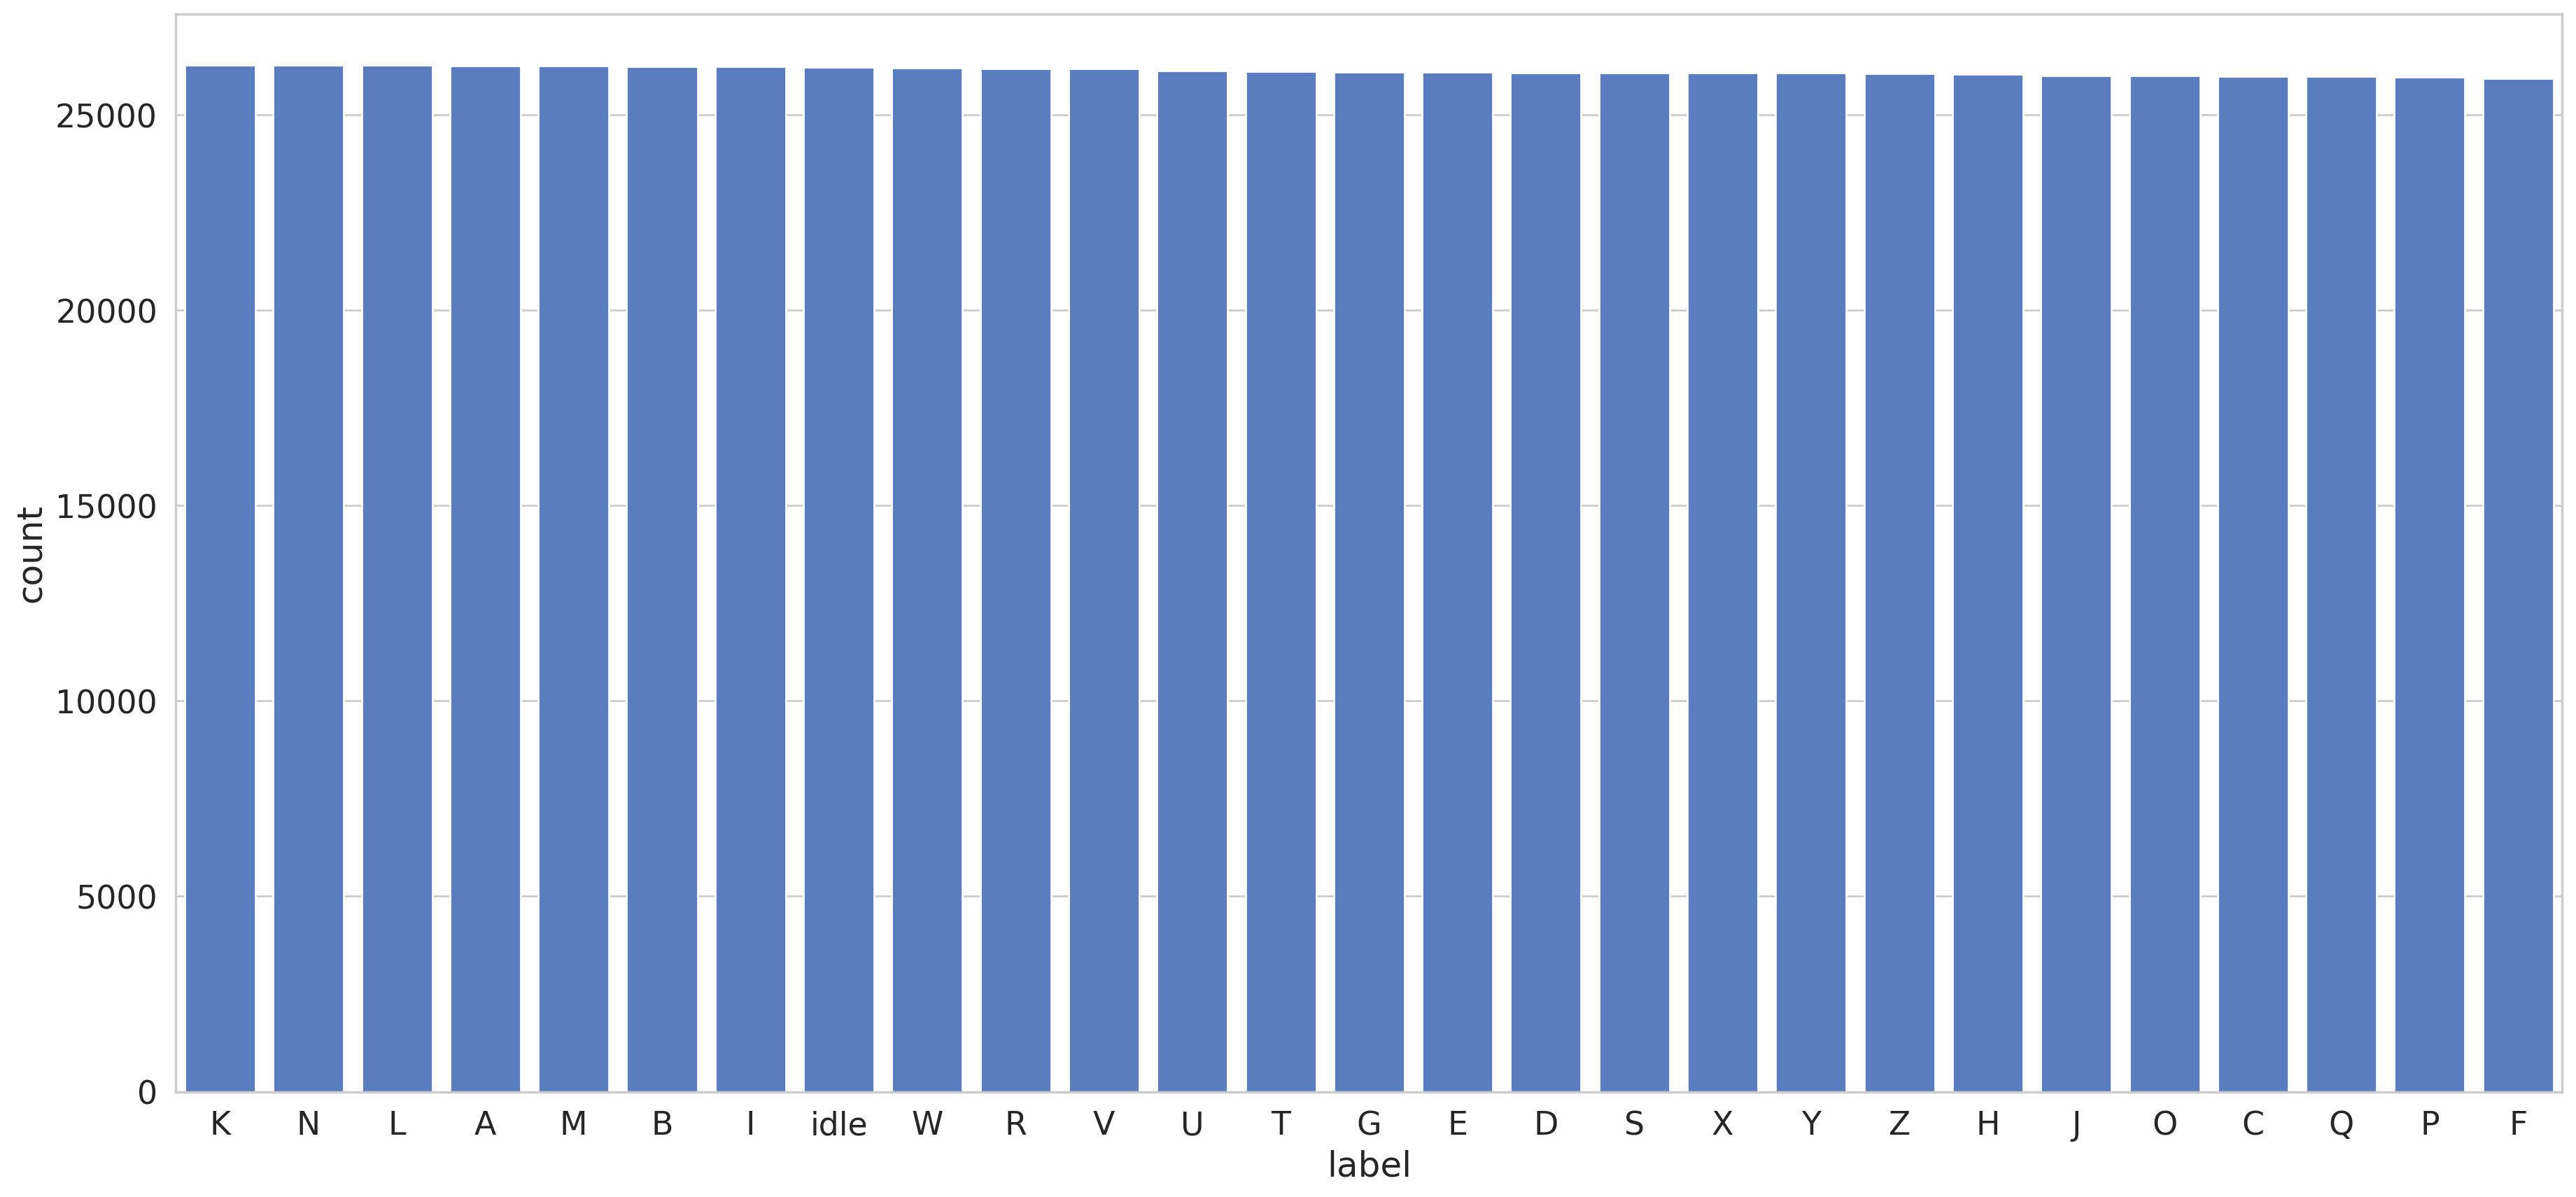

In [23]:
sns.countplot(x = 'label',
              data = df_train,
              order = df_train.label.value_counts().index);

In [24]:
def plot_label(label, df_train):
    data = df_train[df_train['label'] == label][['principal1','principal2','principal3']][:70]
    axis = data.plot(subplots=True, figsize=(16, 12), title=label)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

/home/duyhoa/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


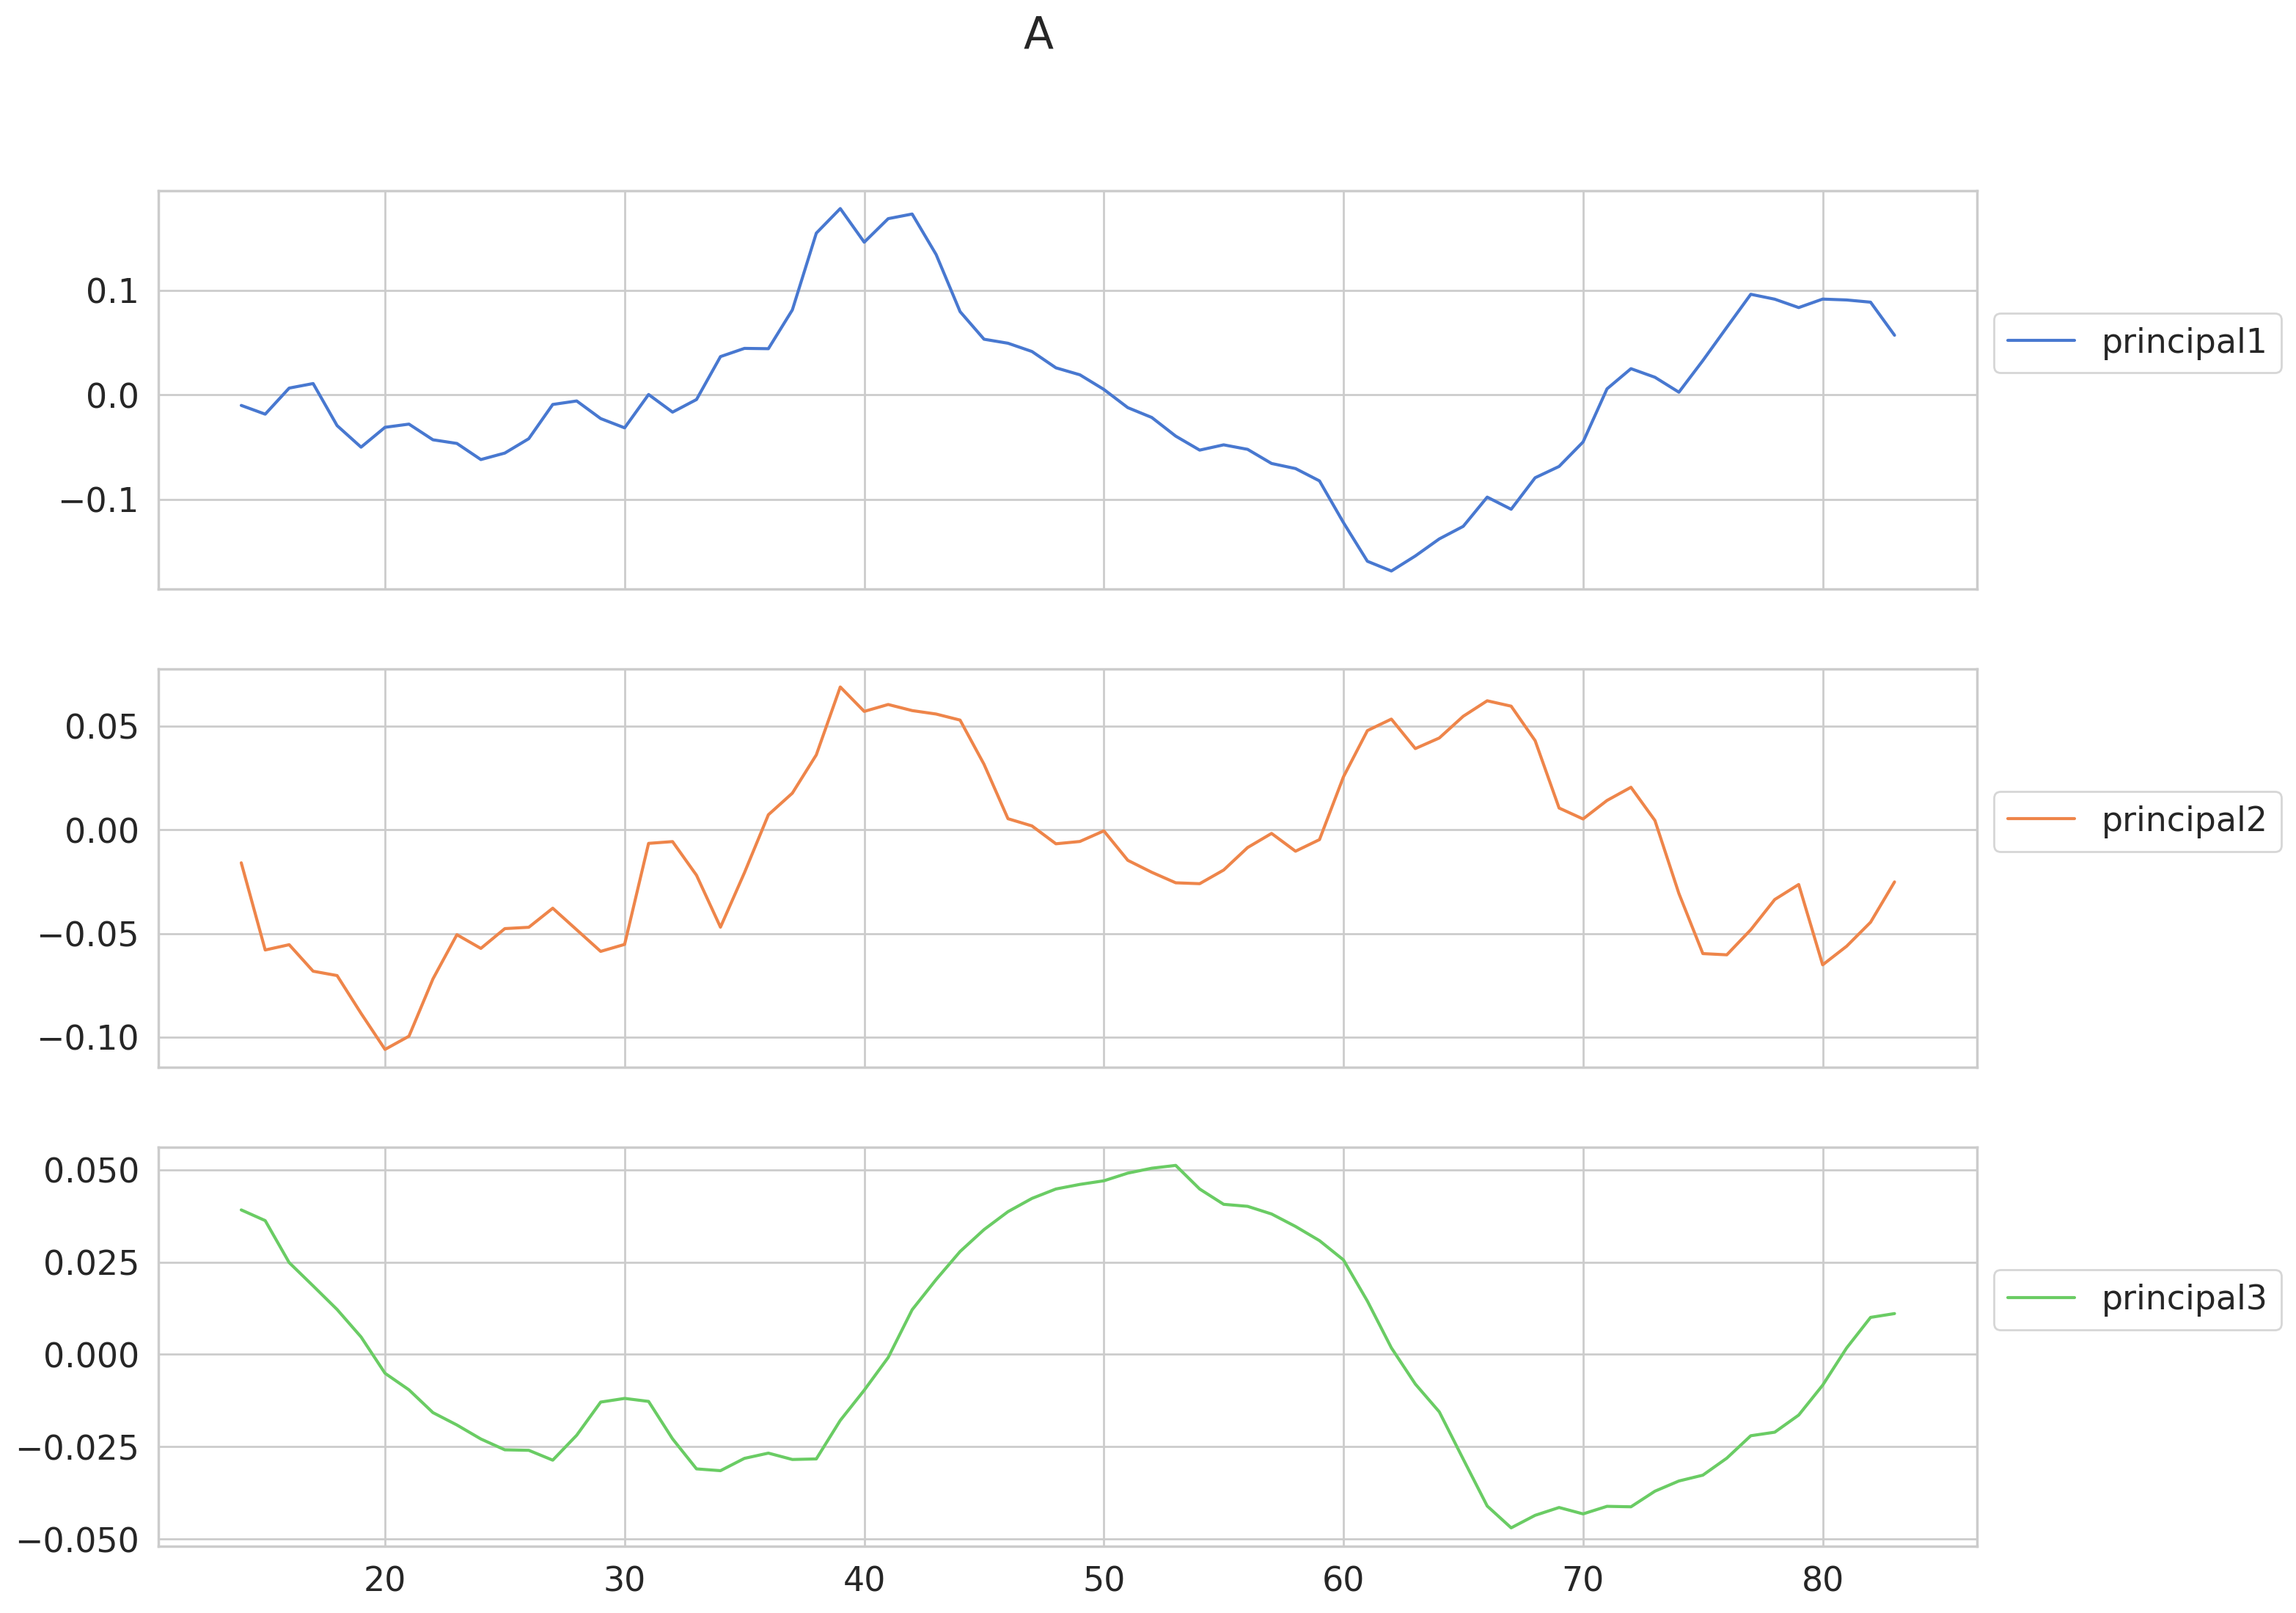

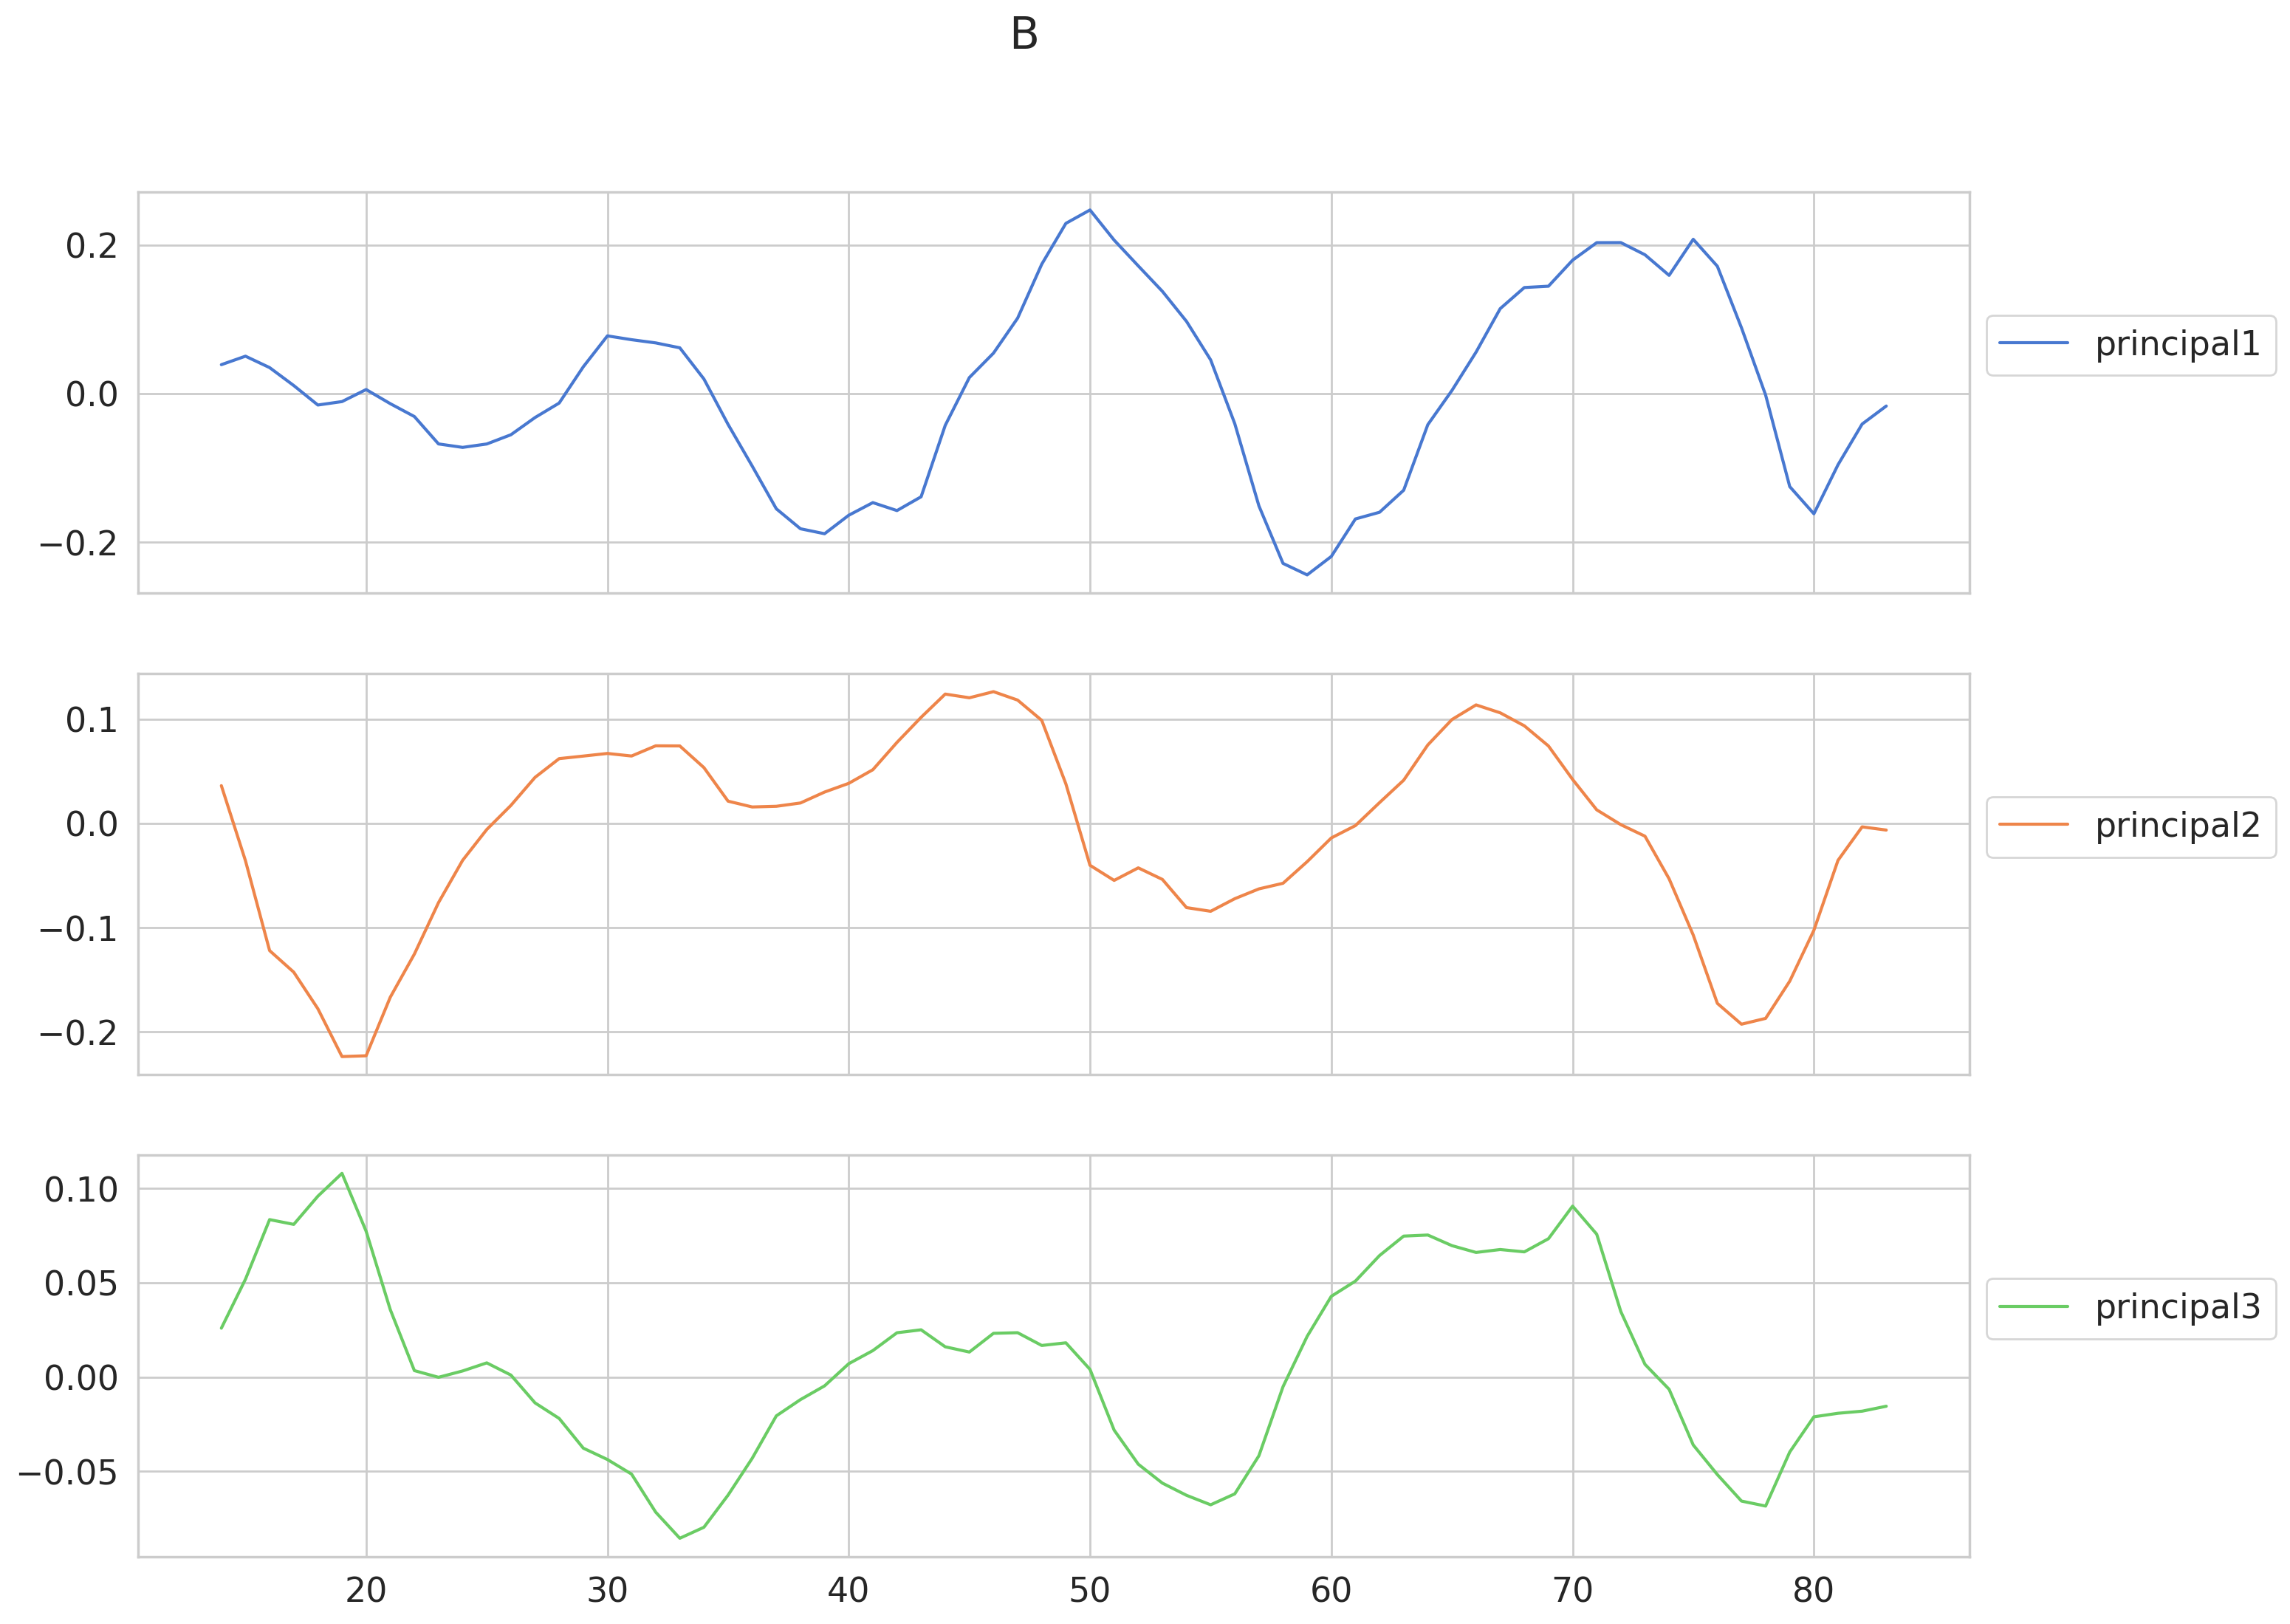

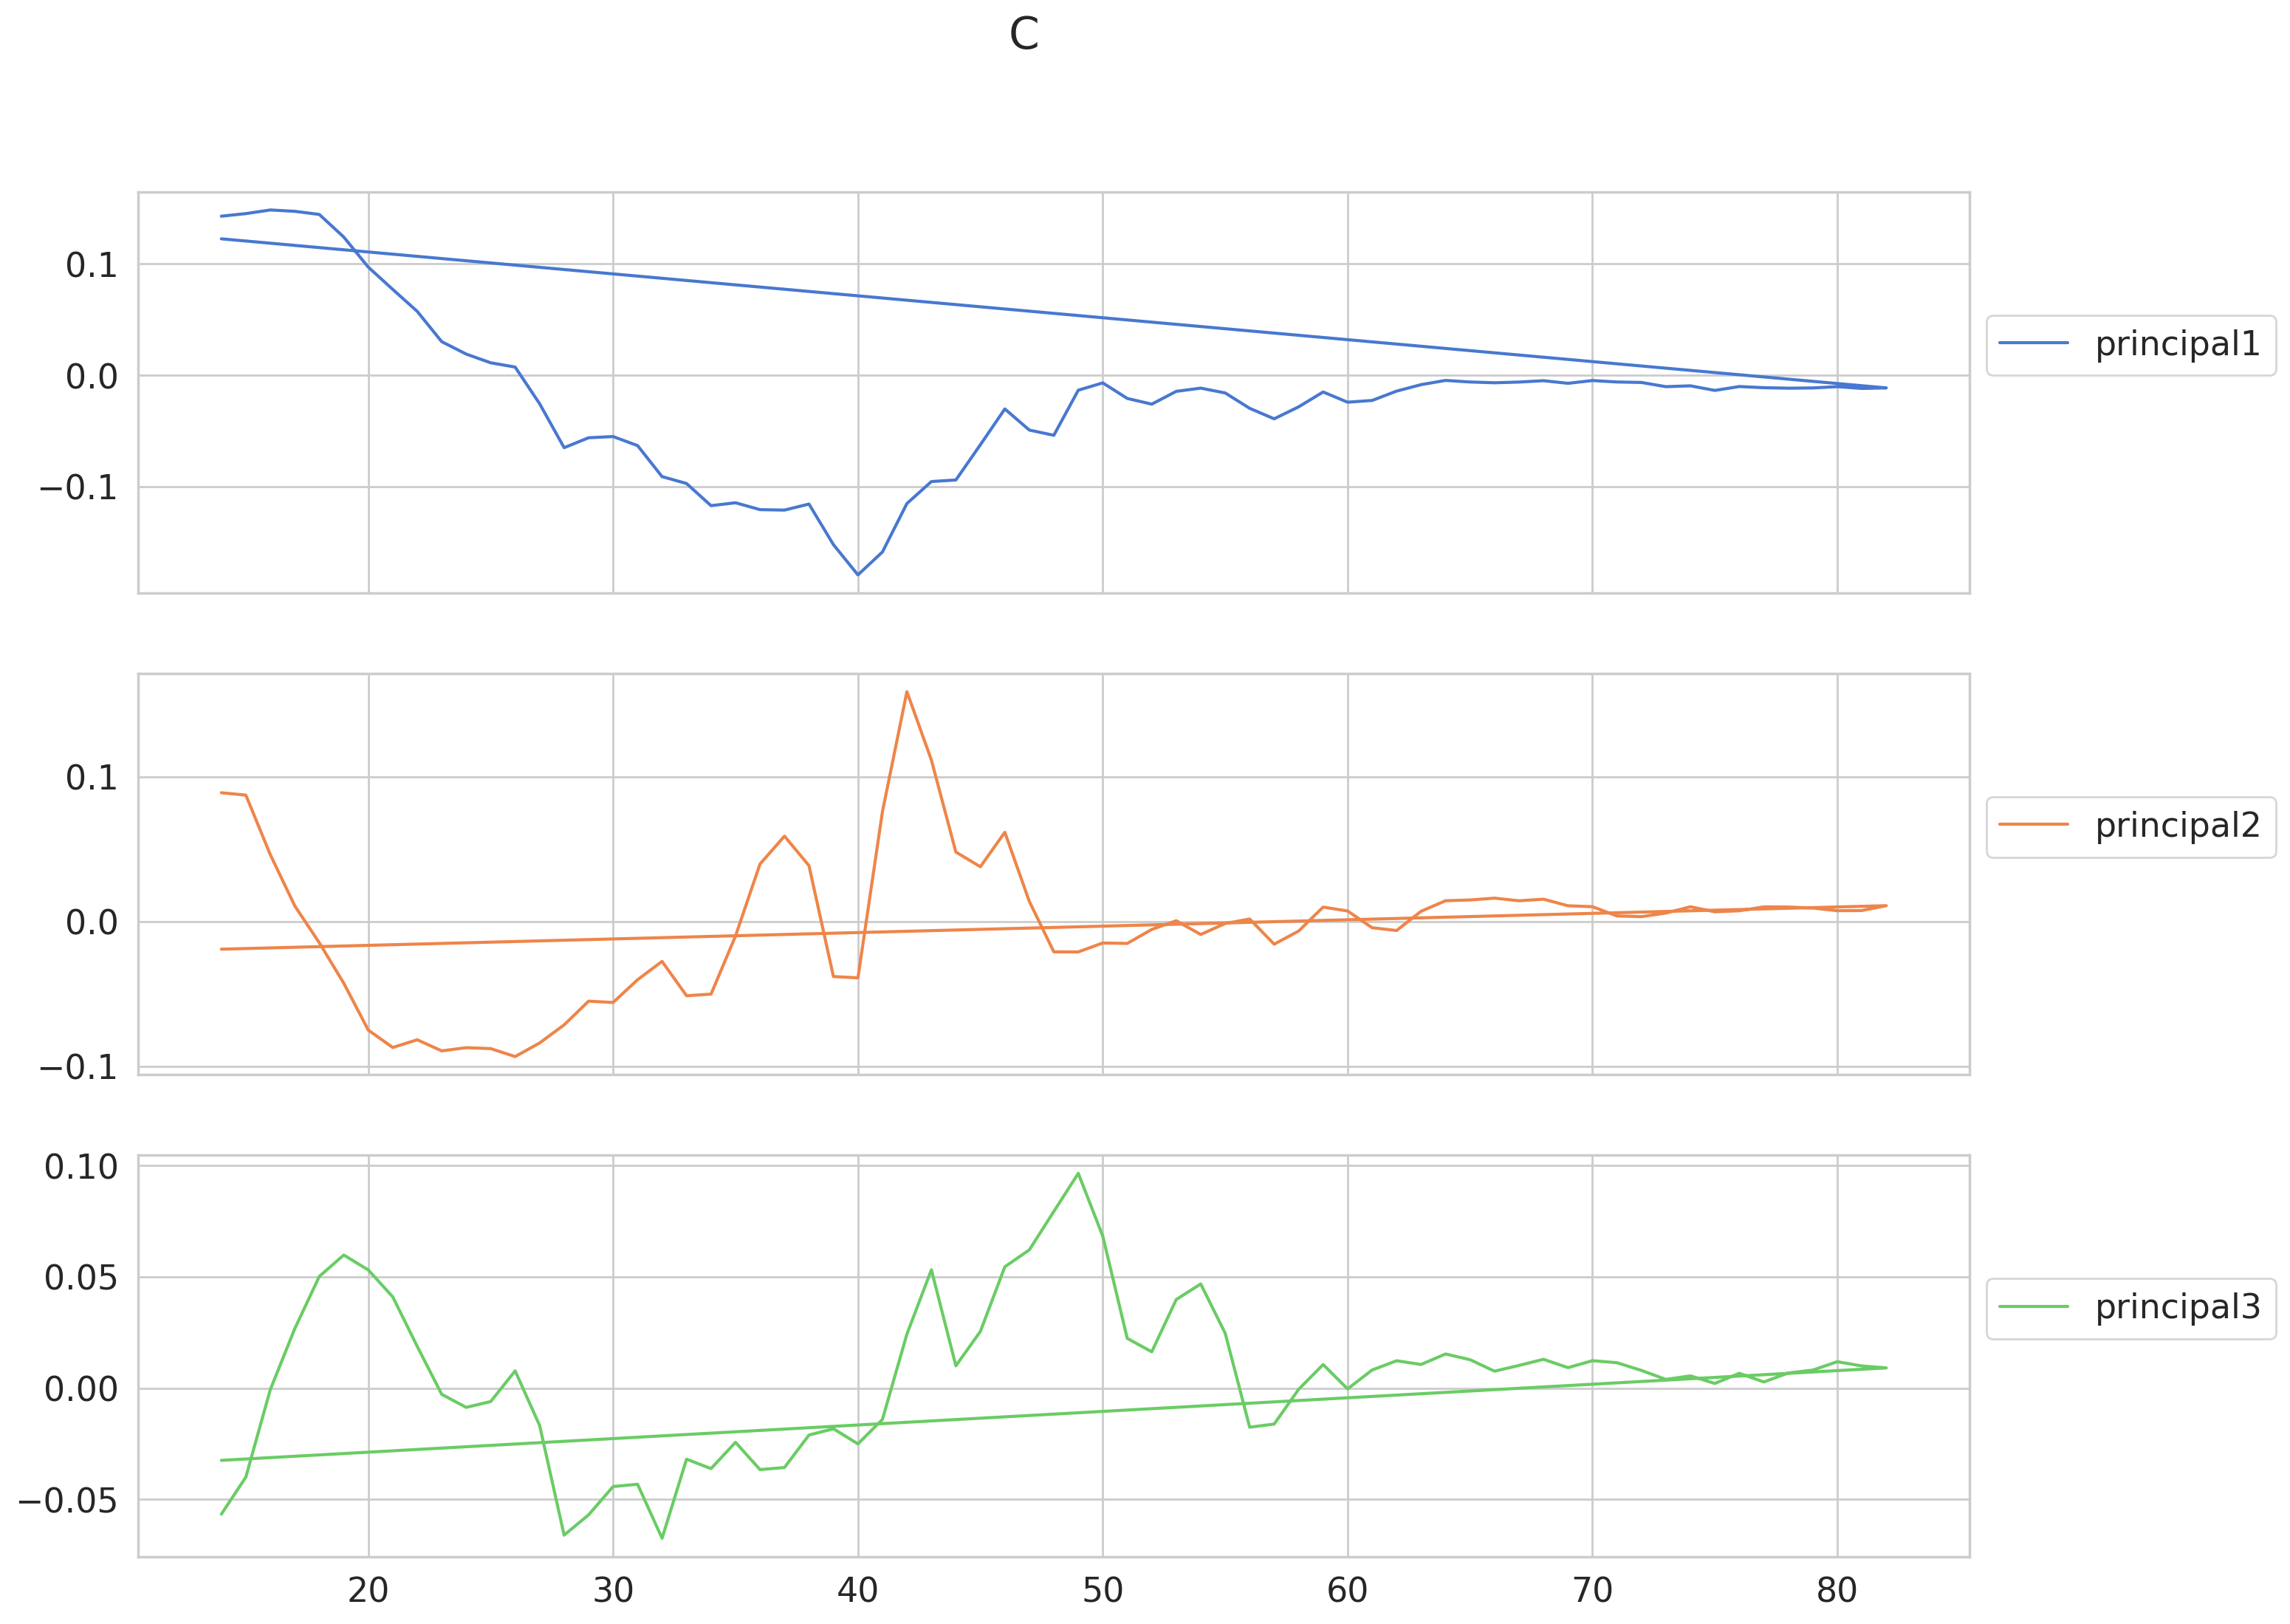

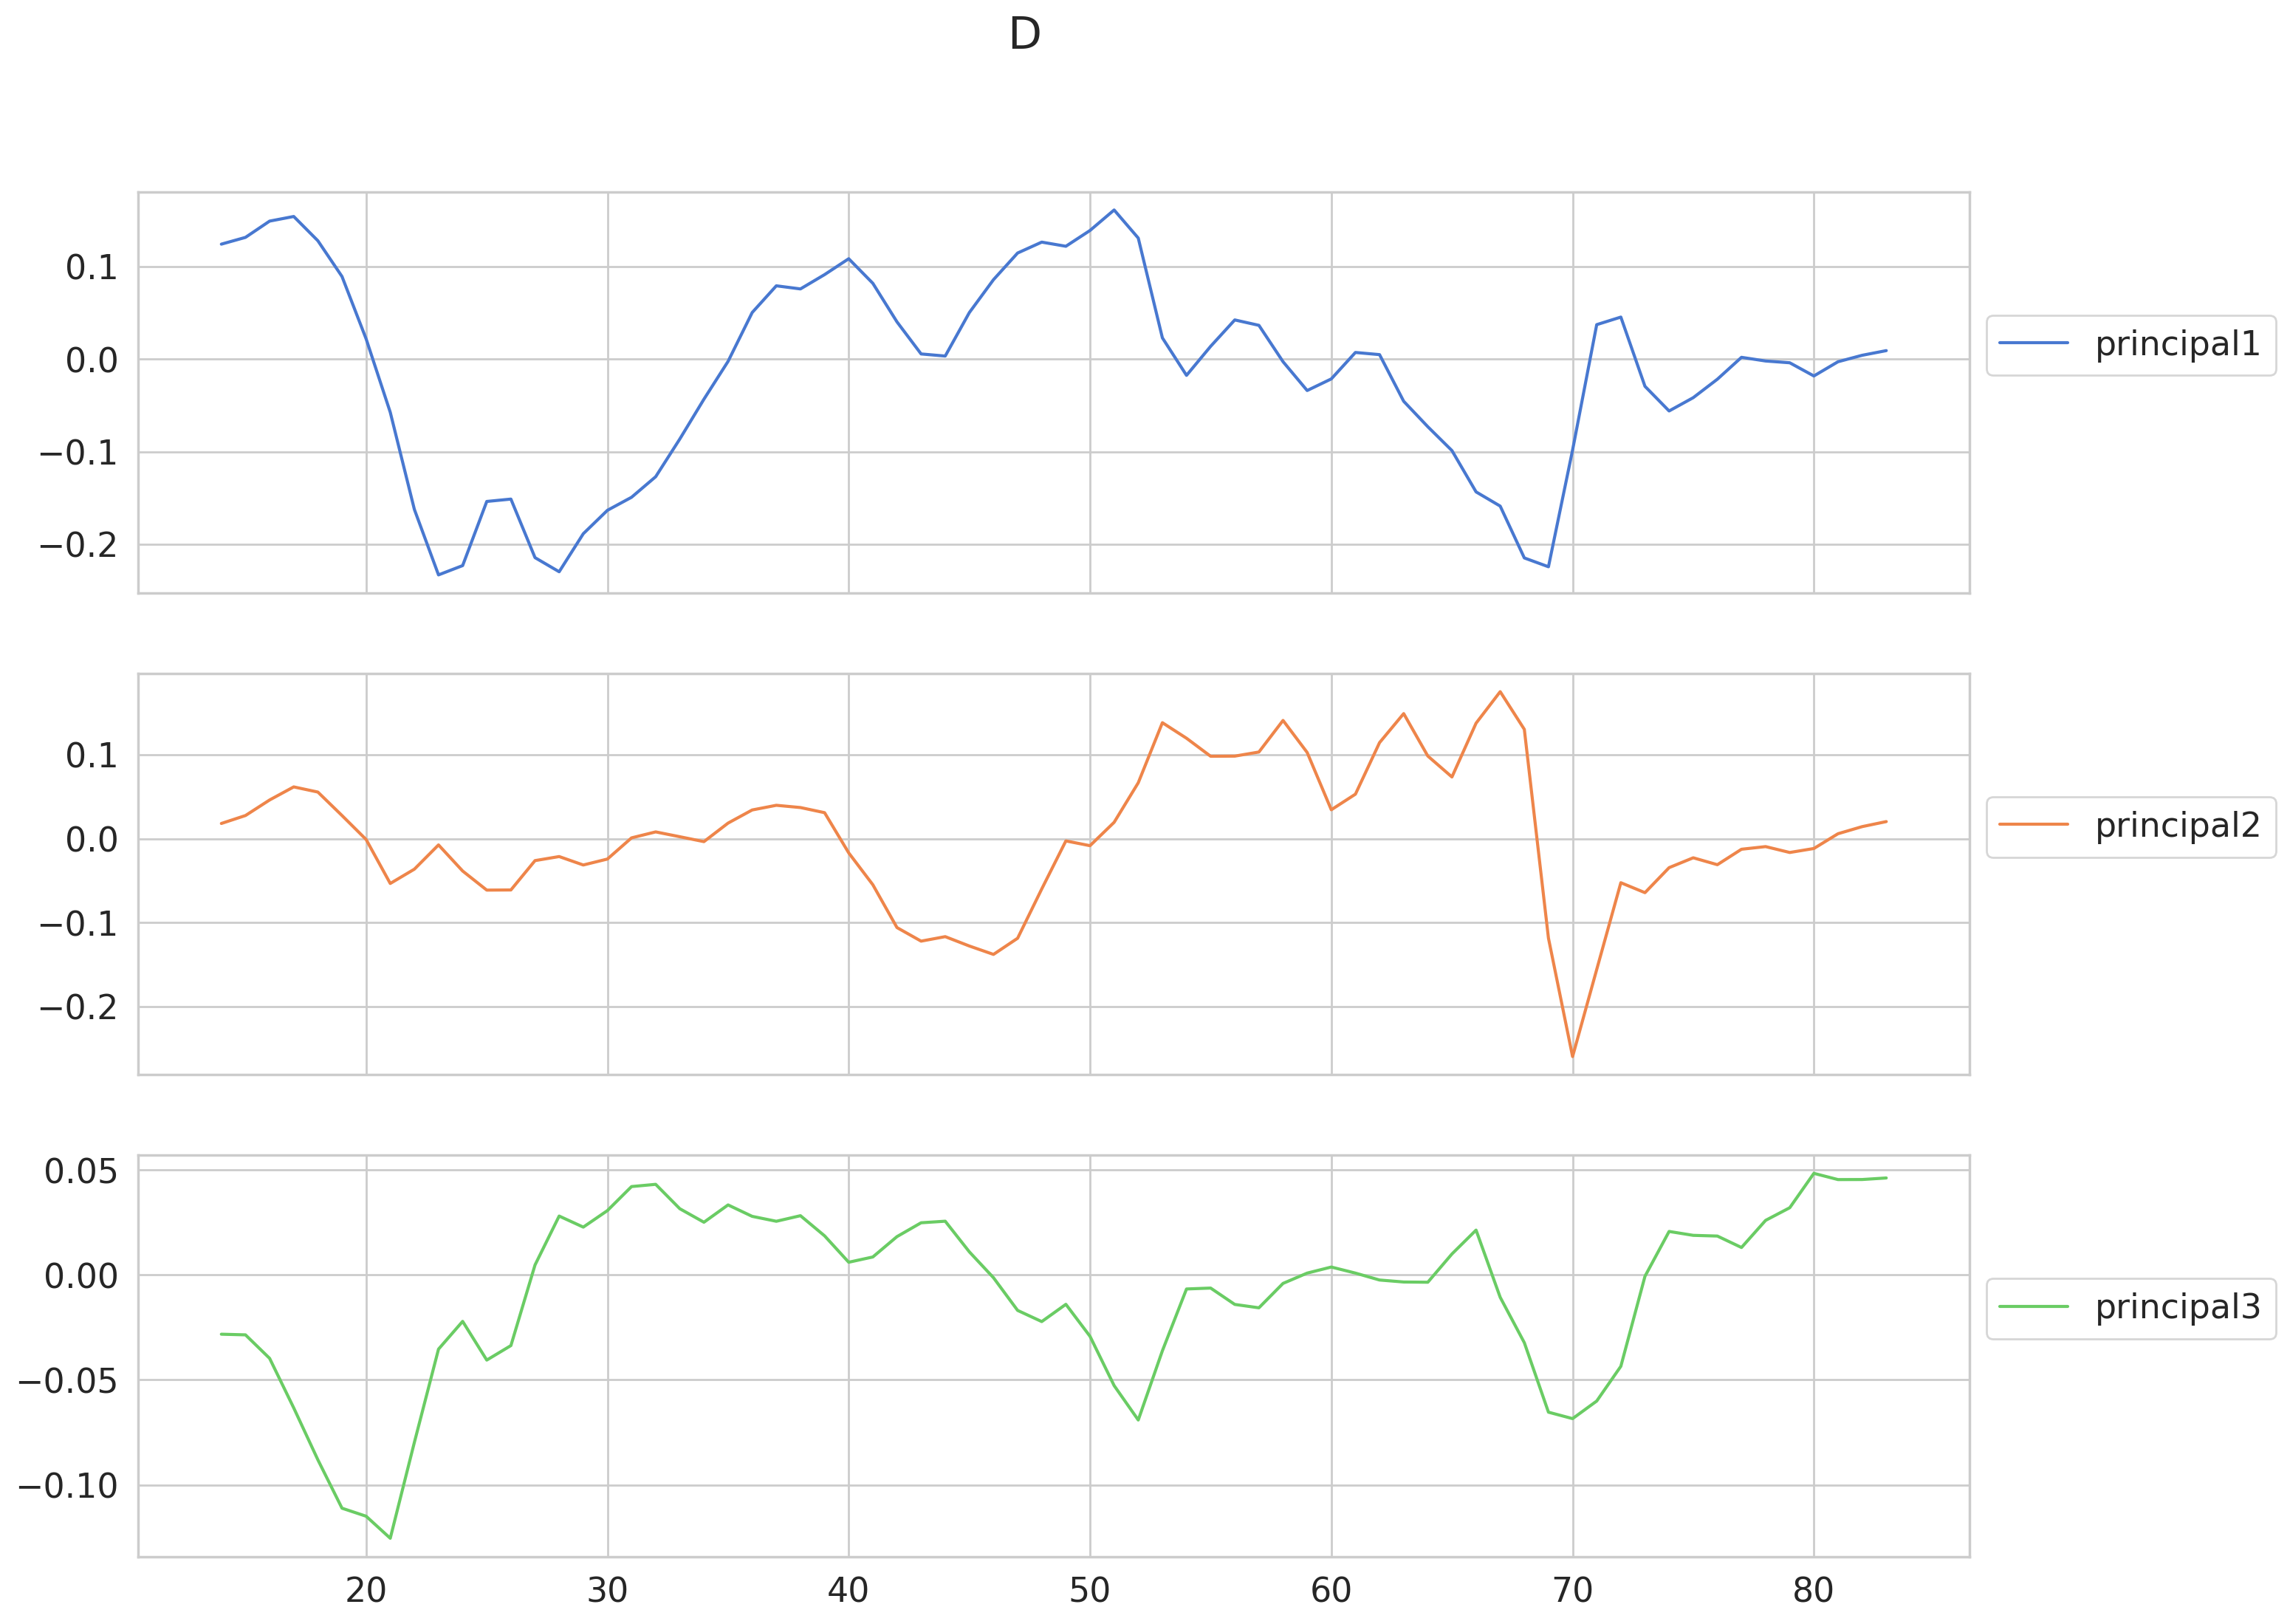

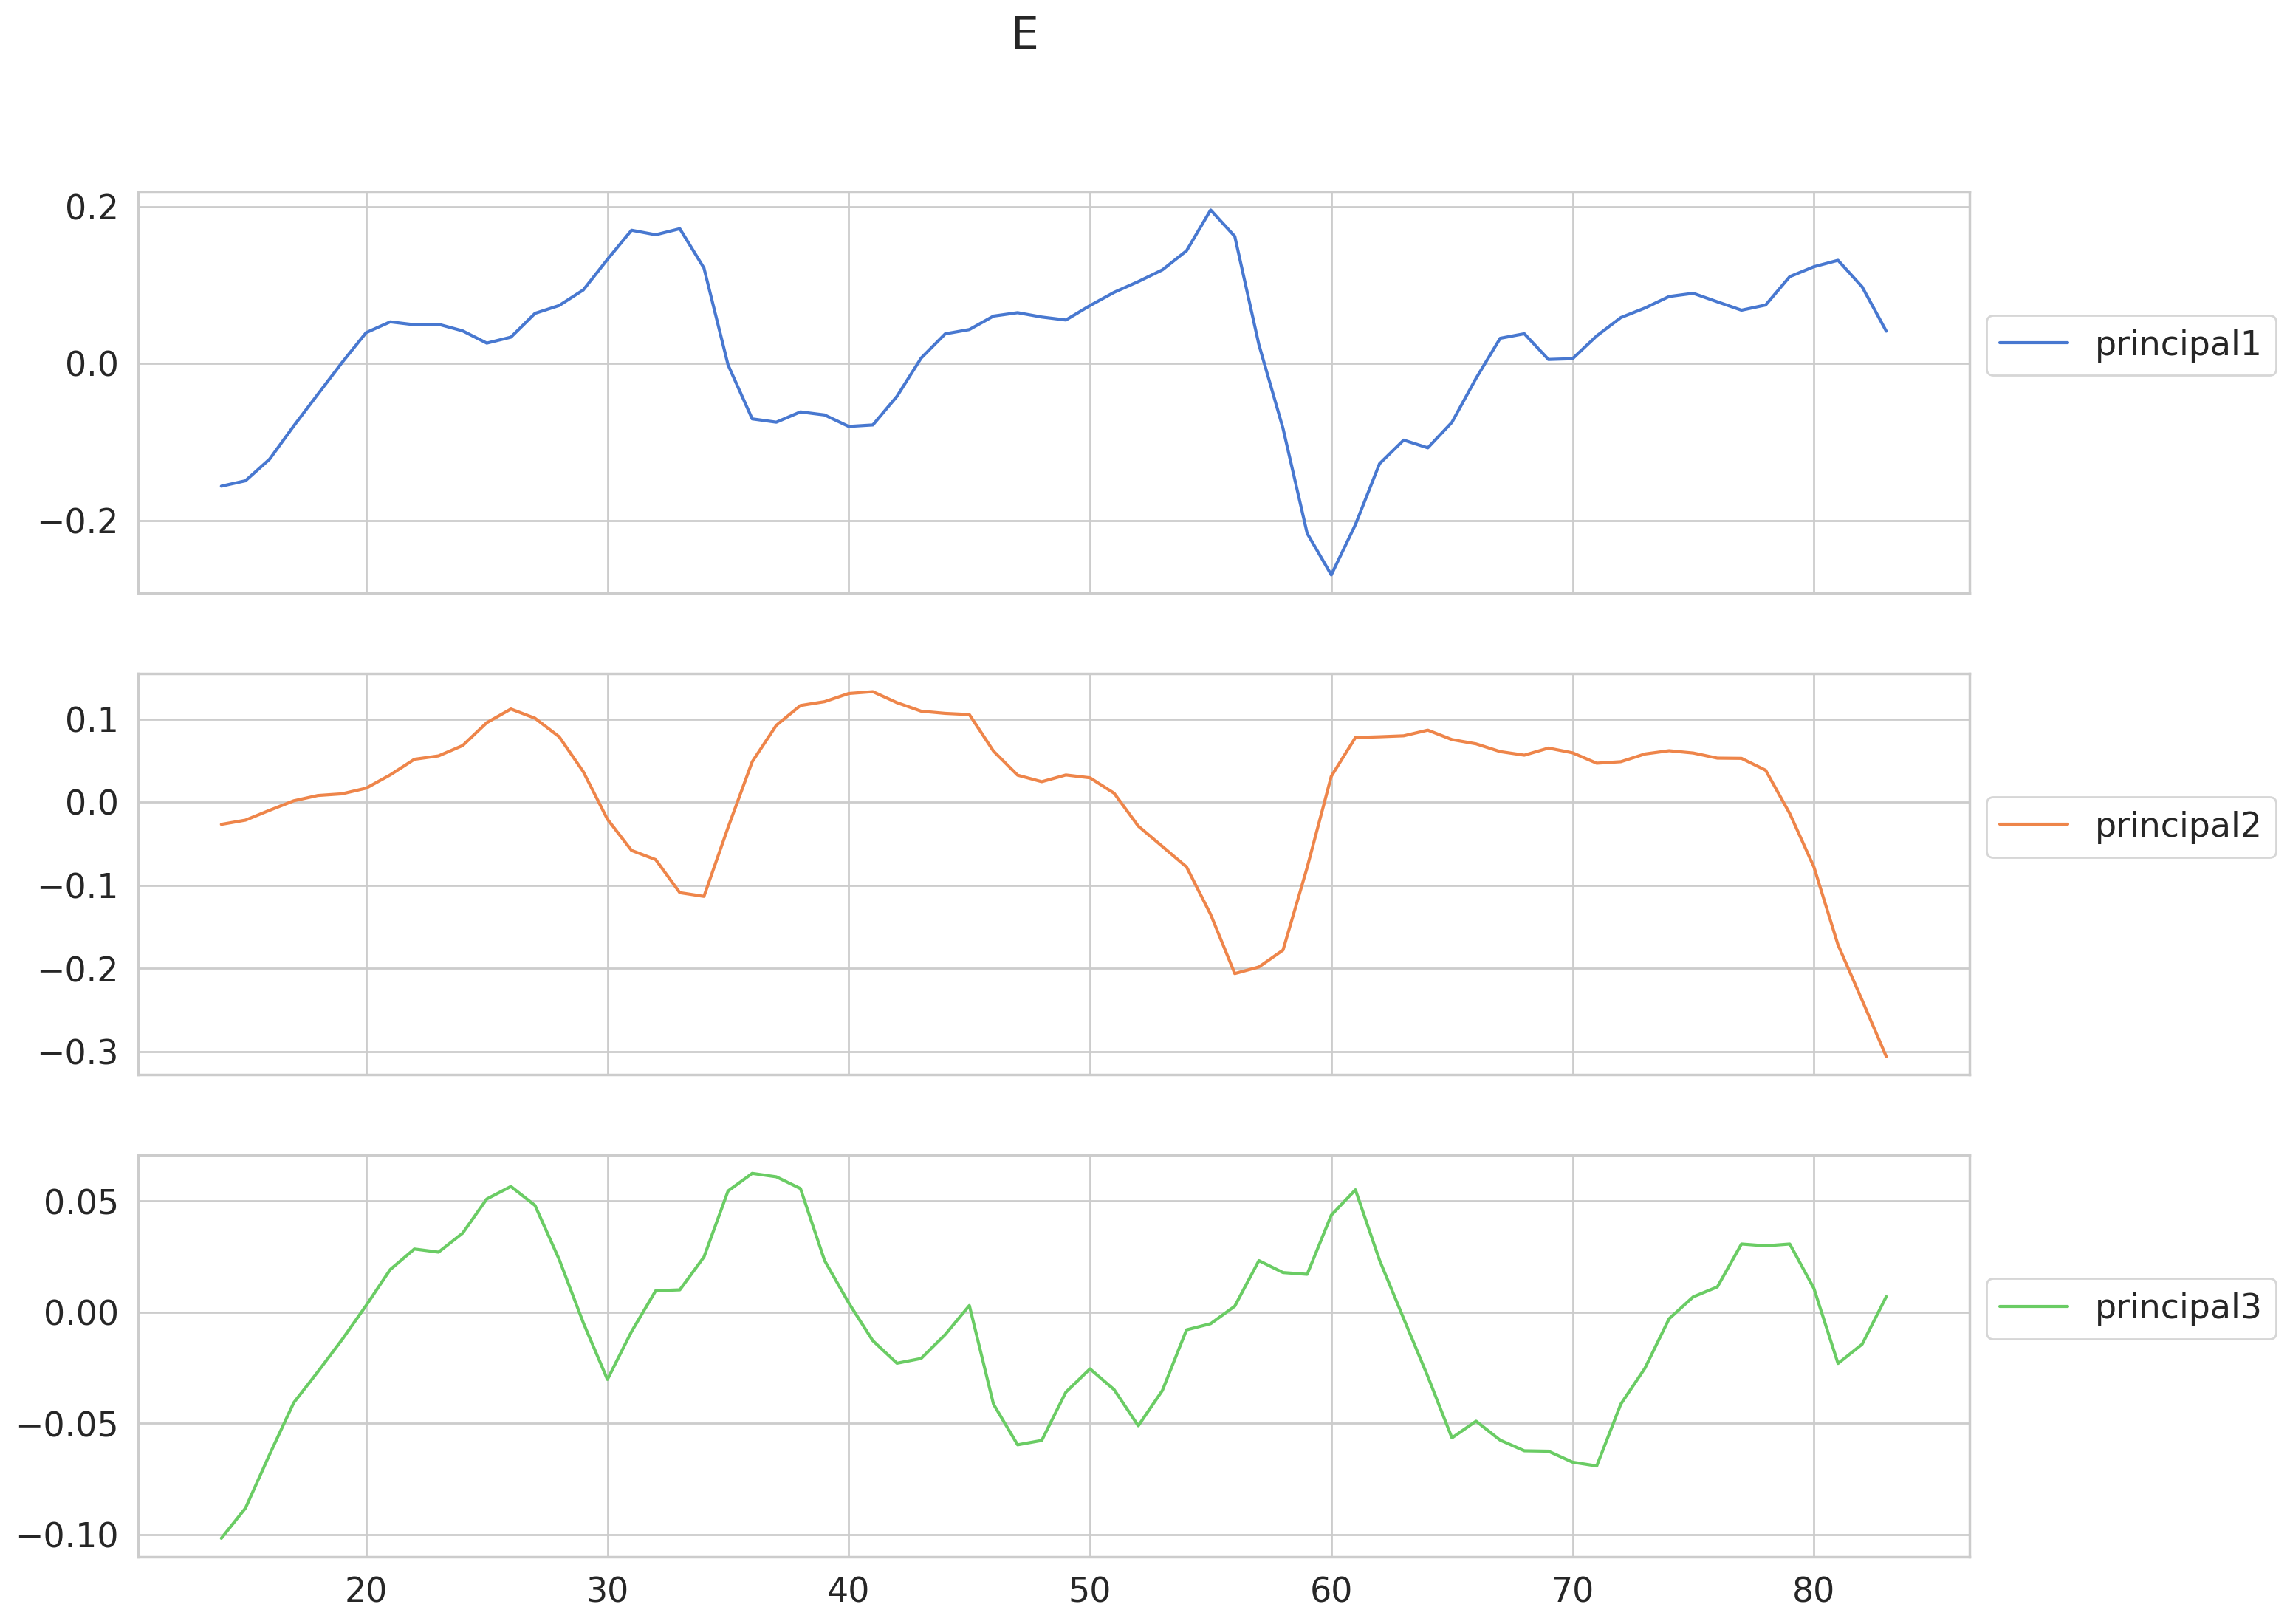

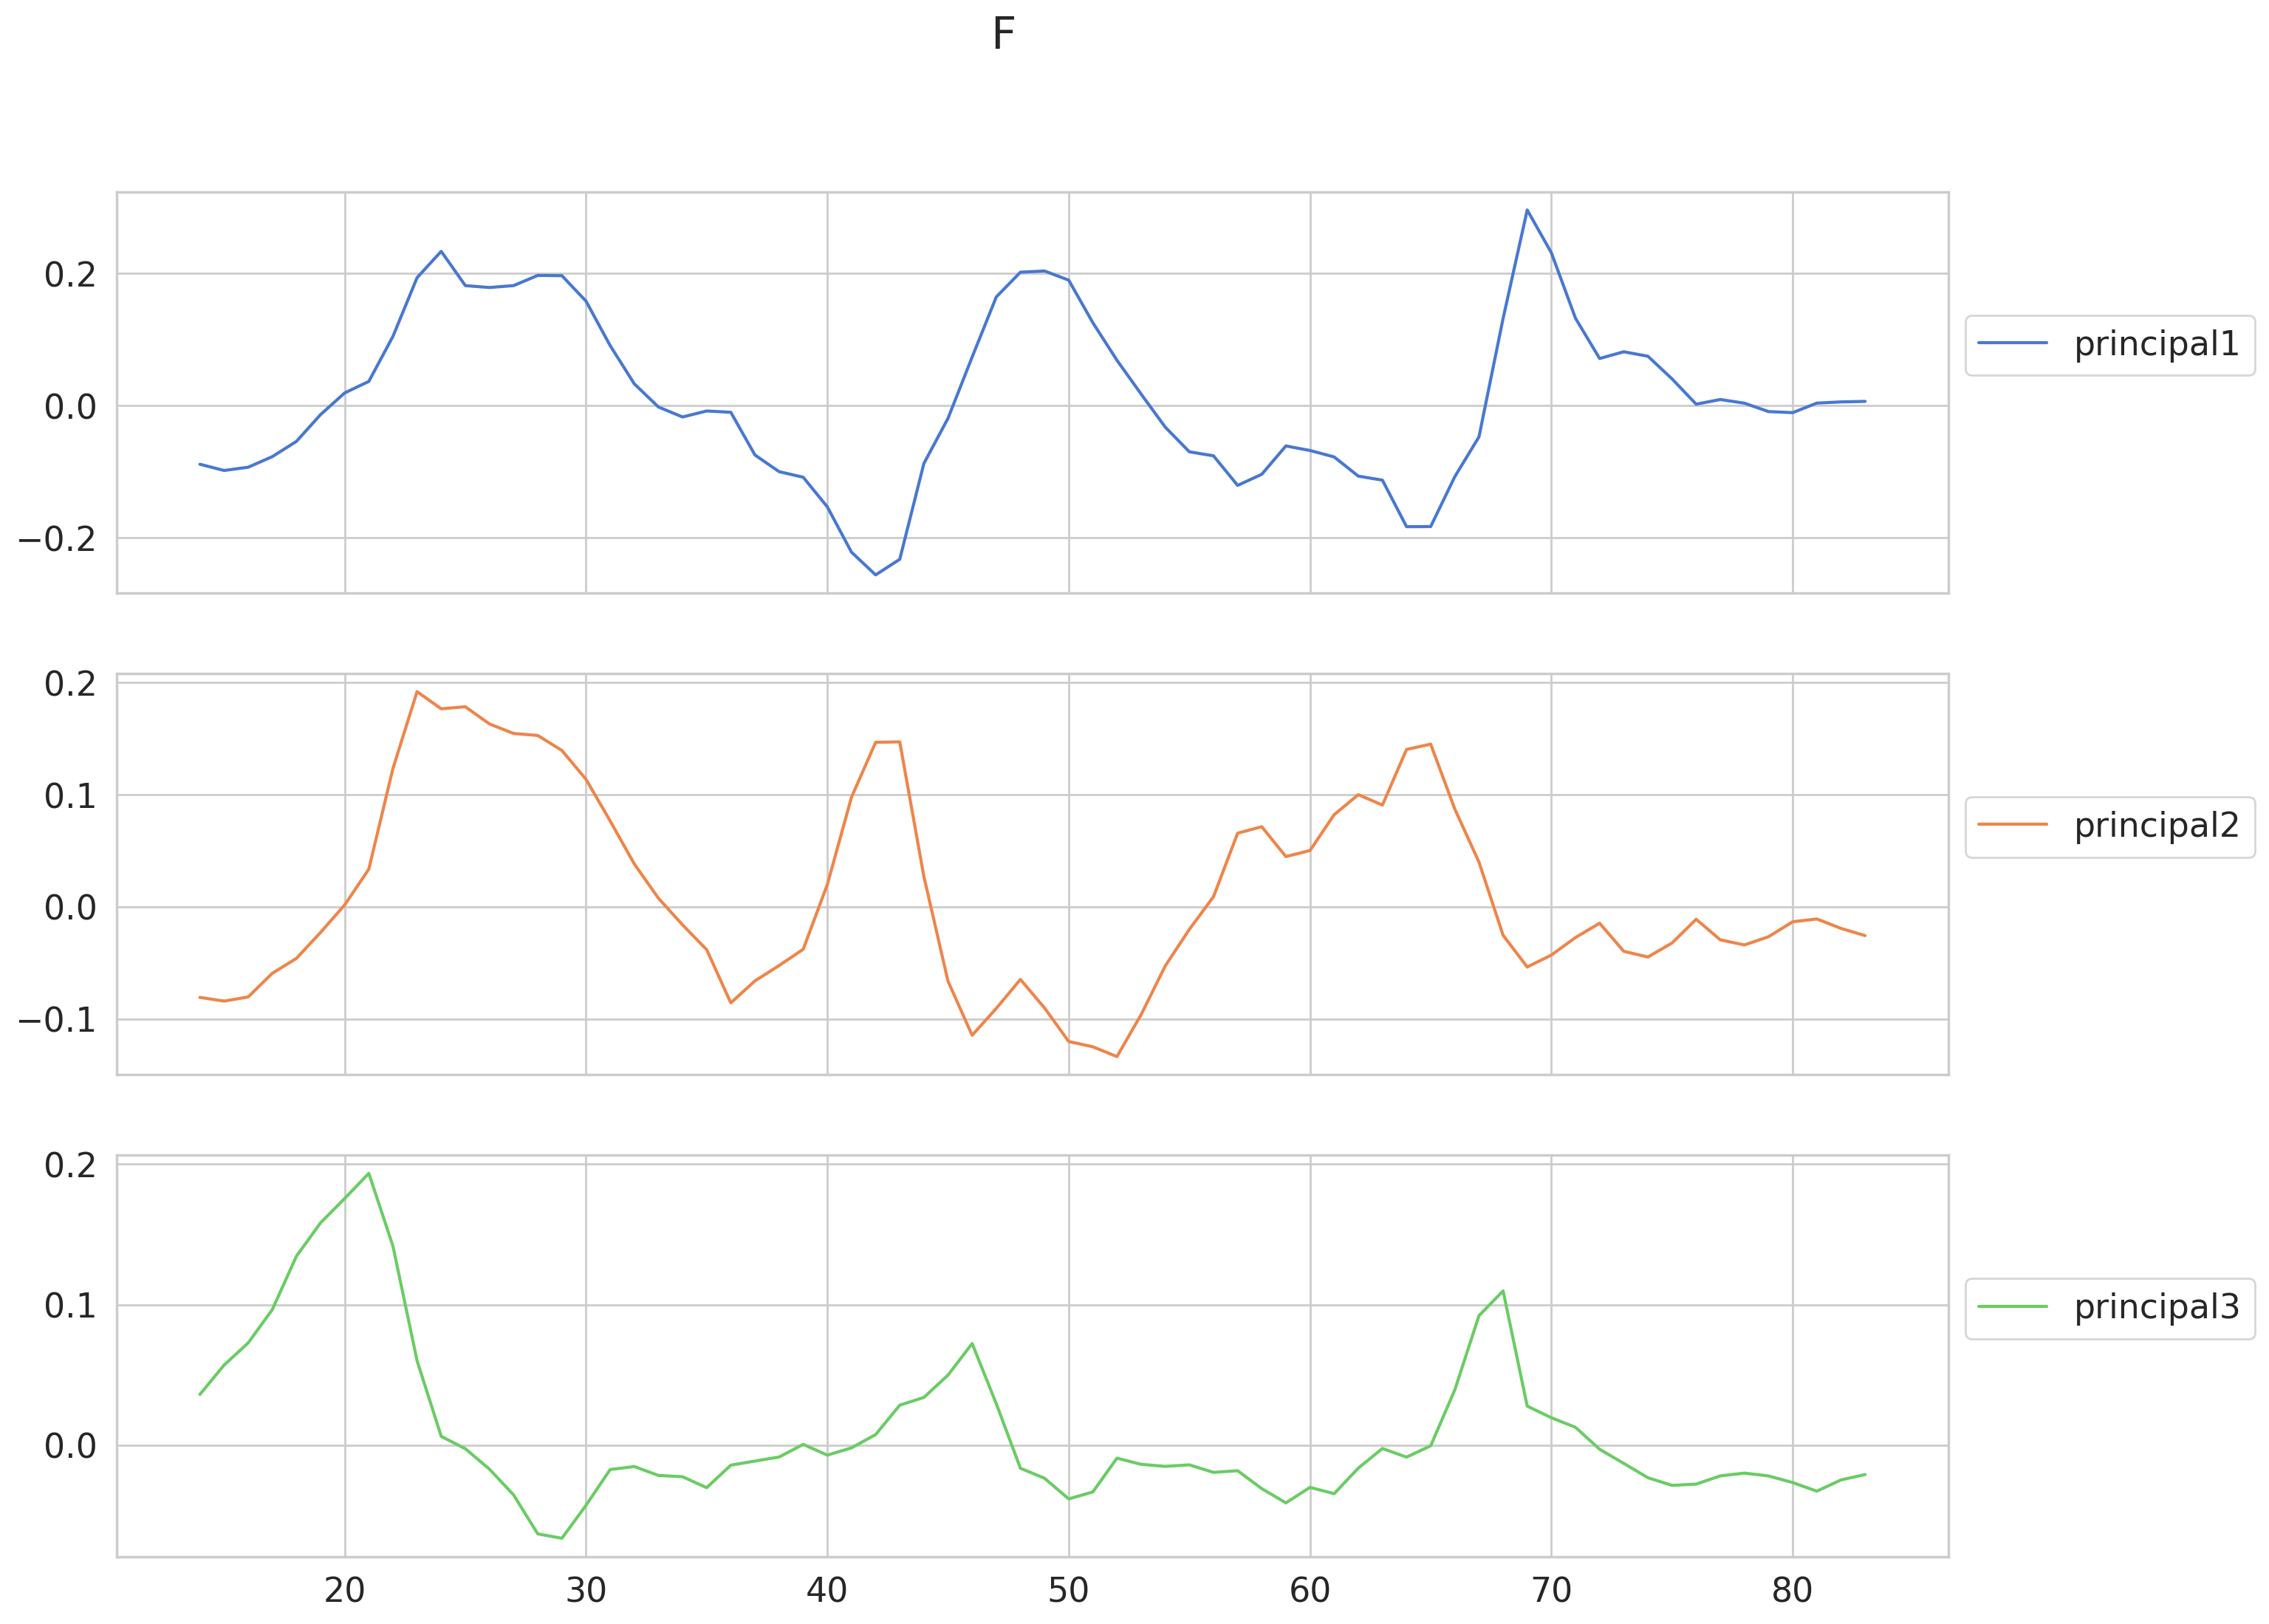

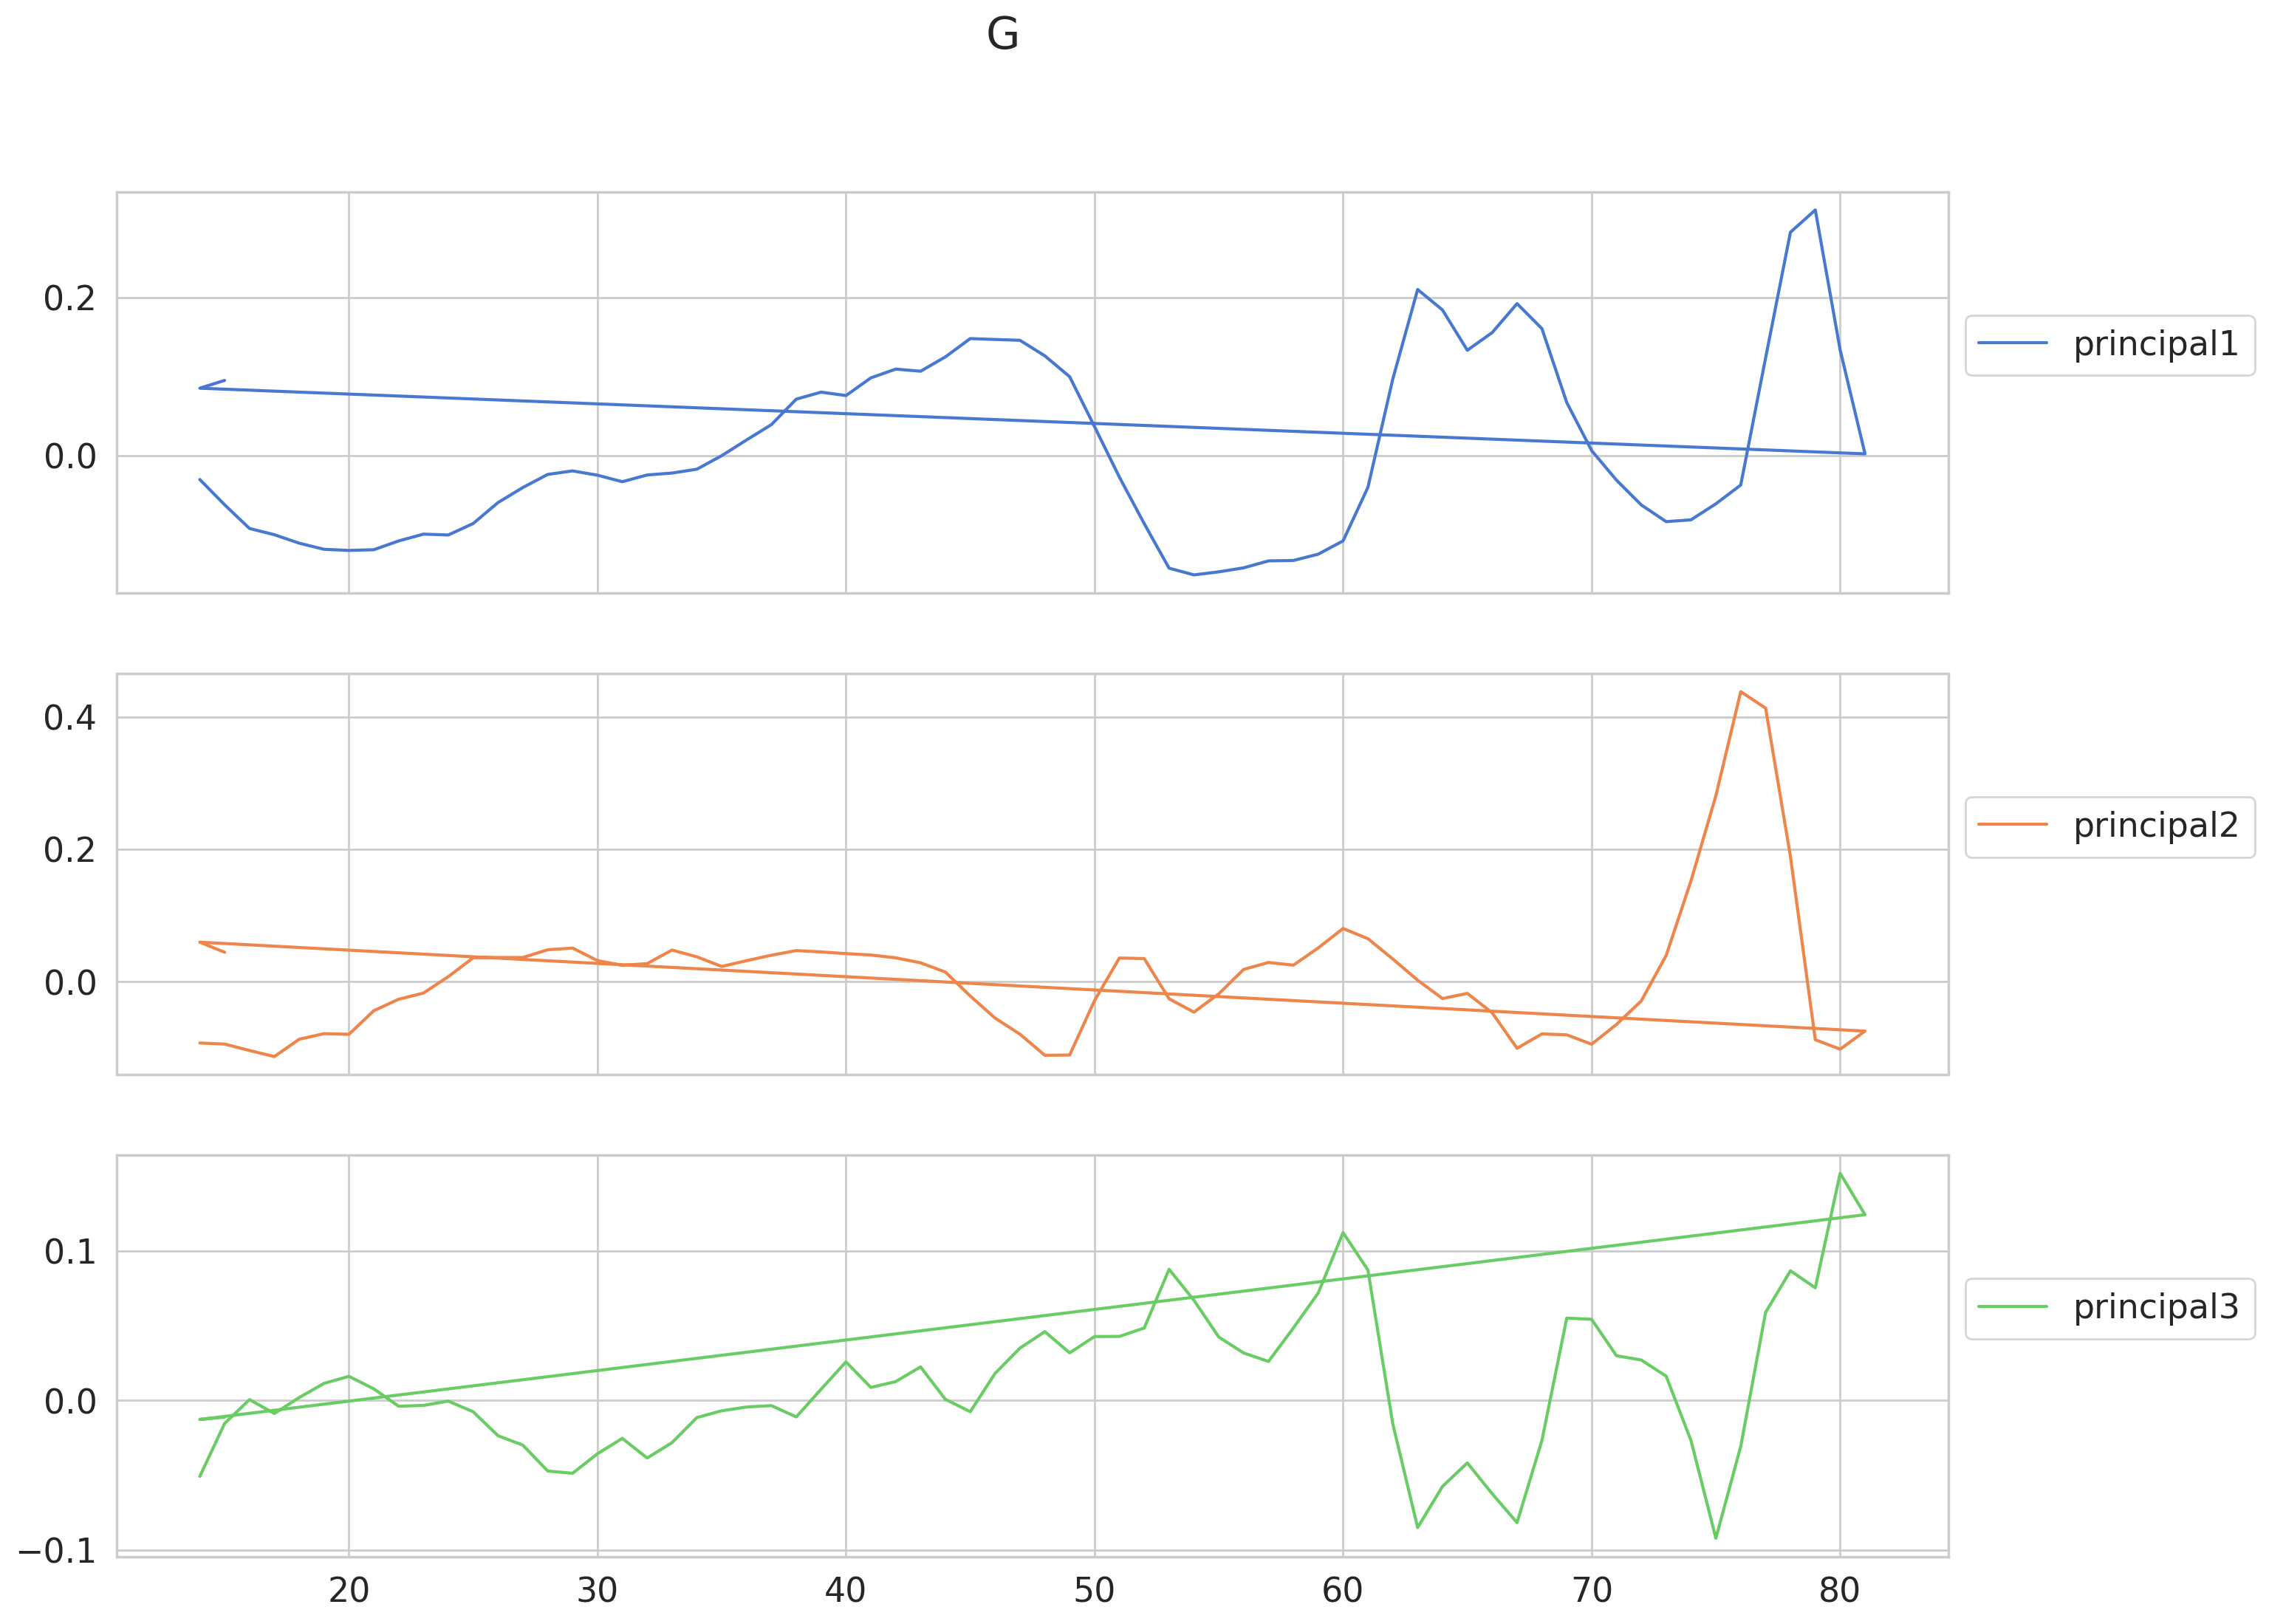

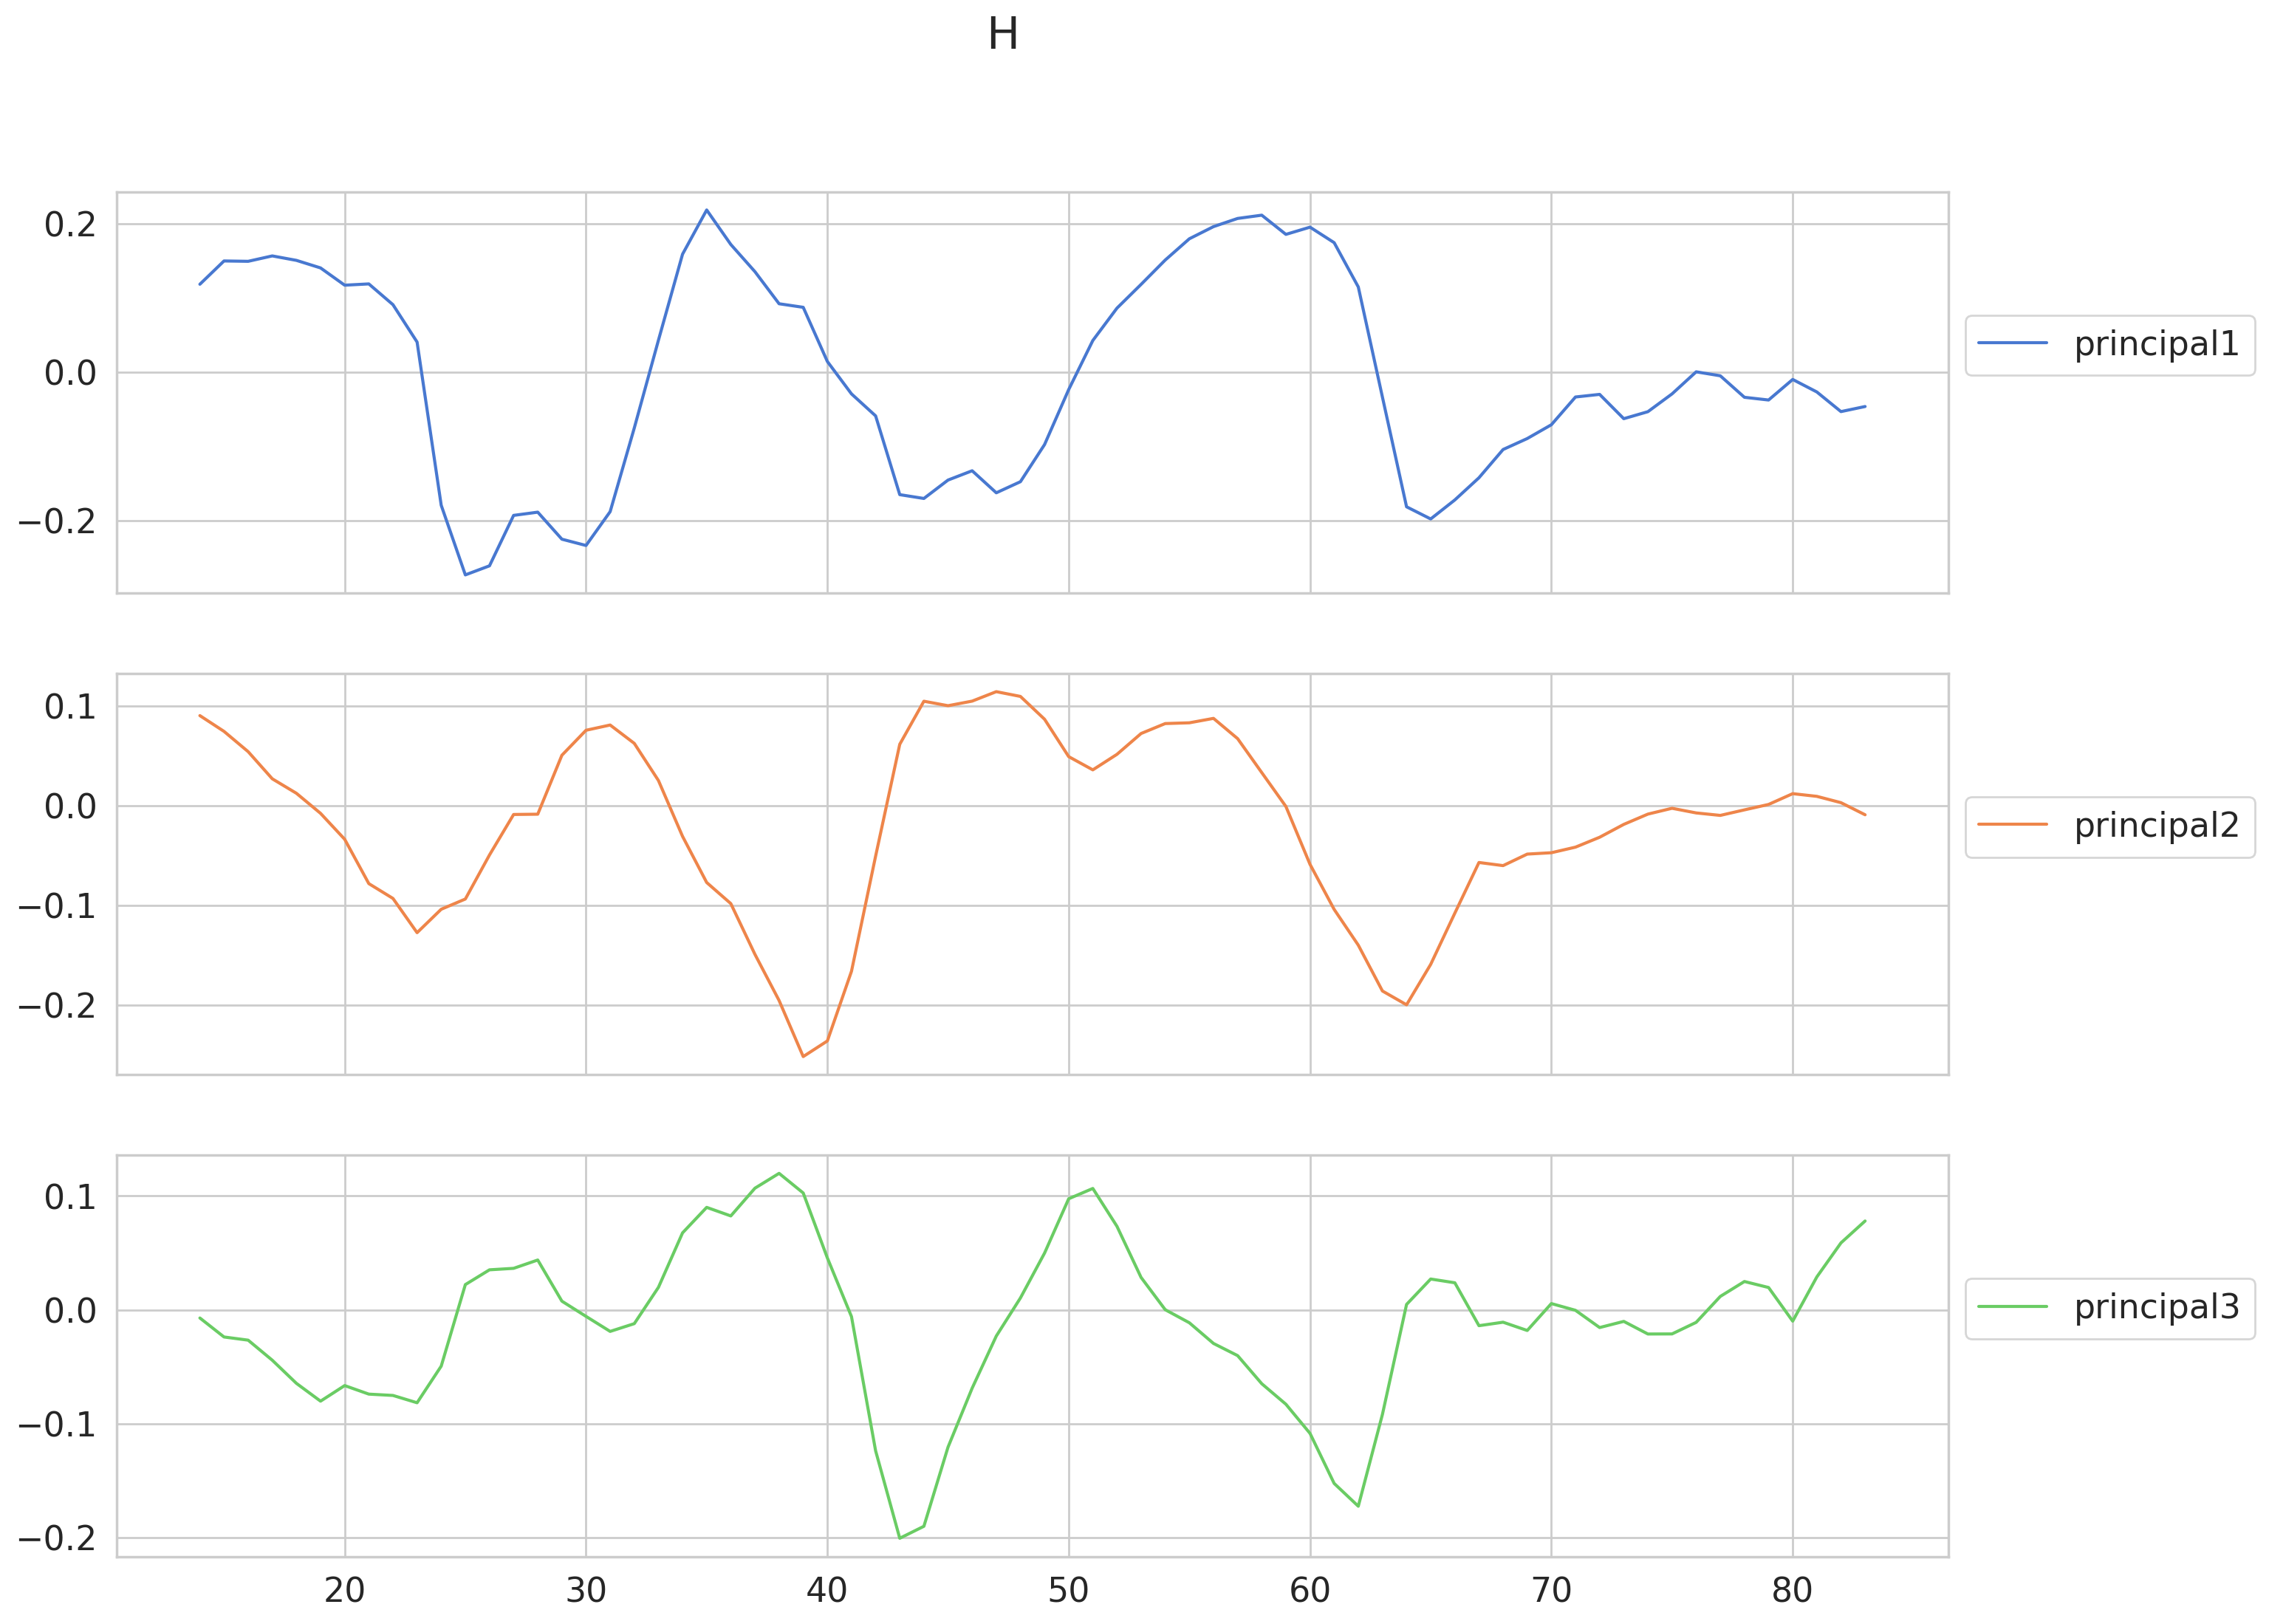

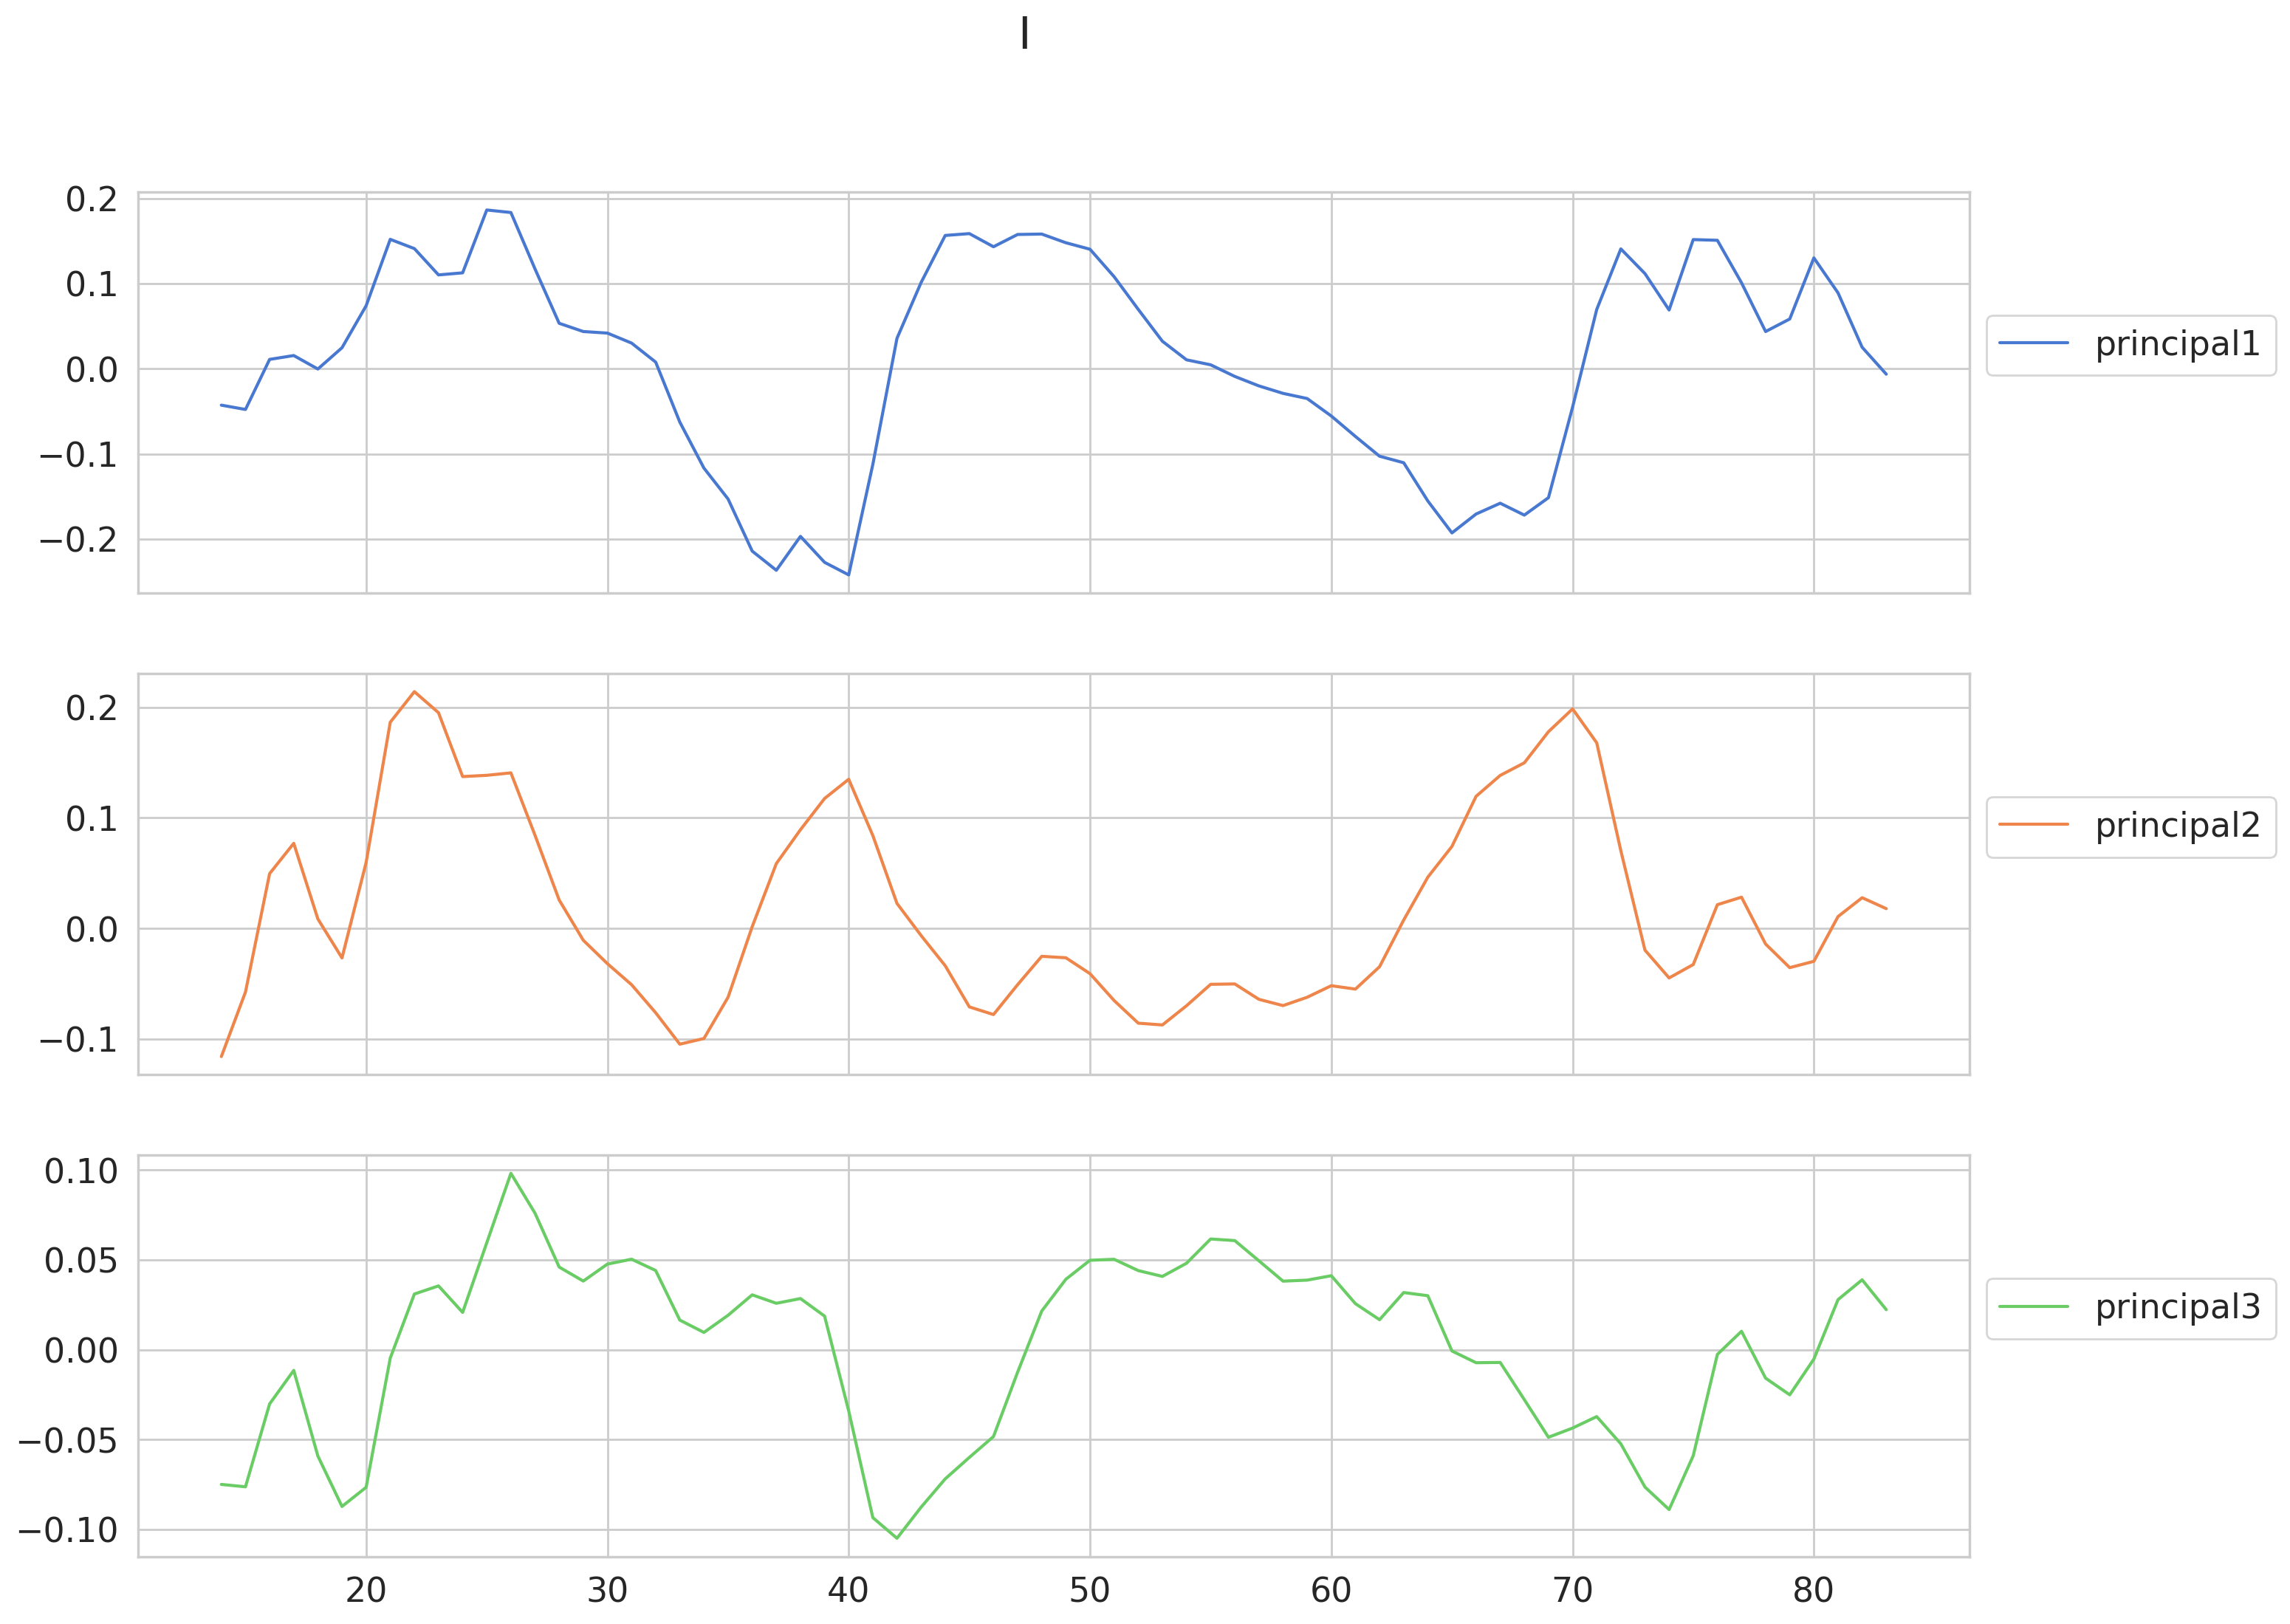

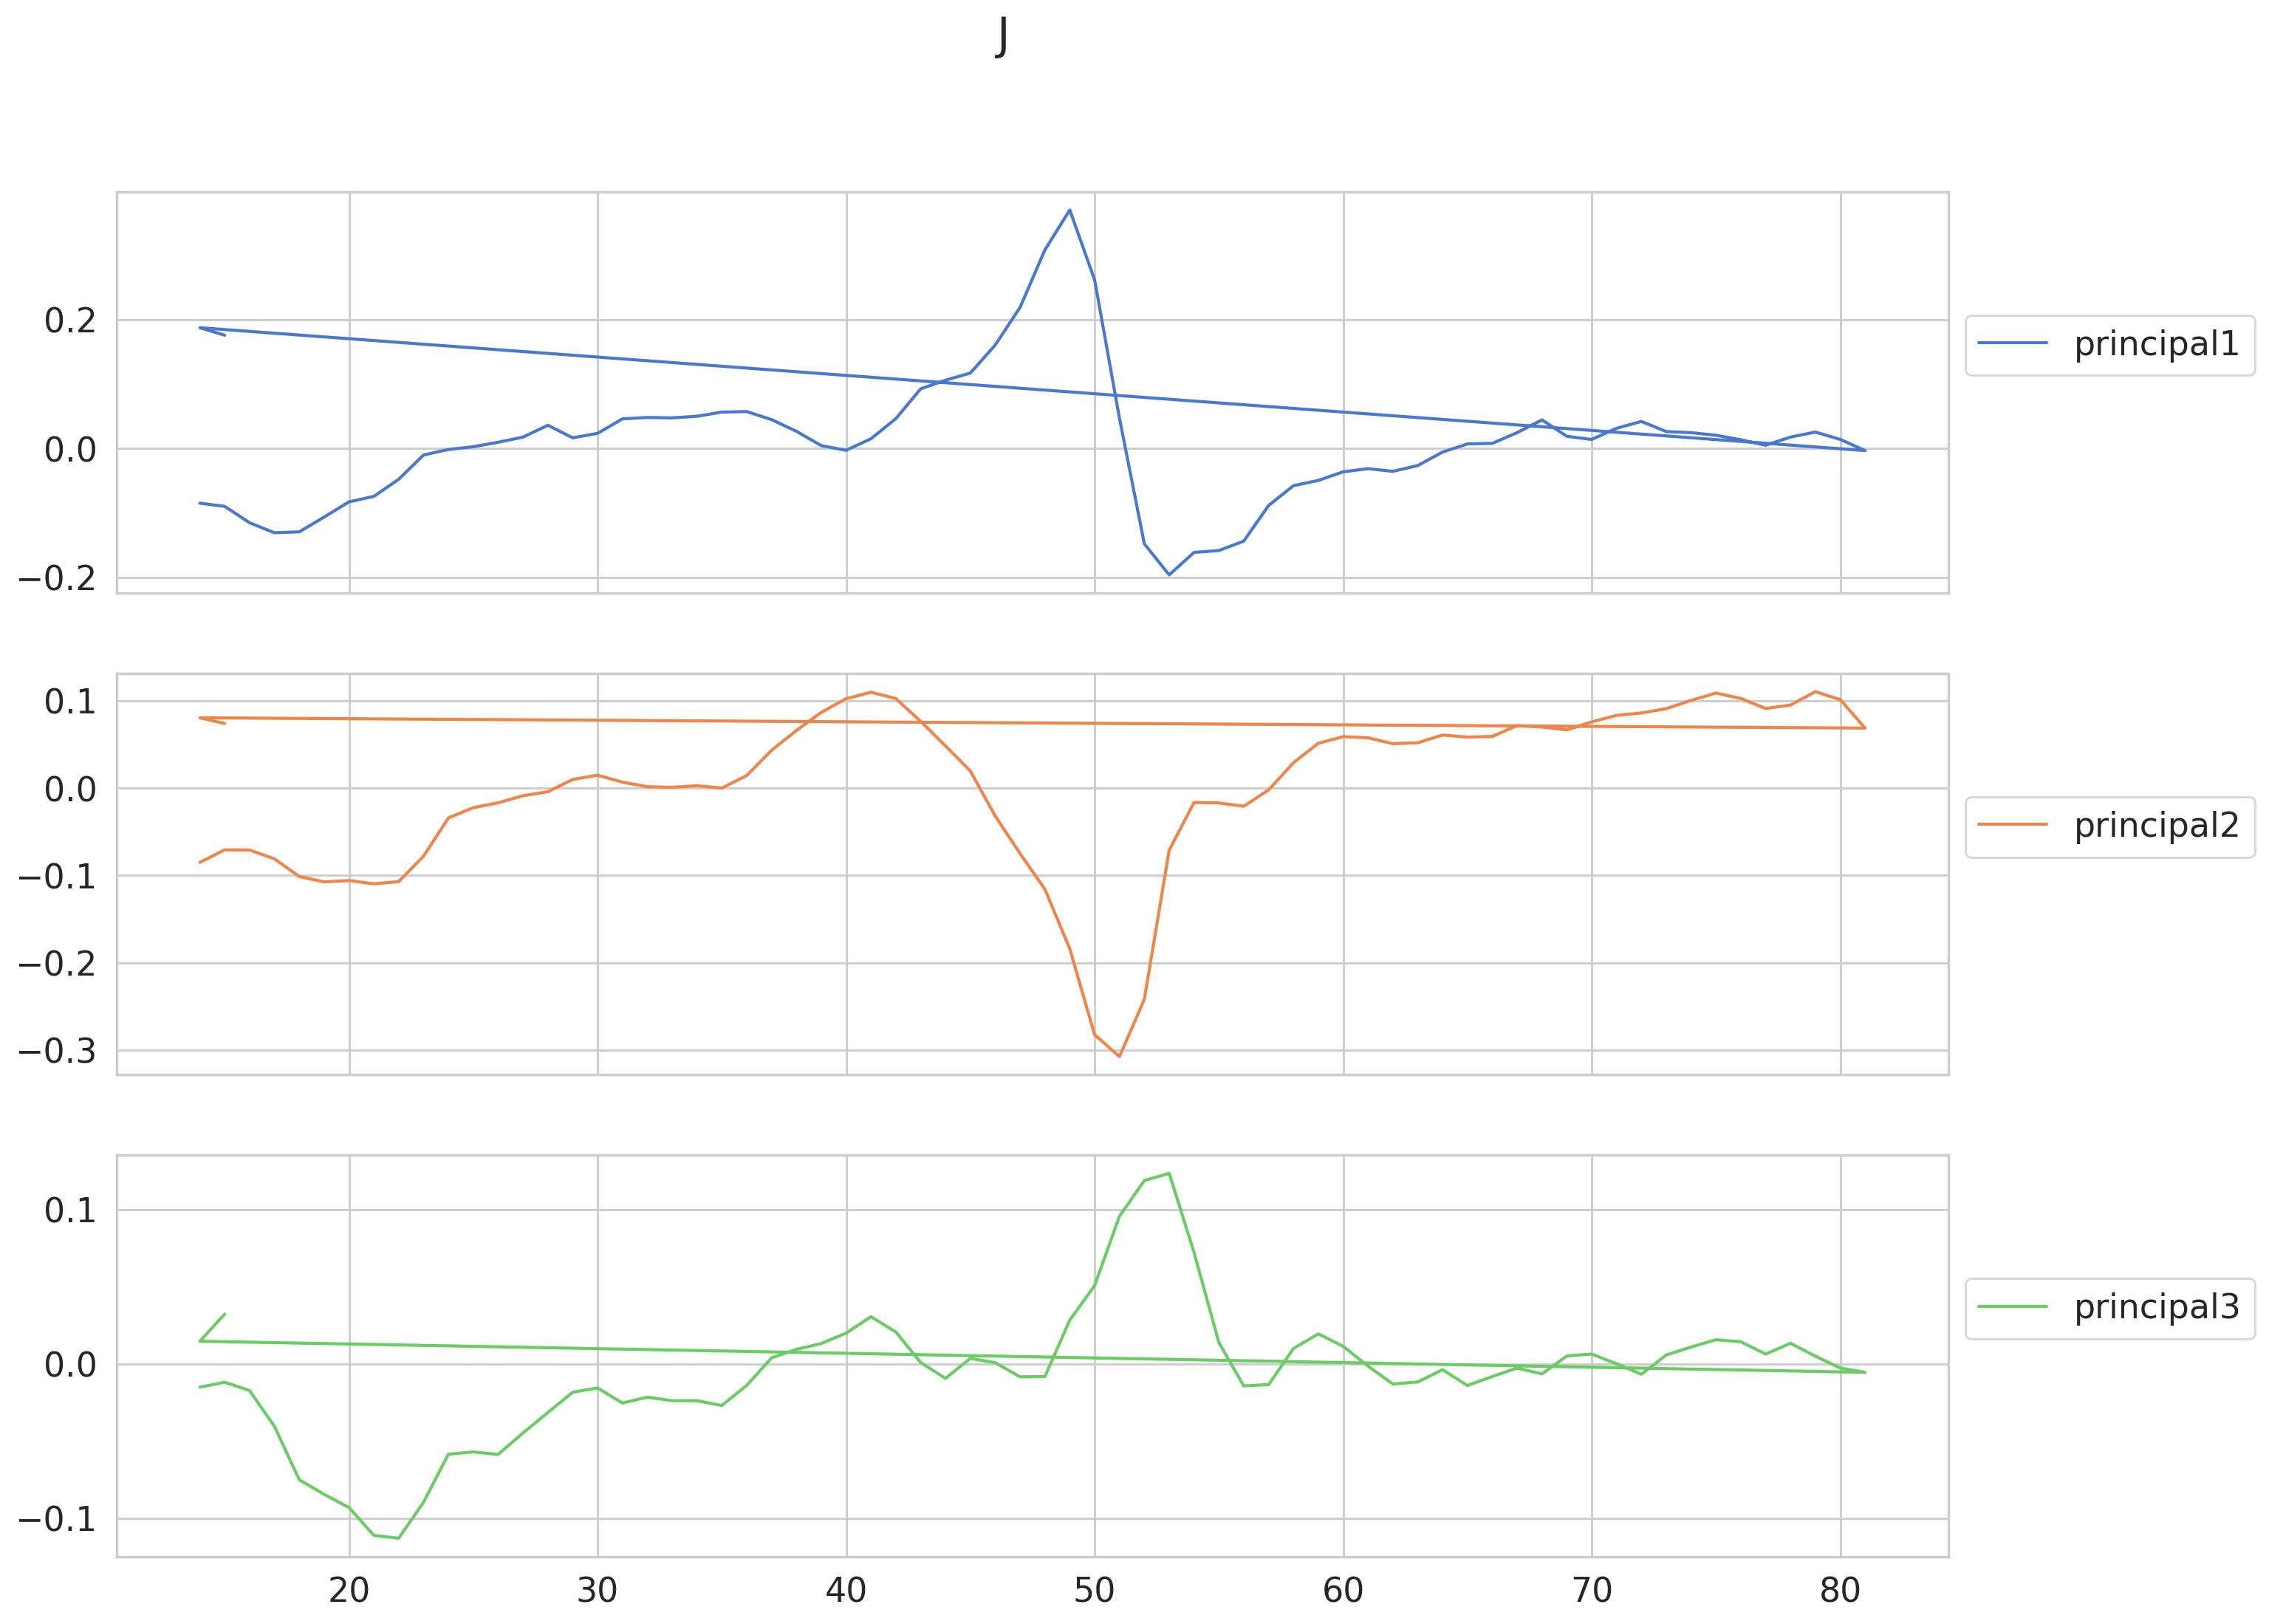

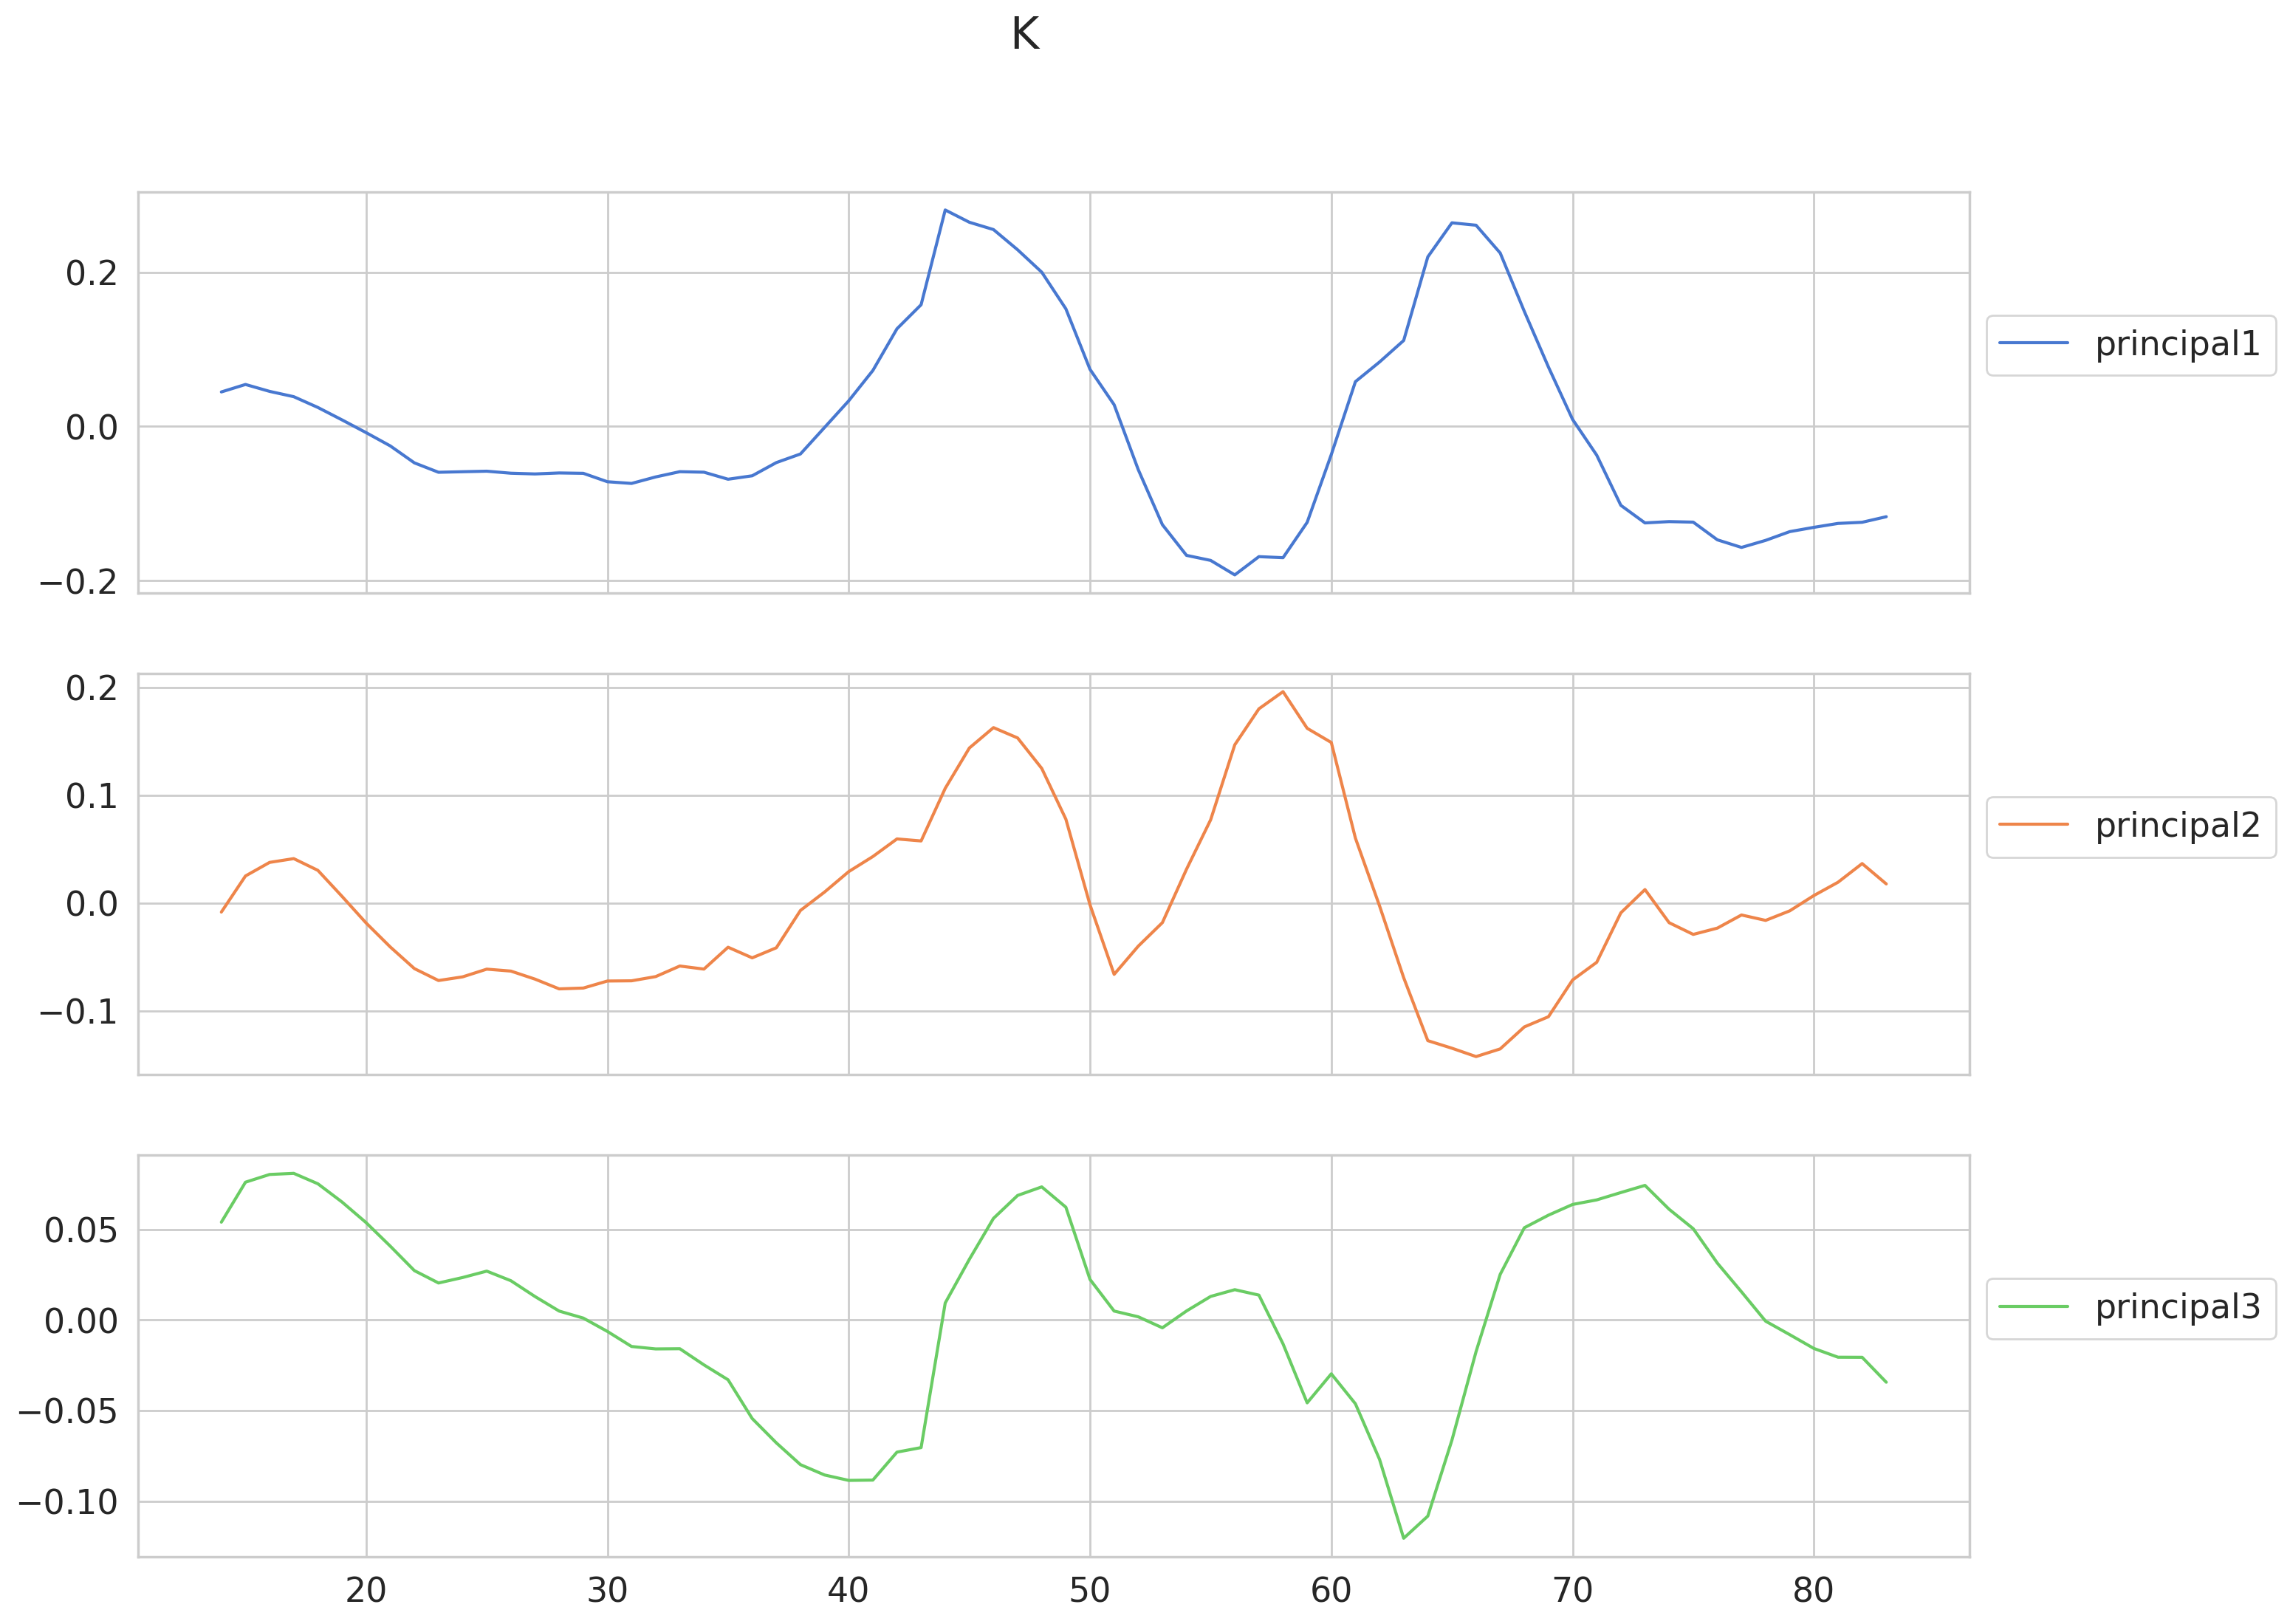

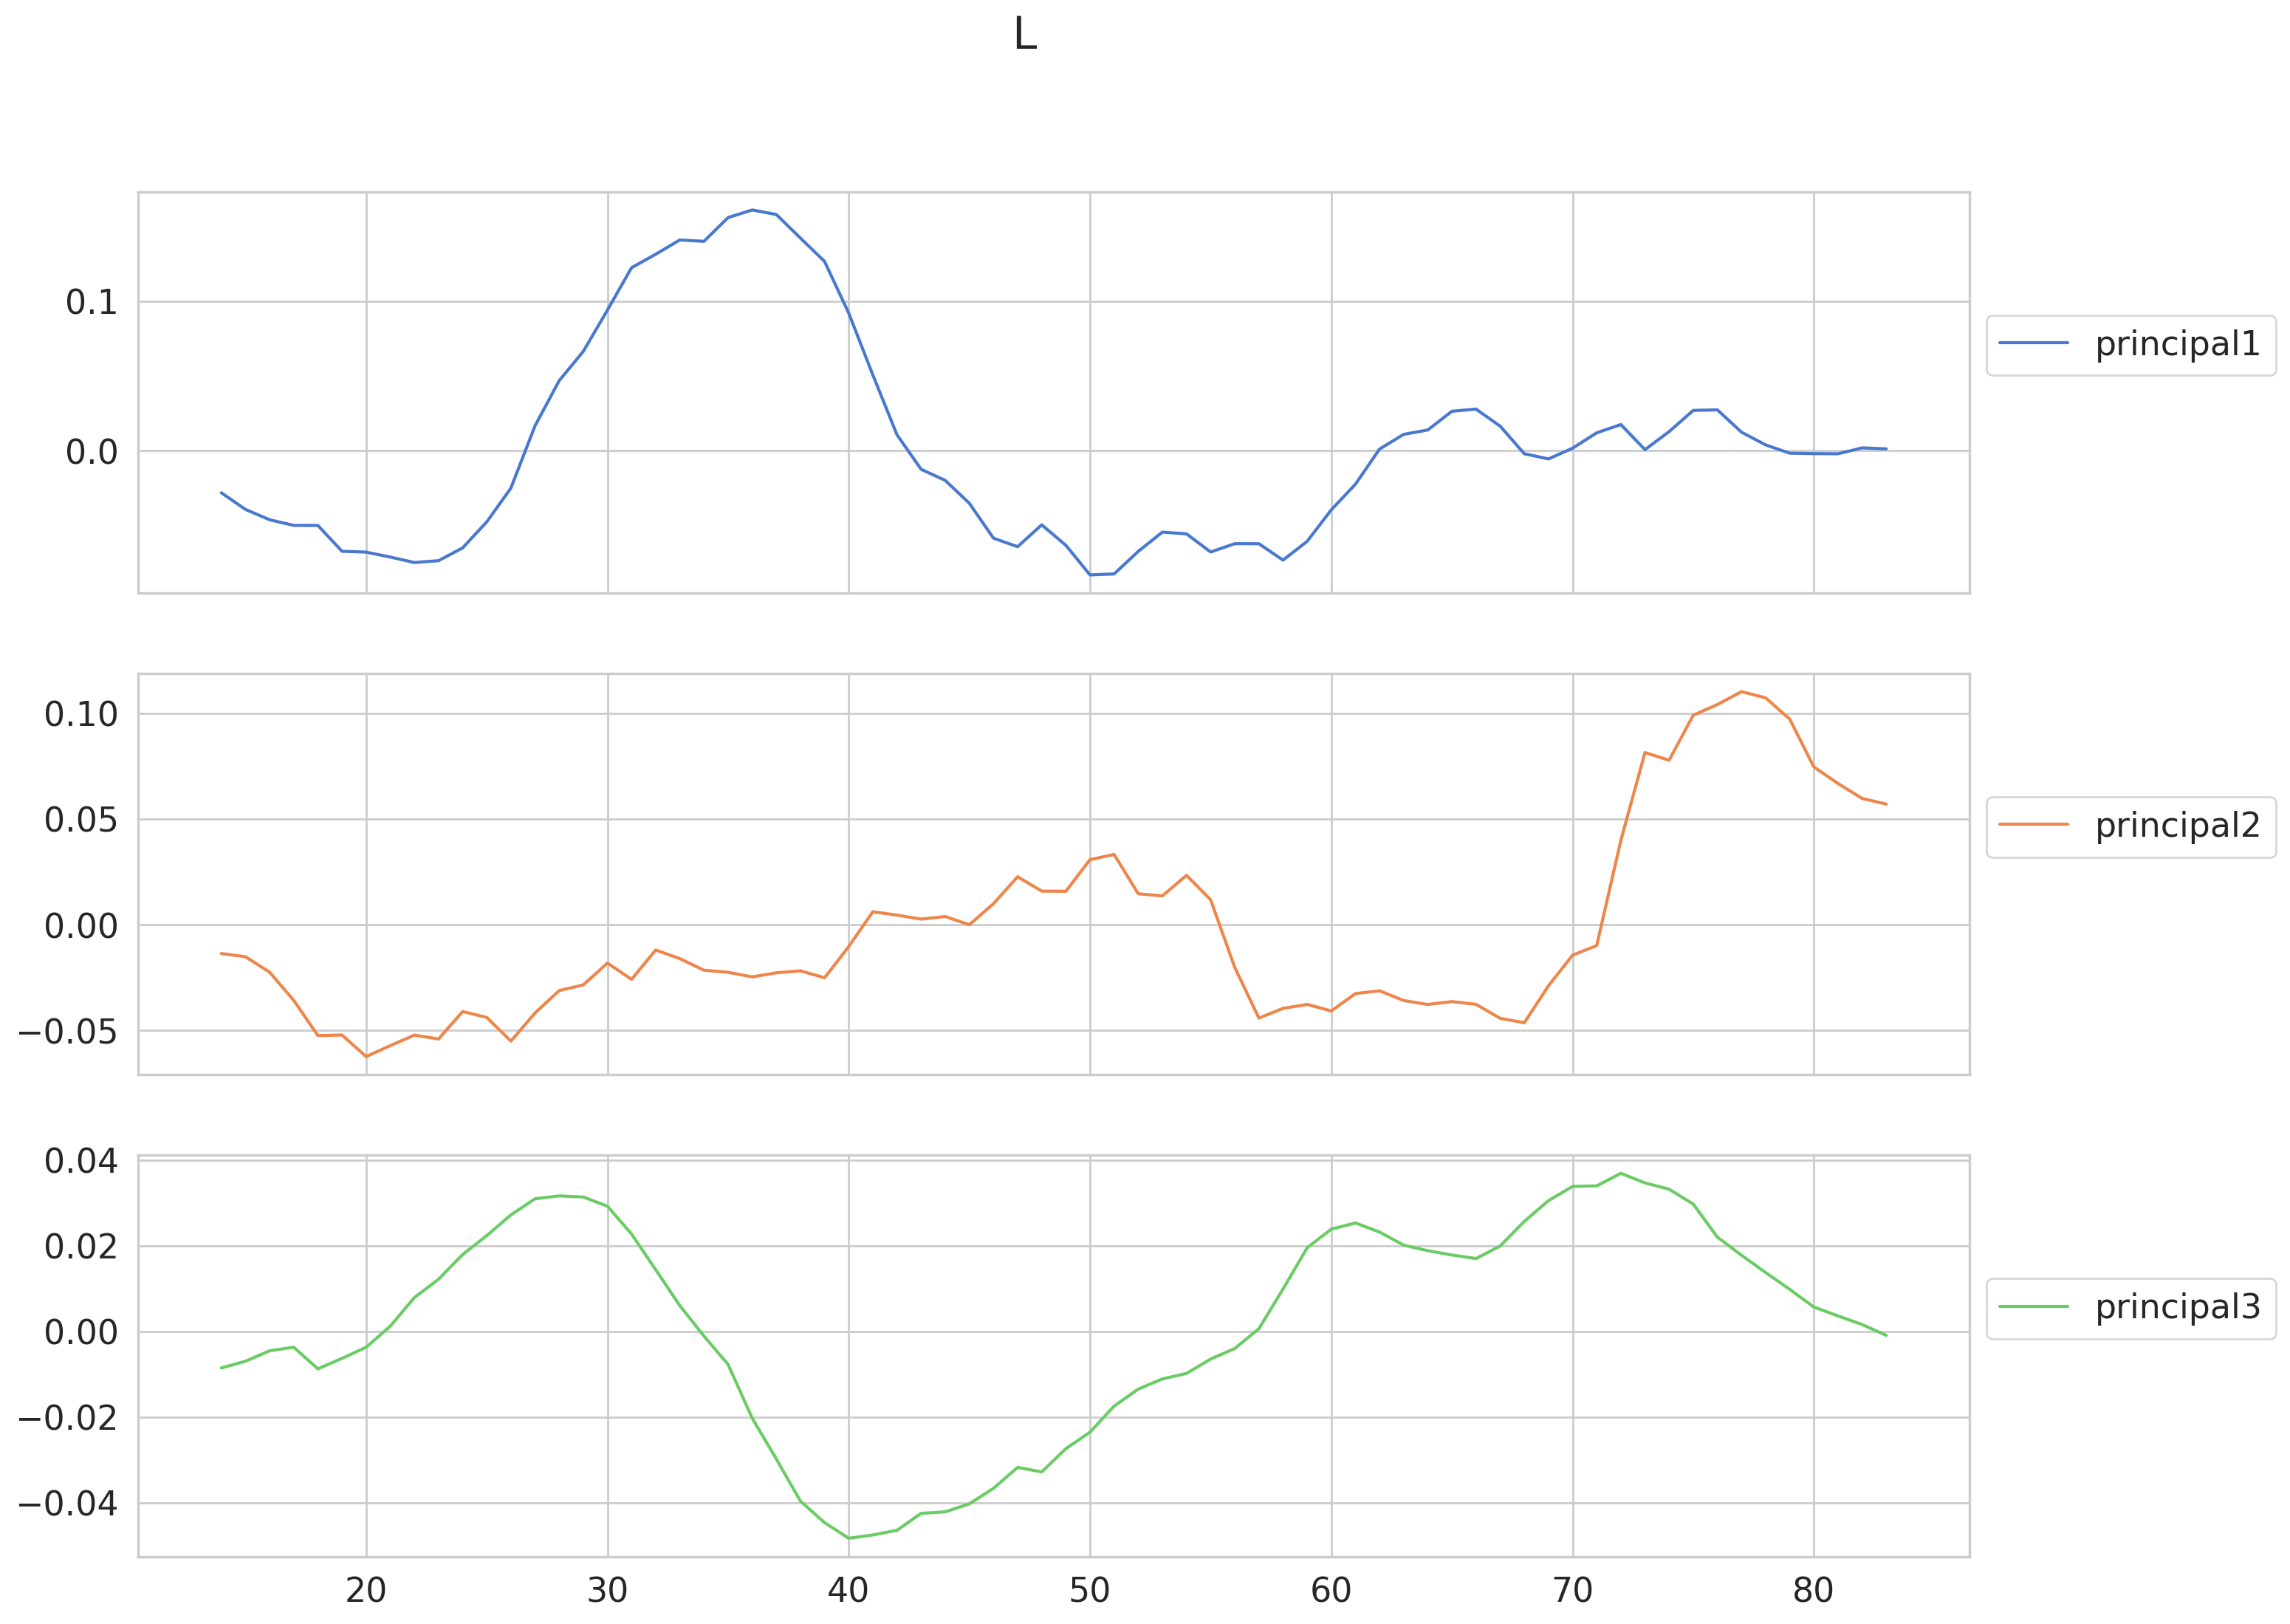

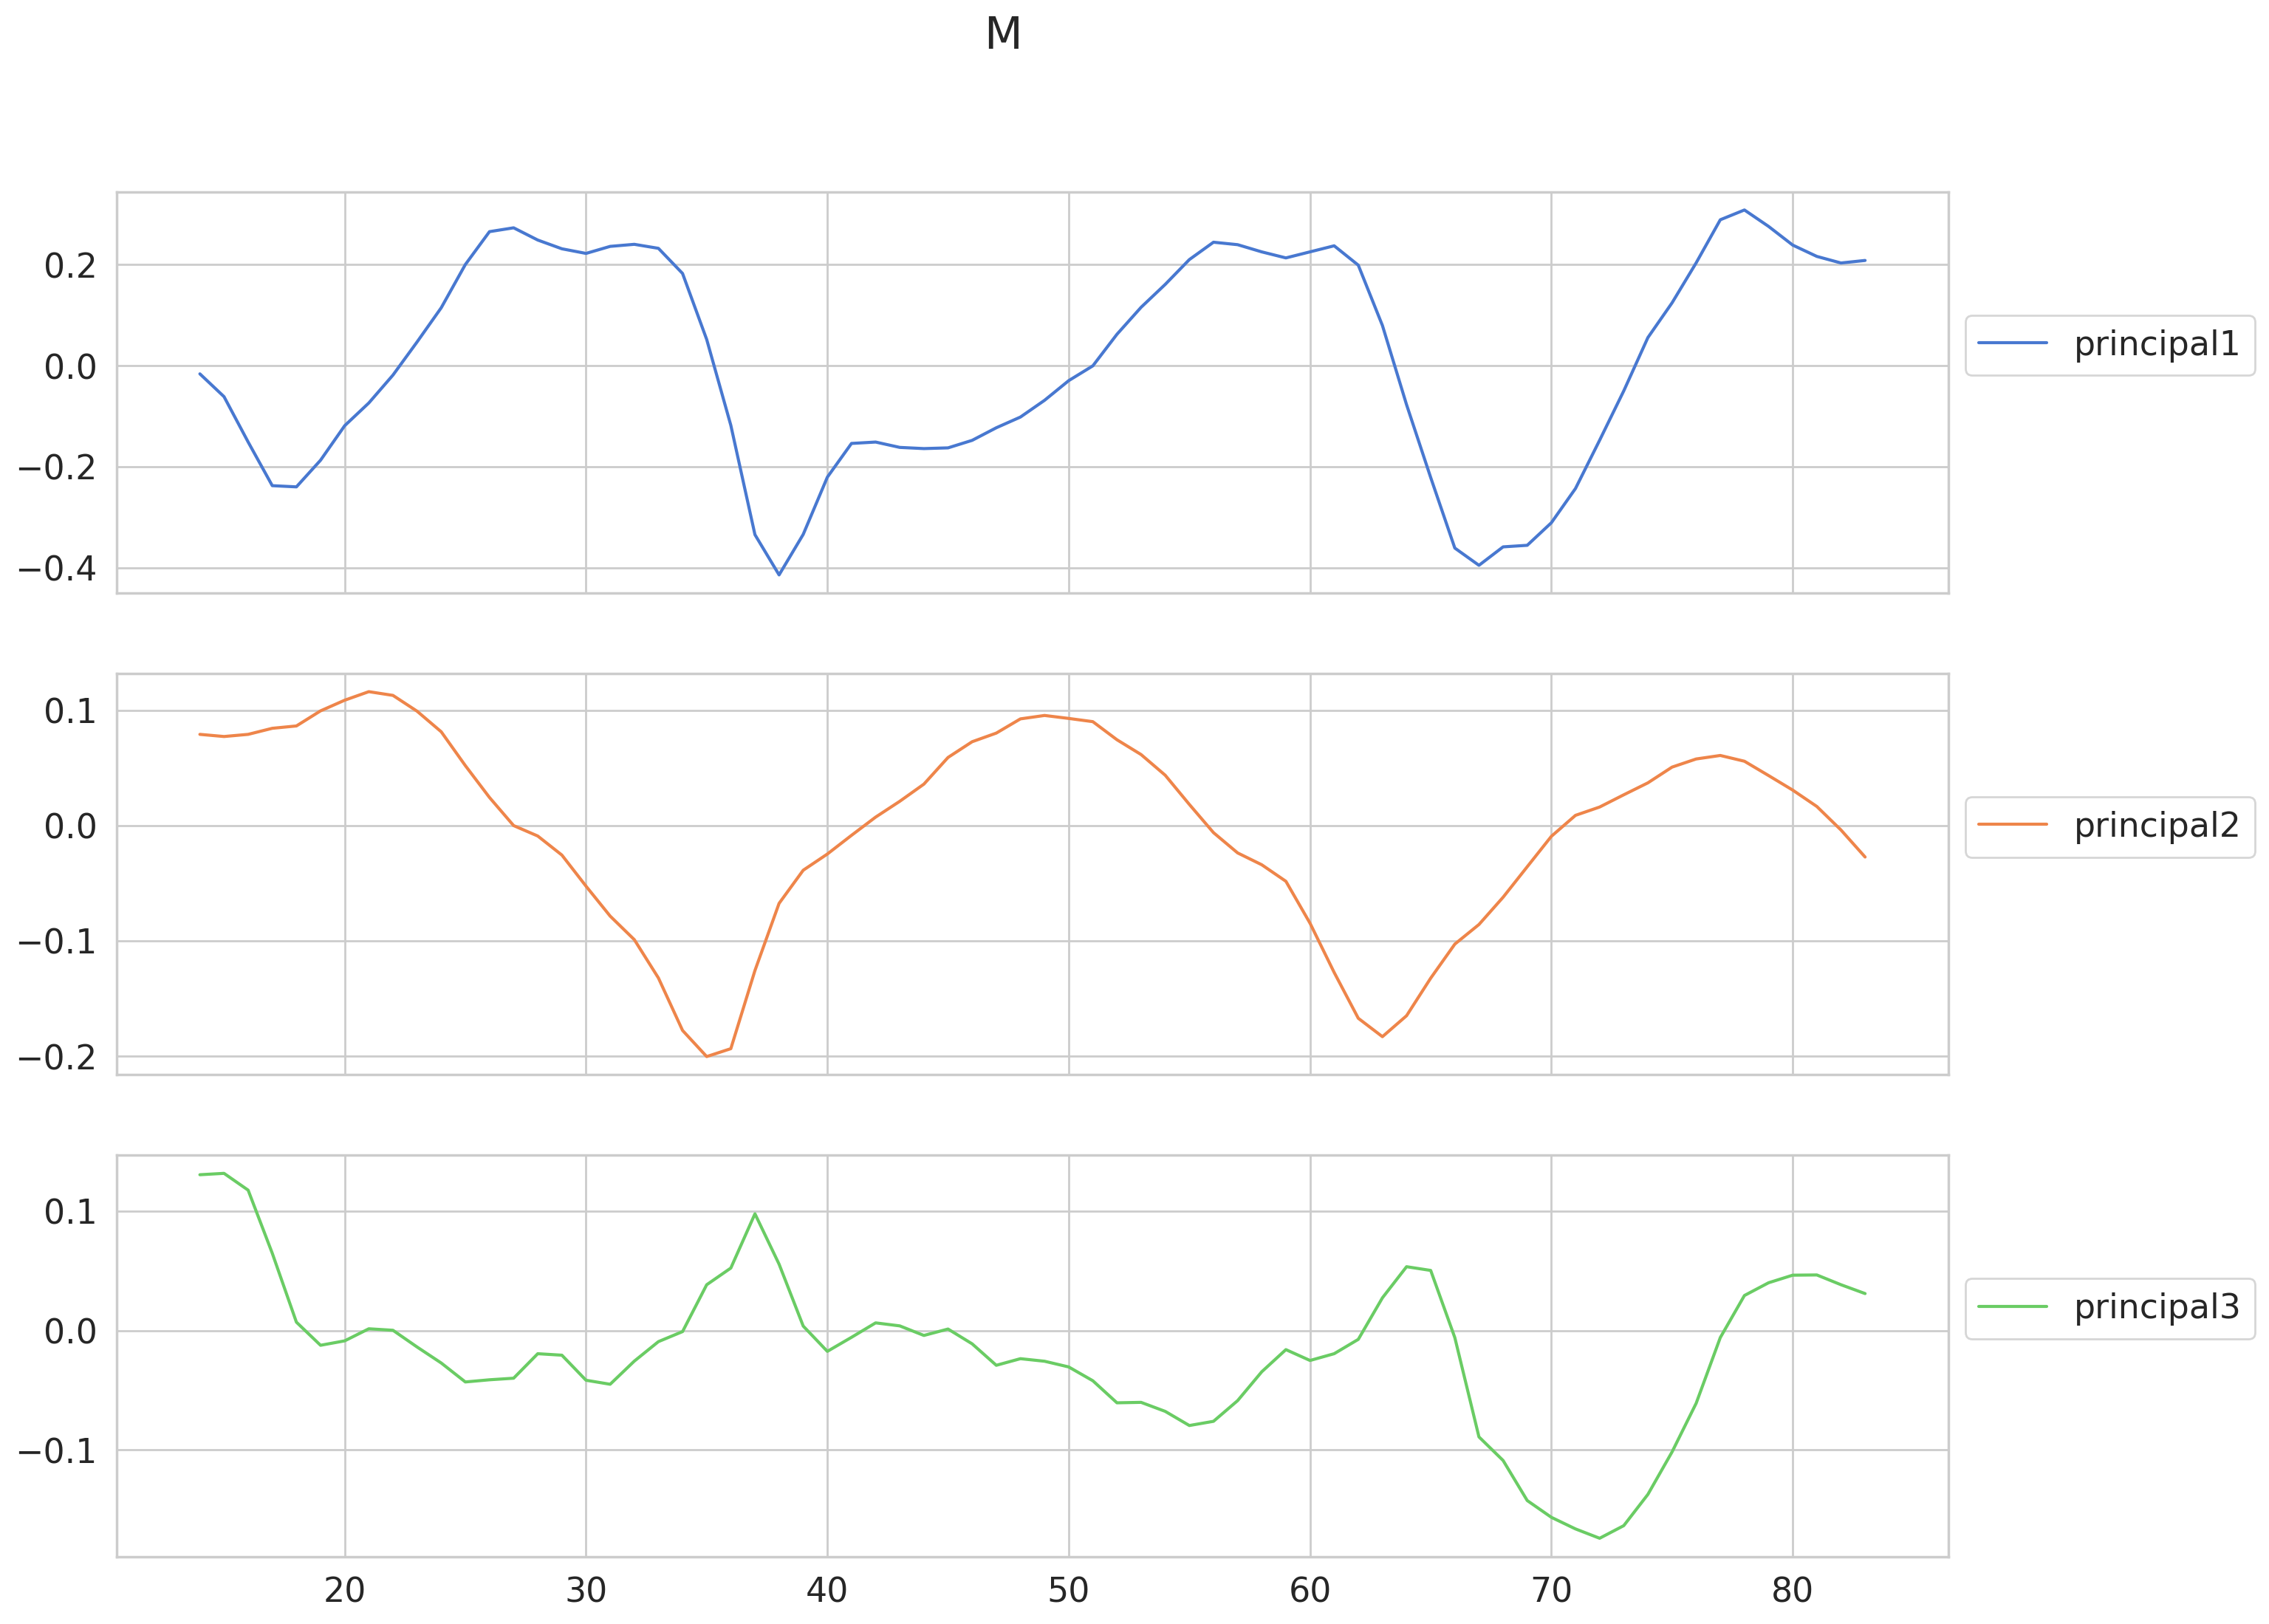

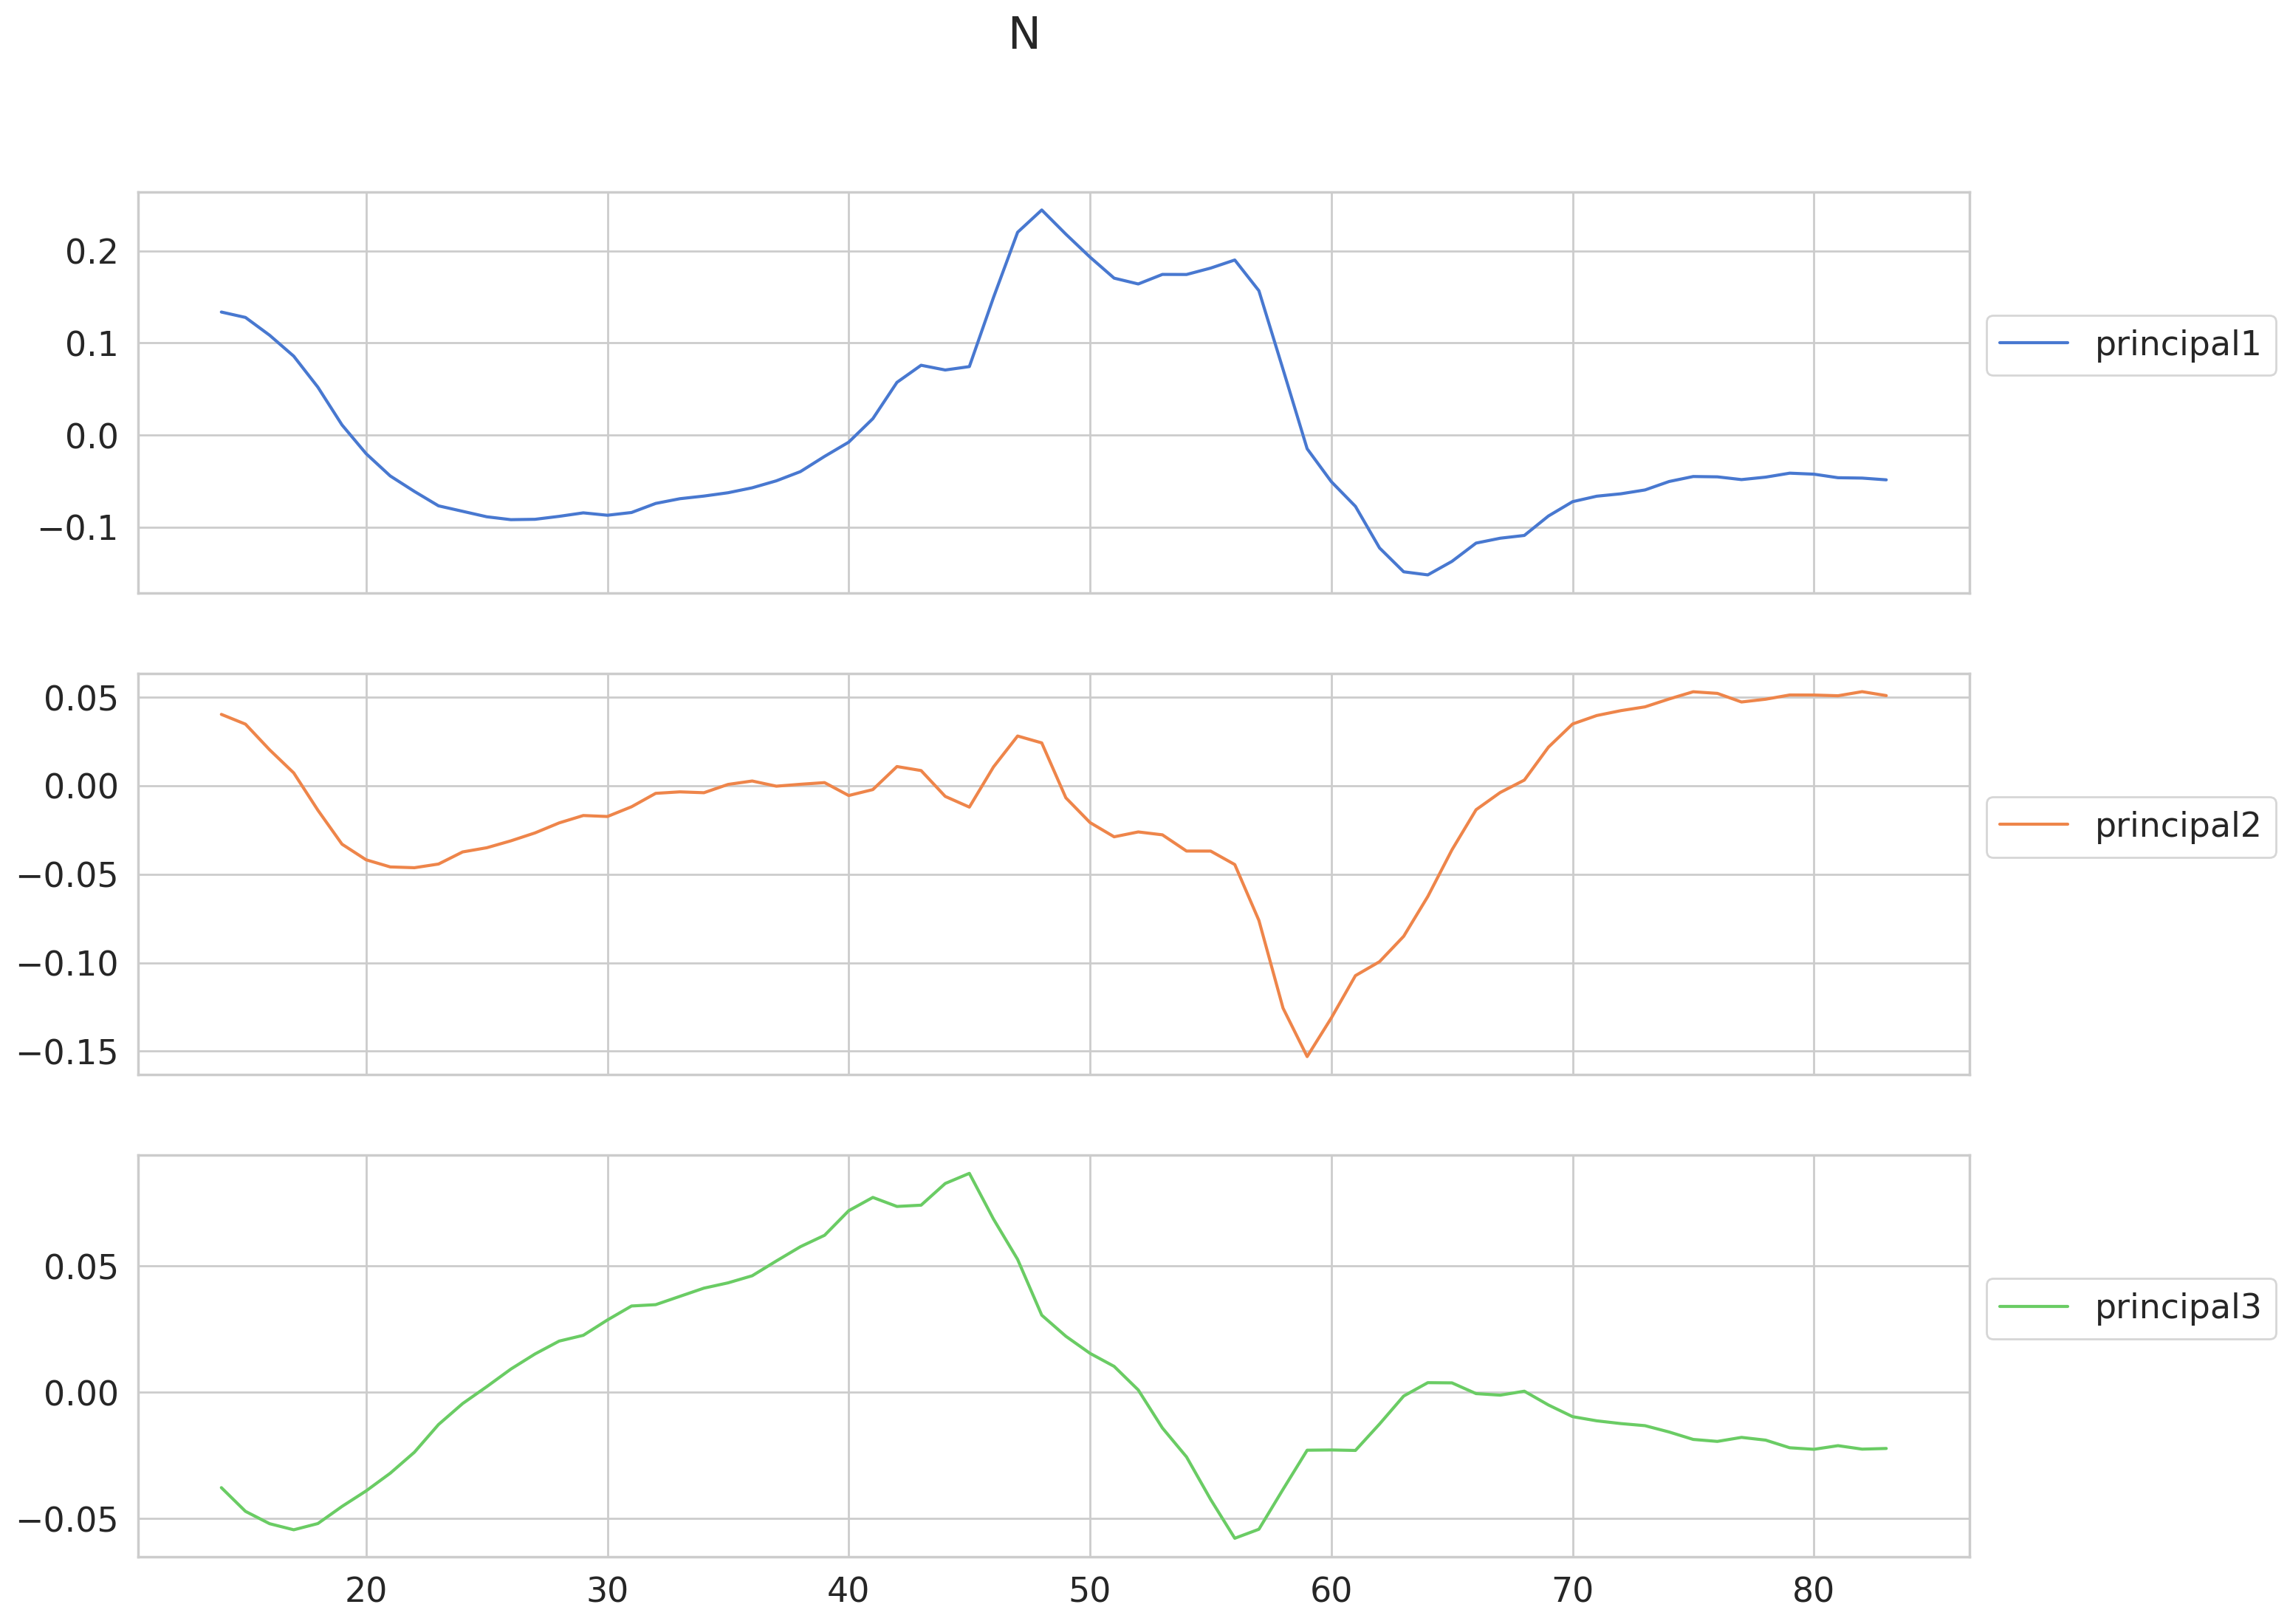

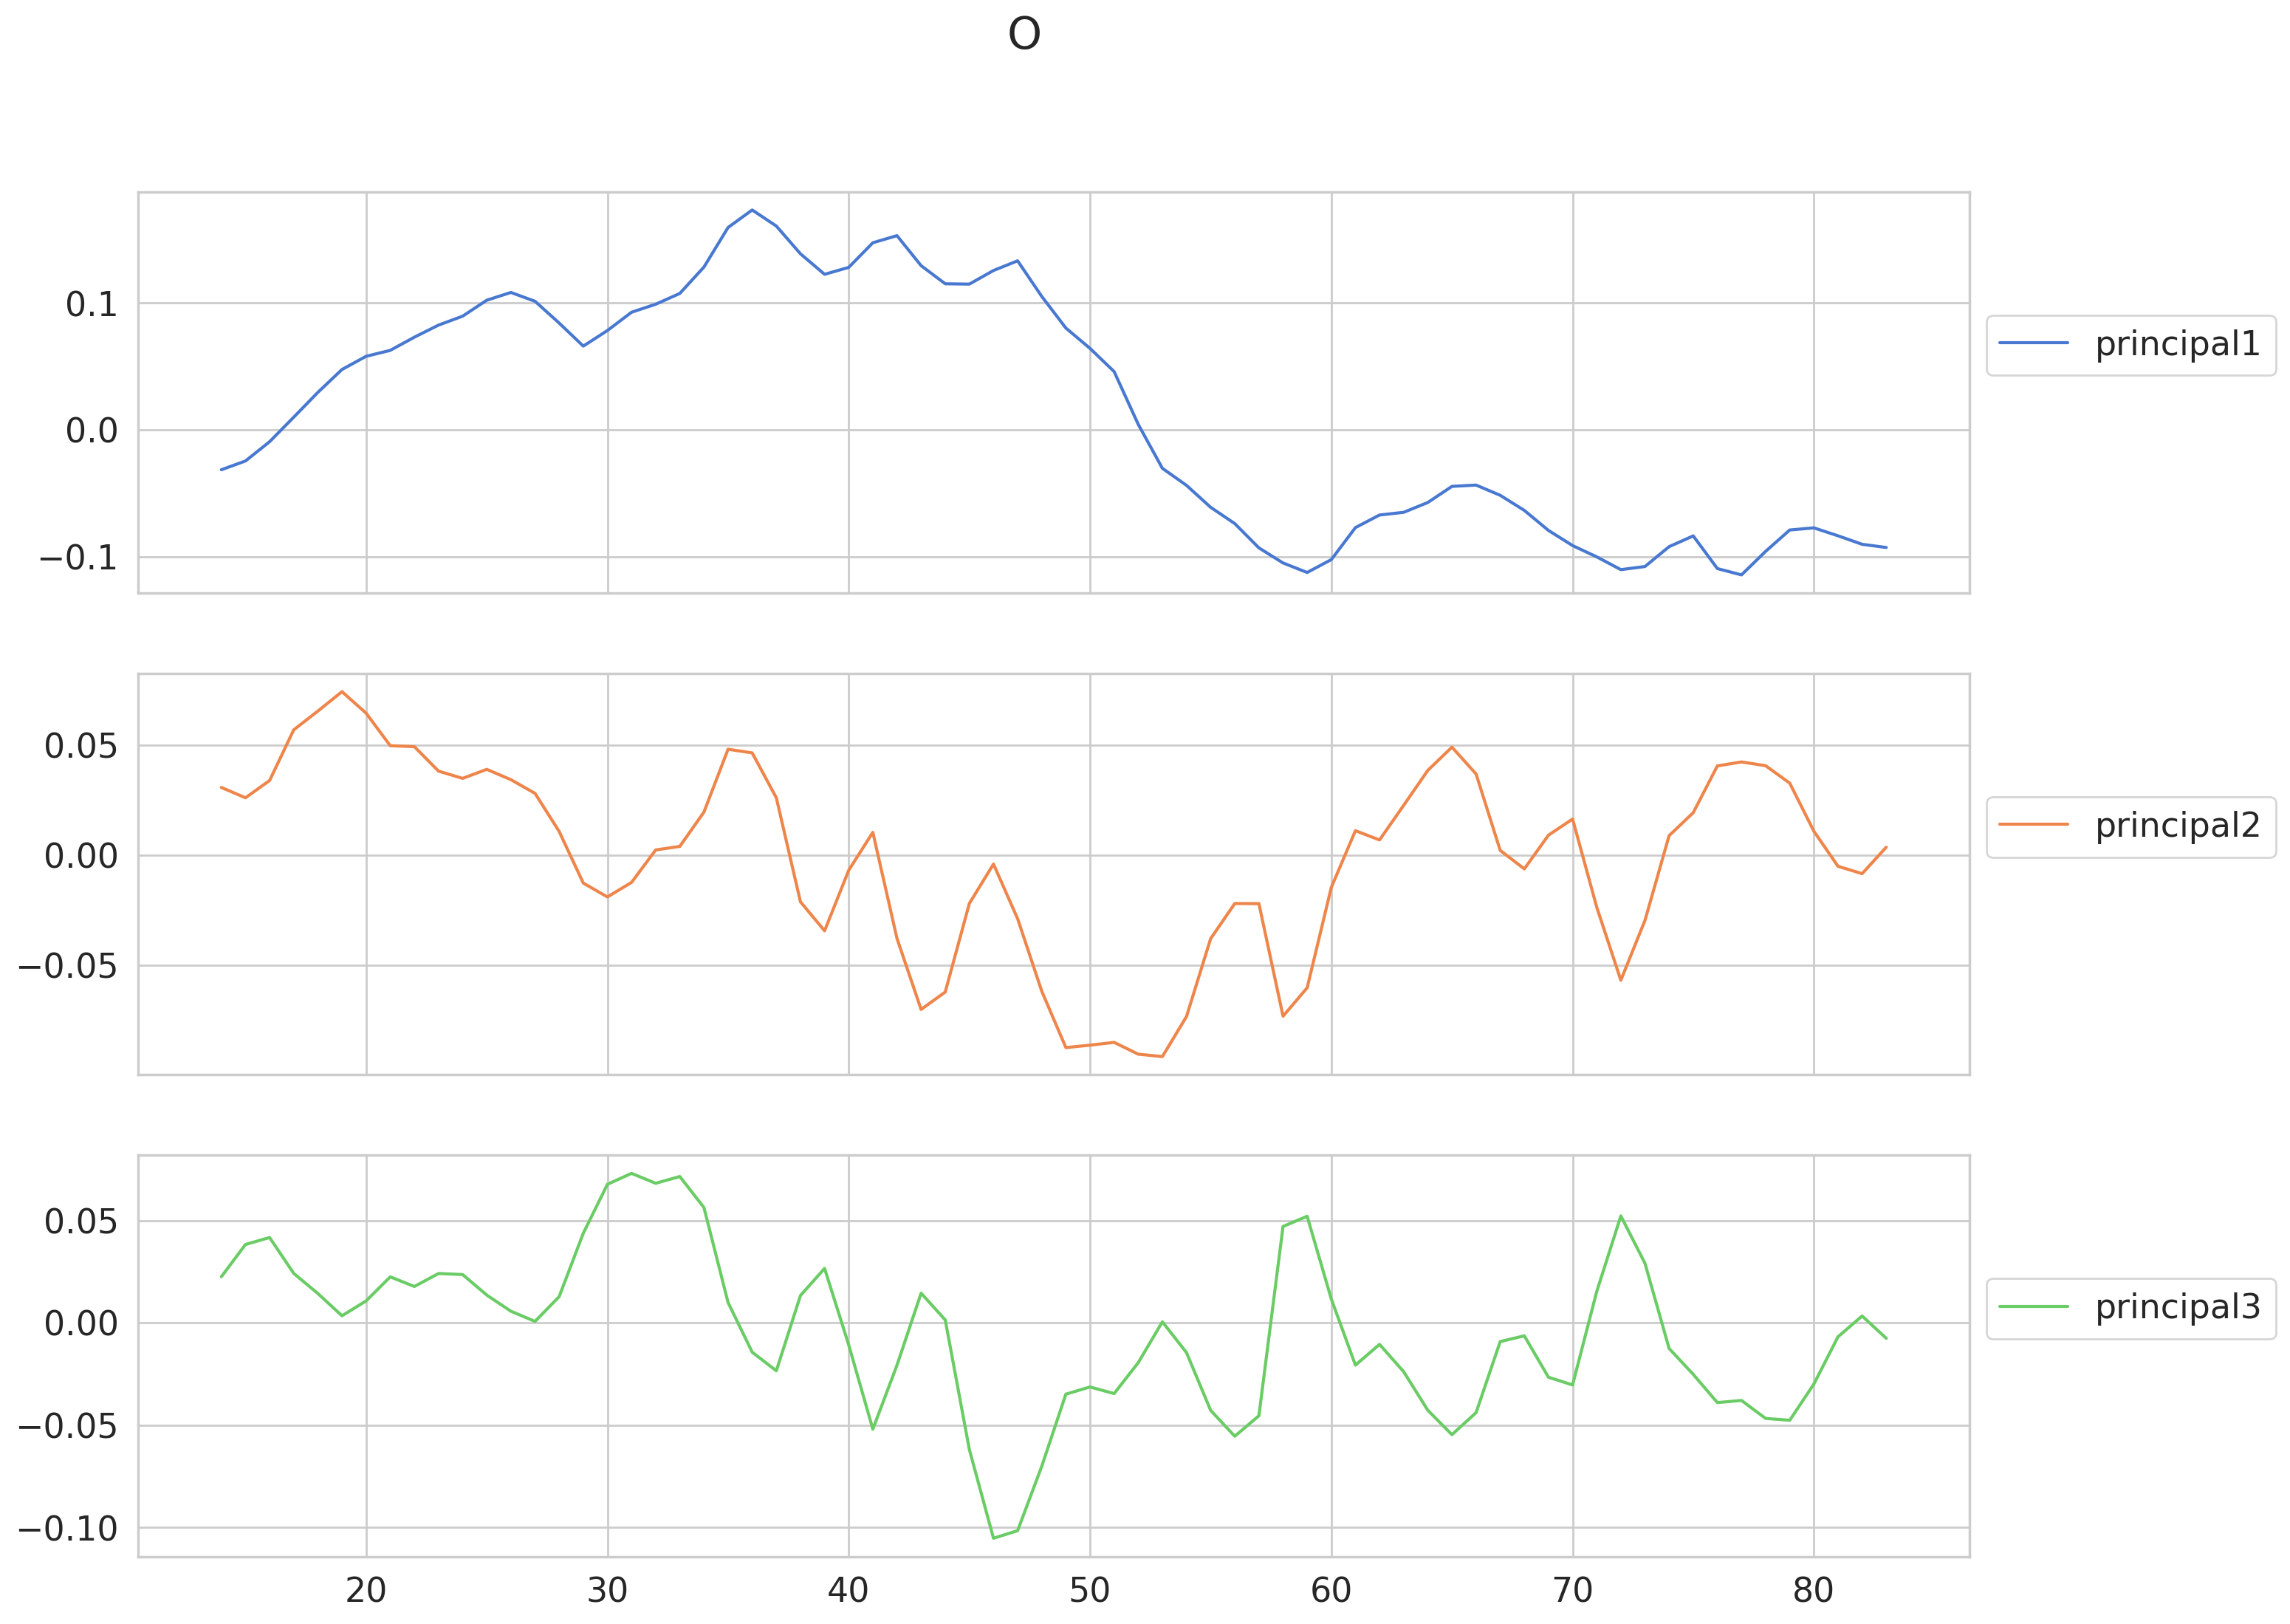

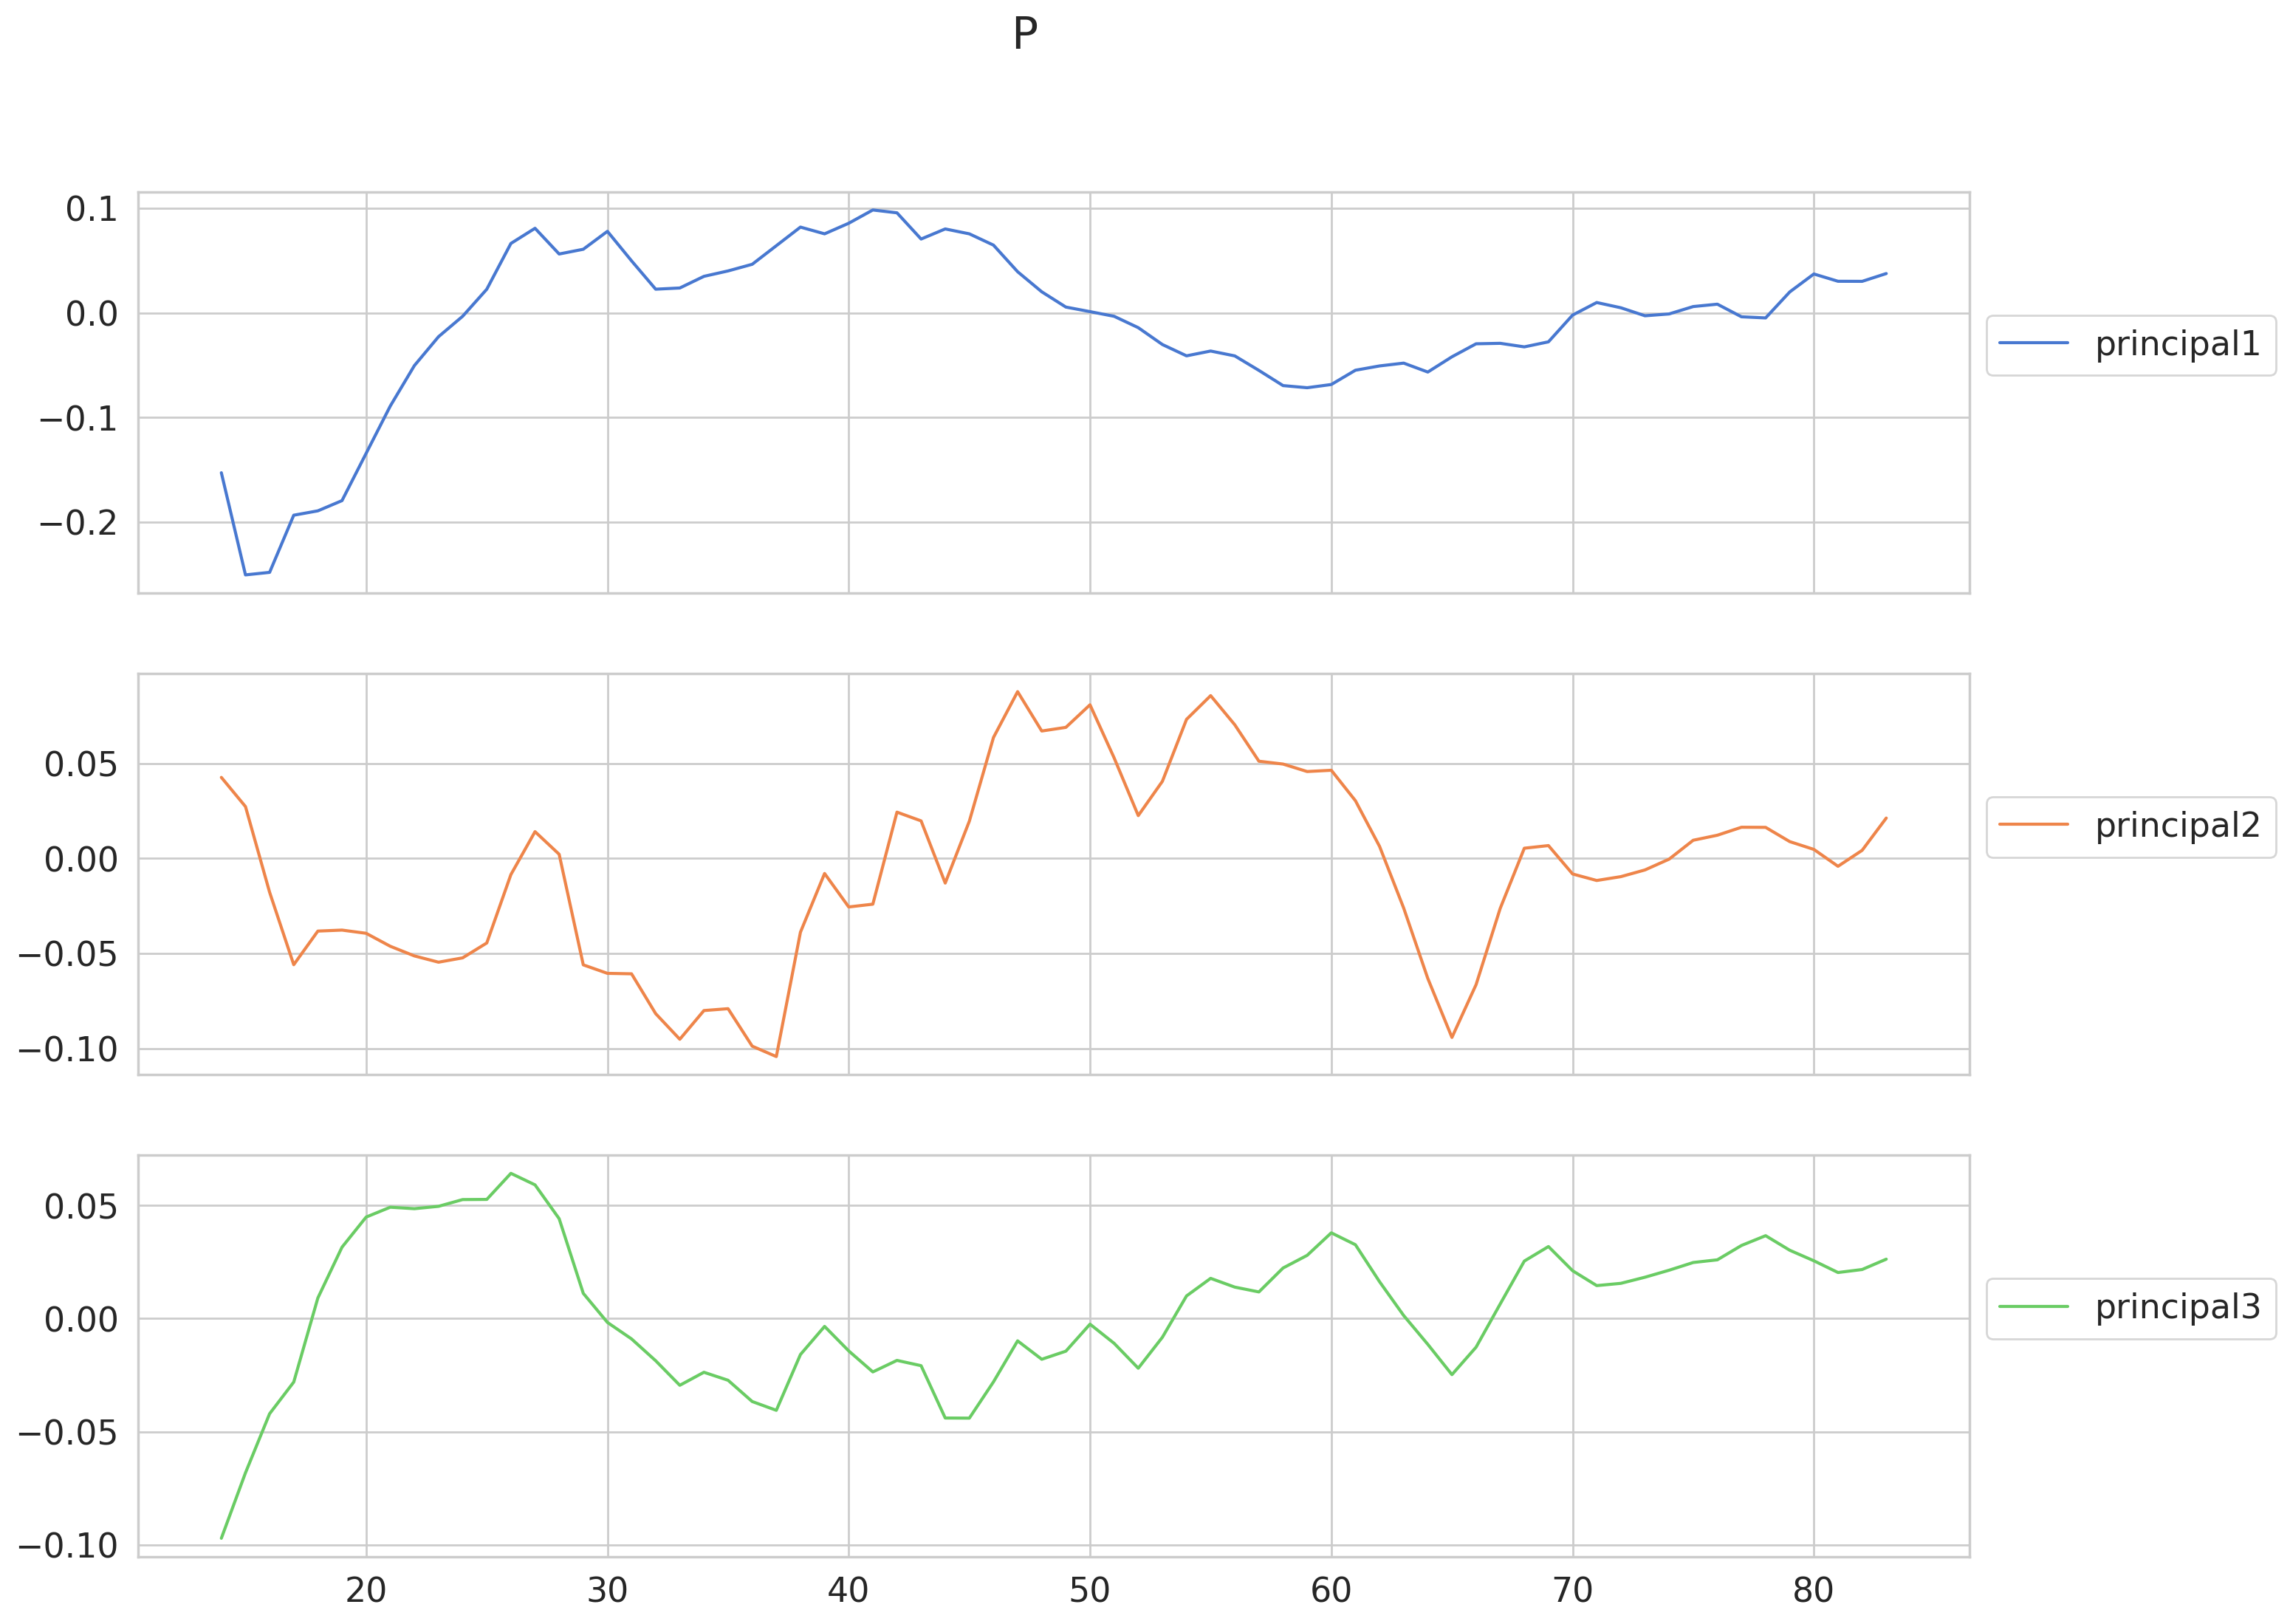

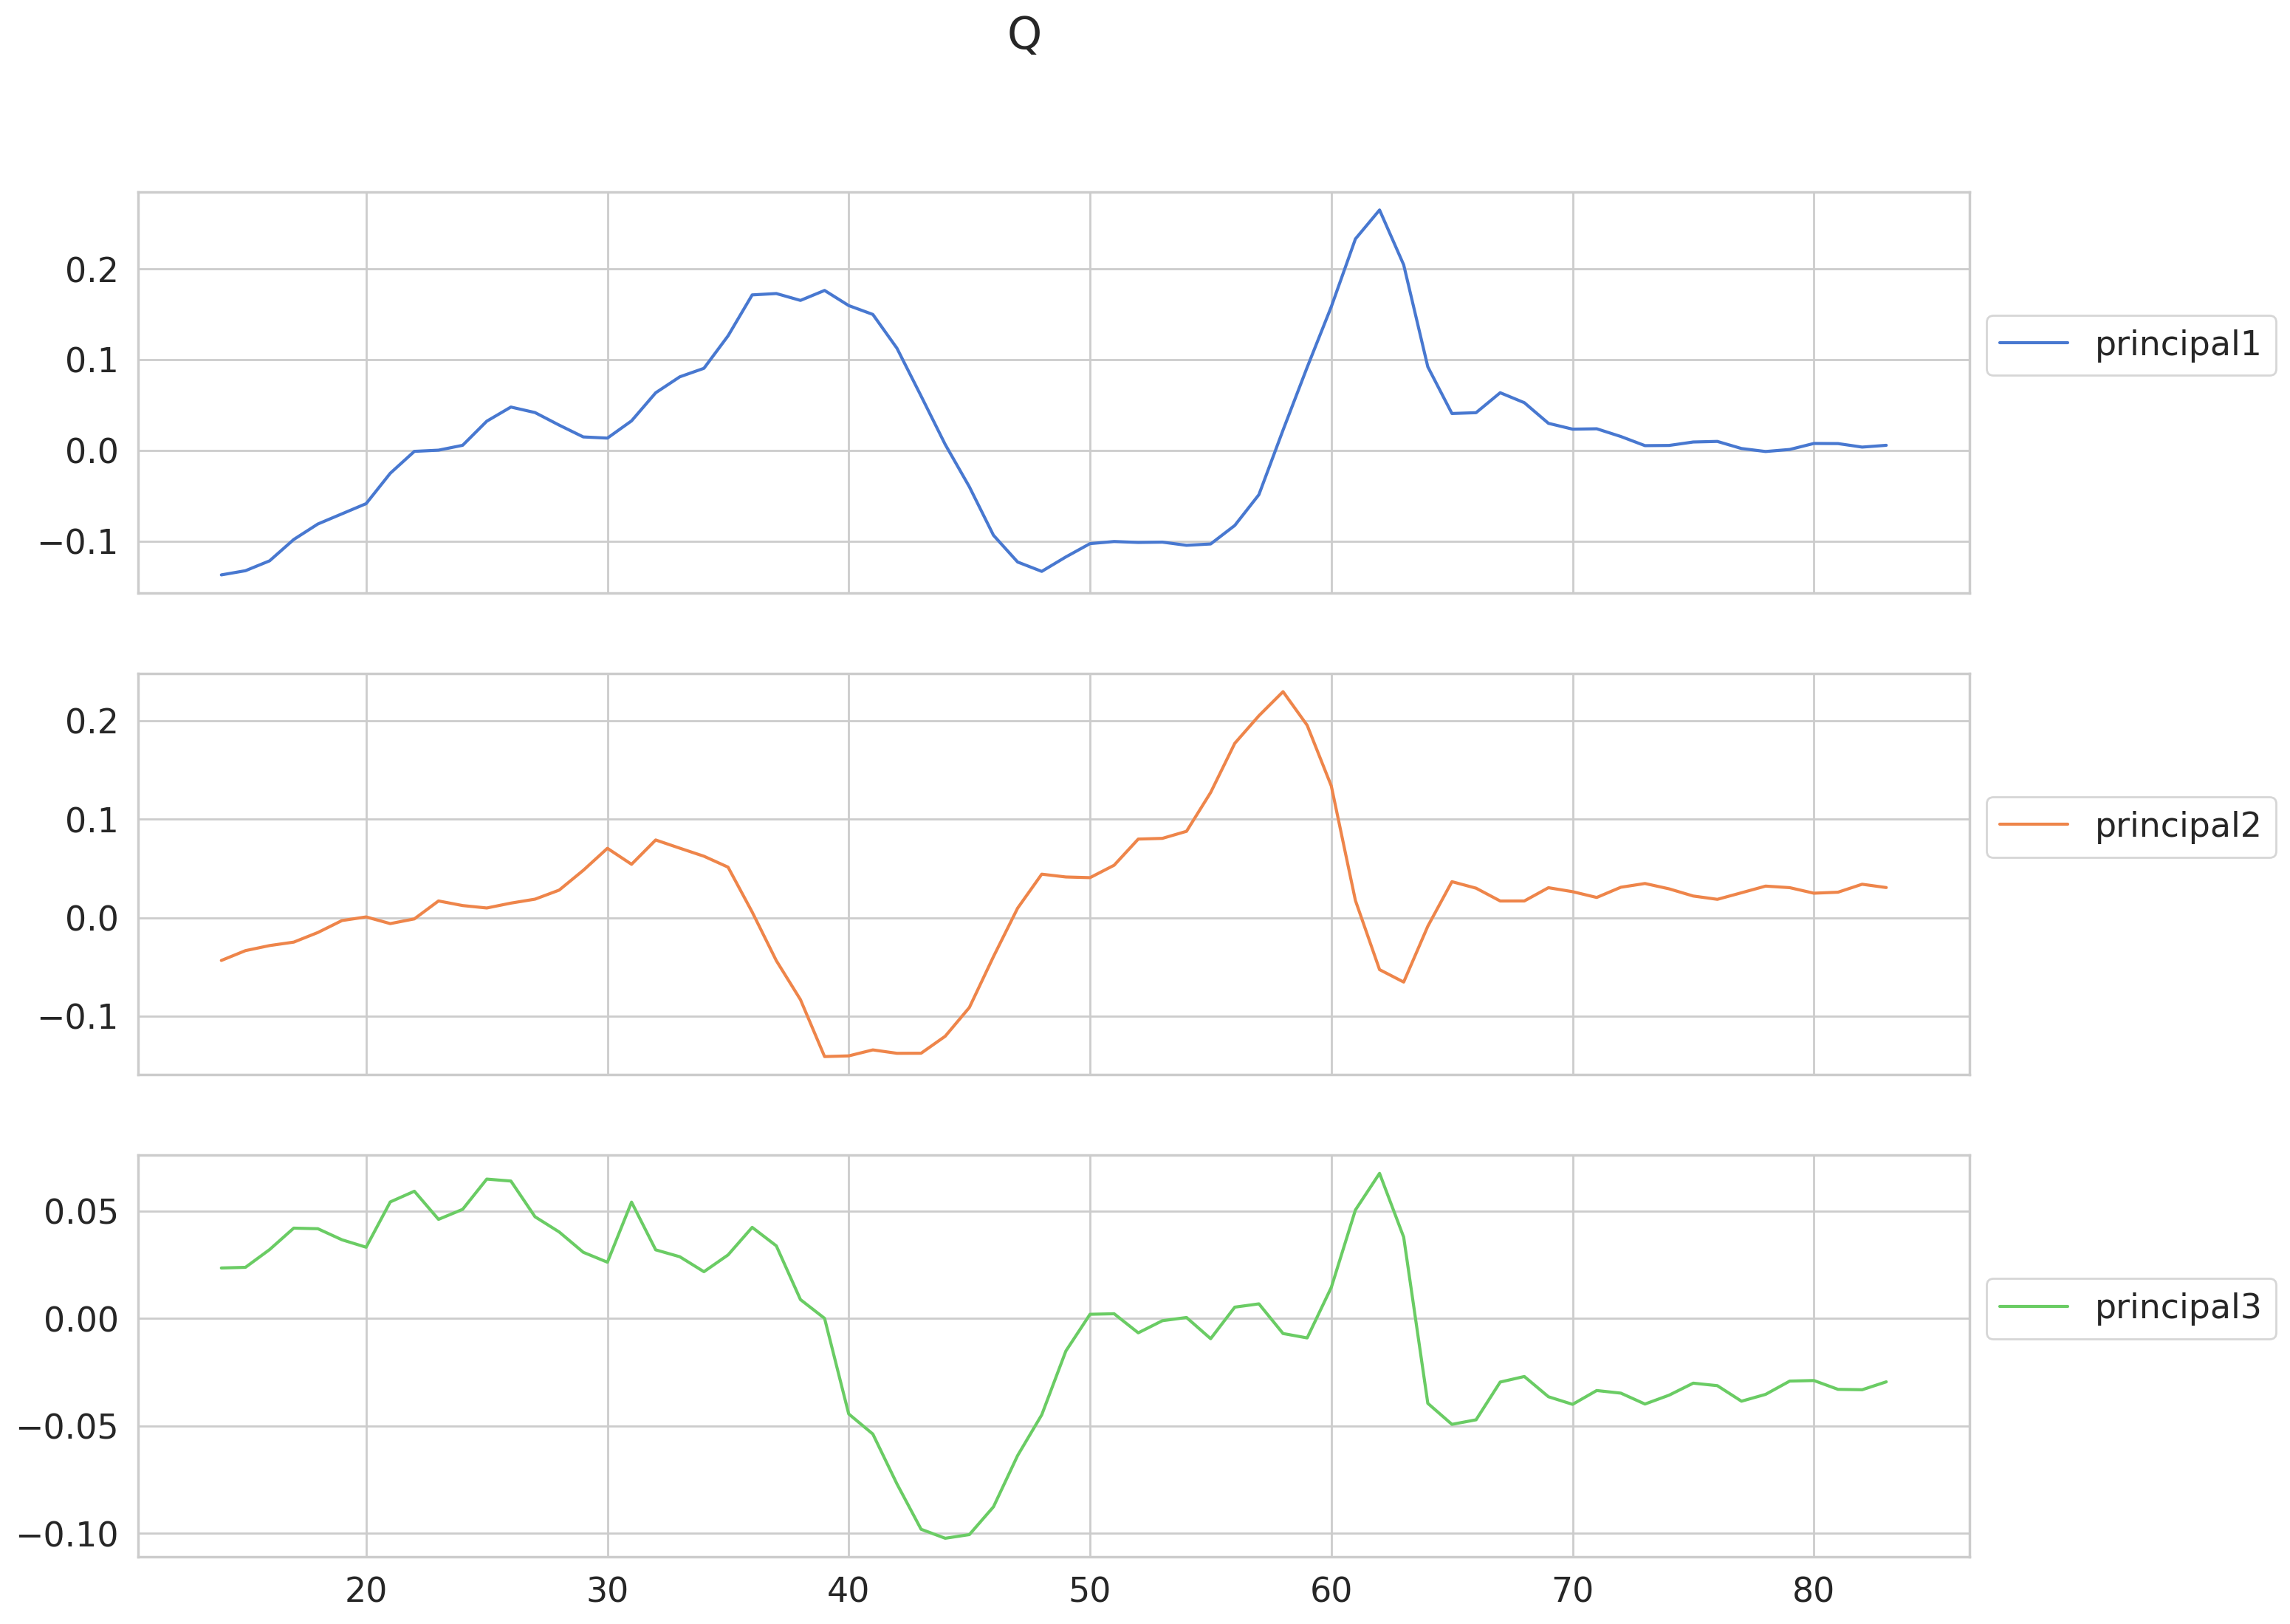

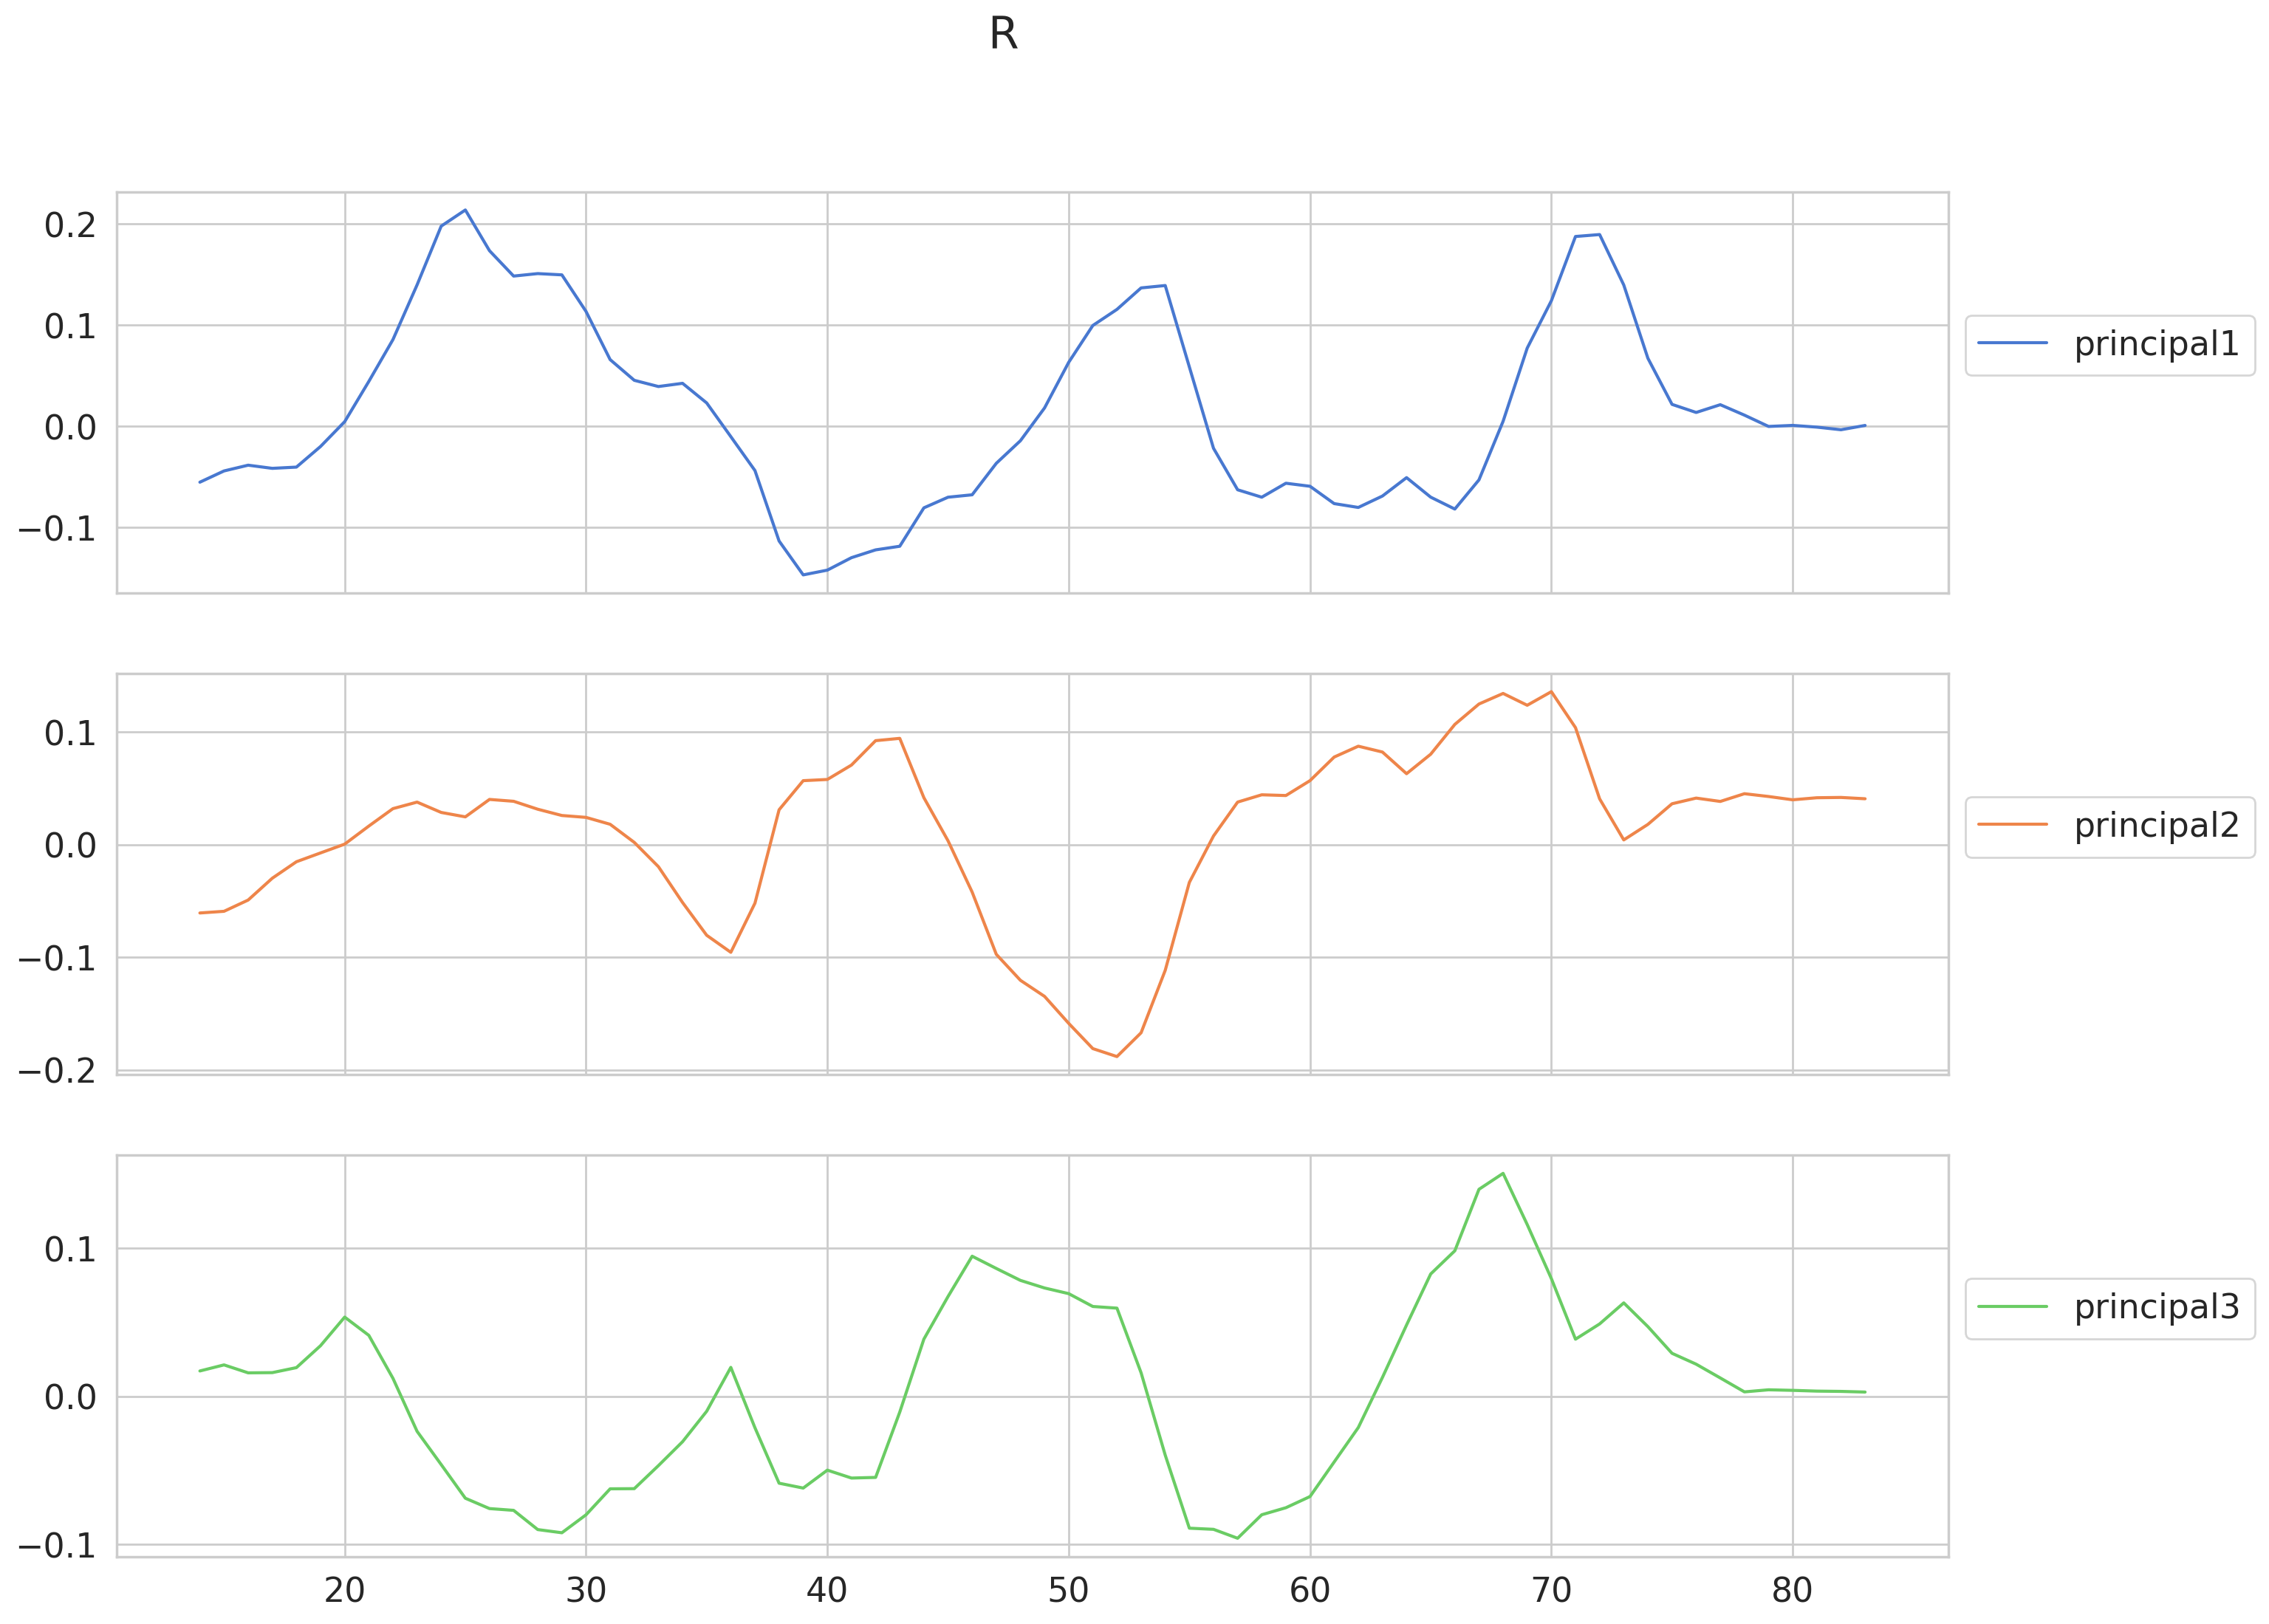

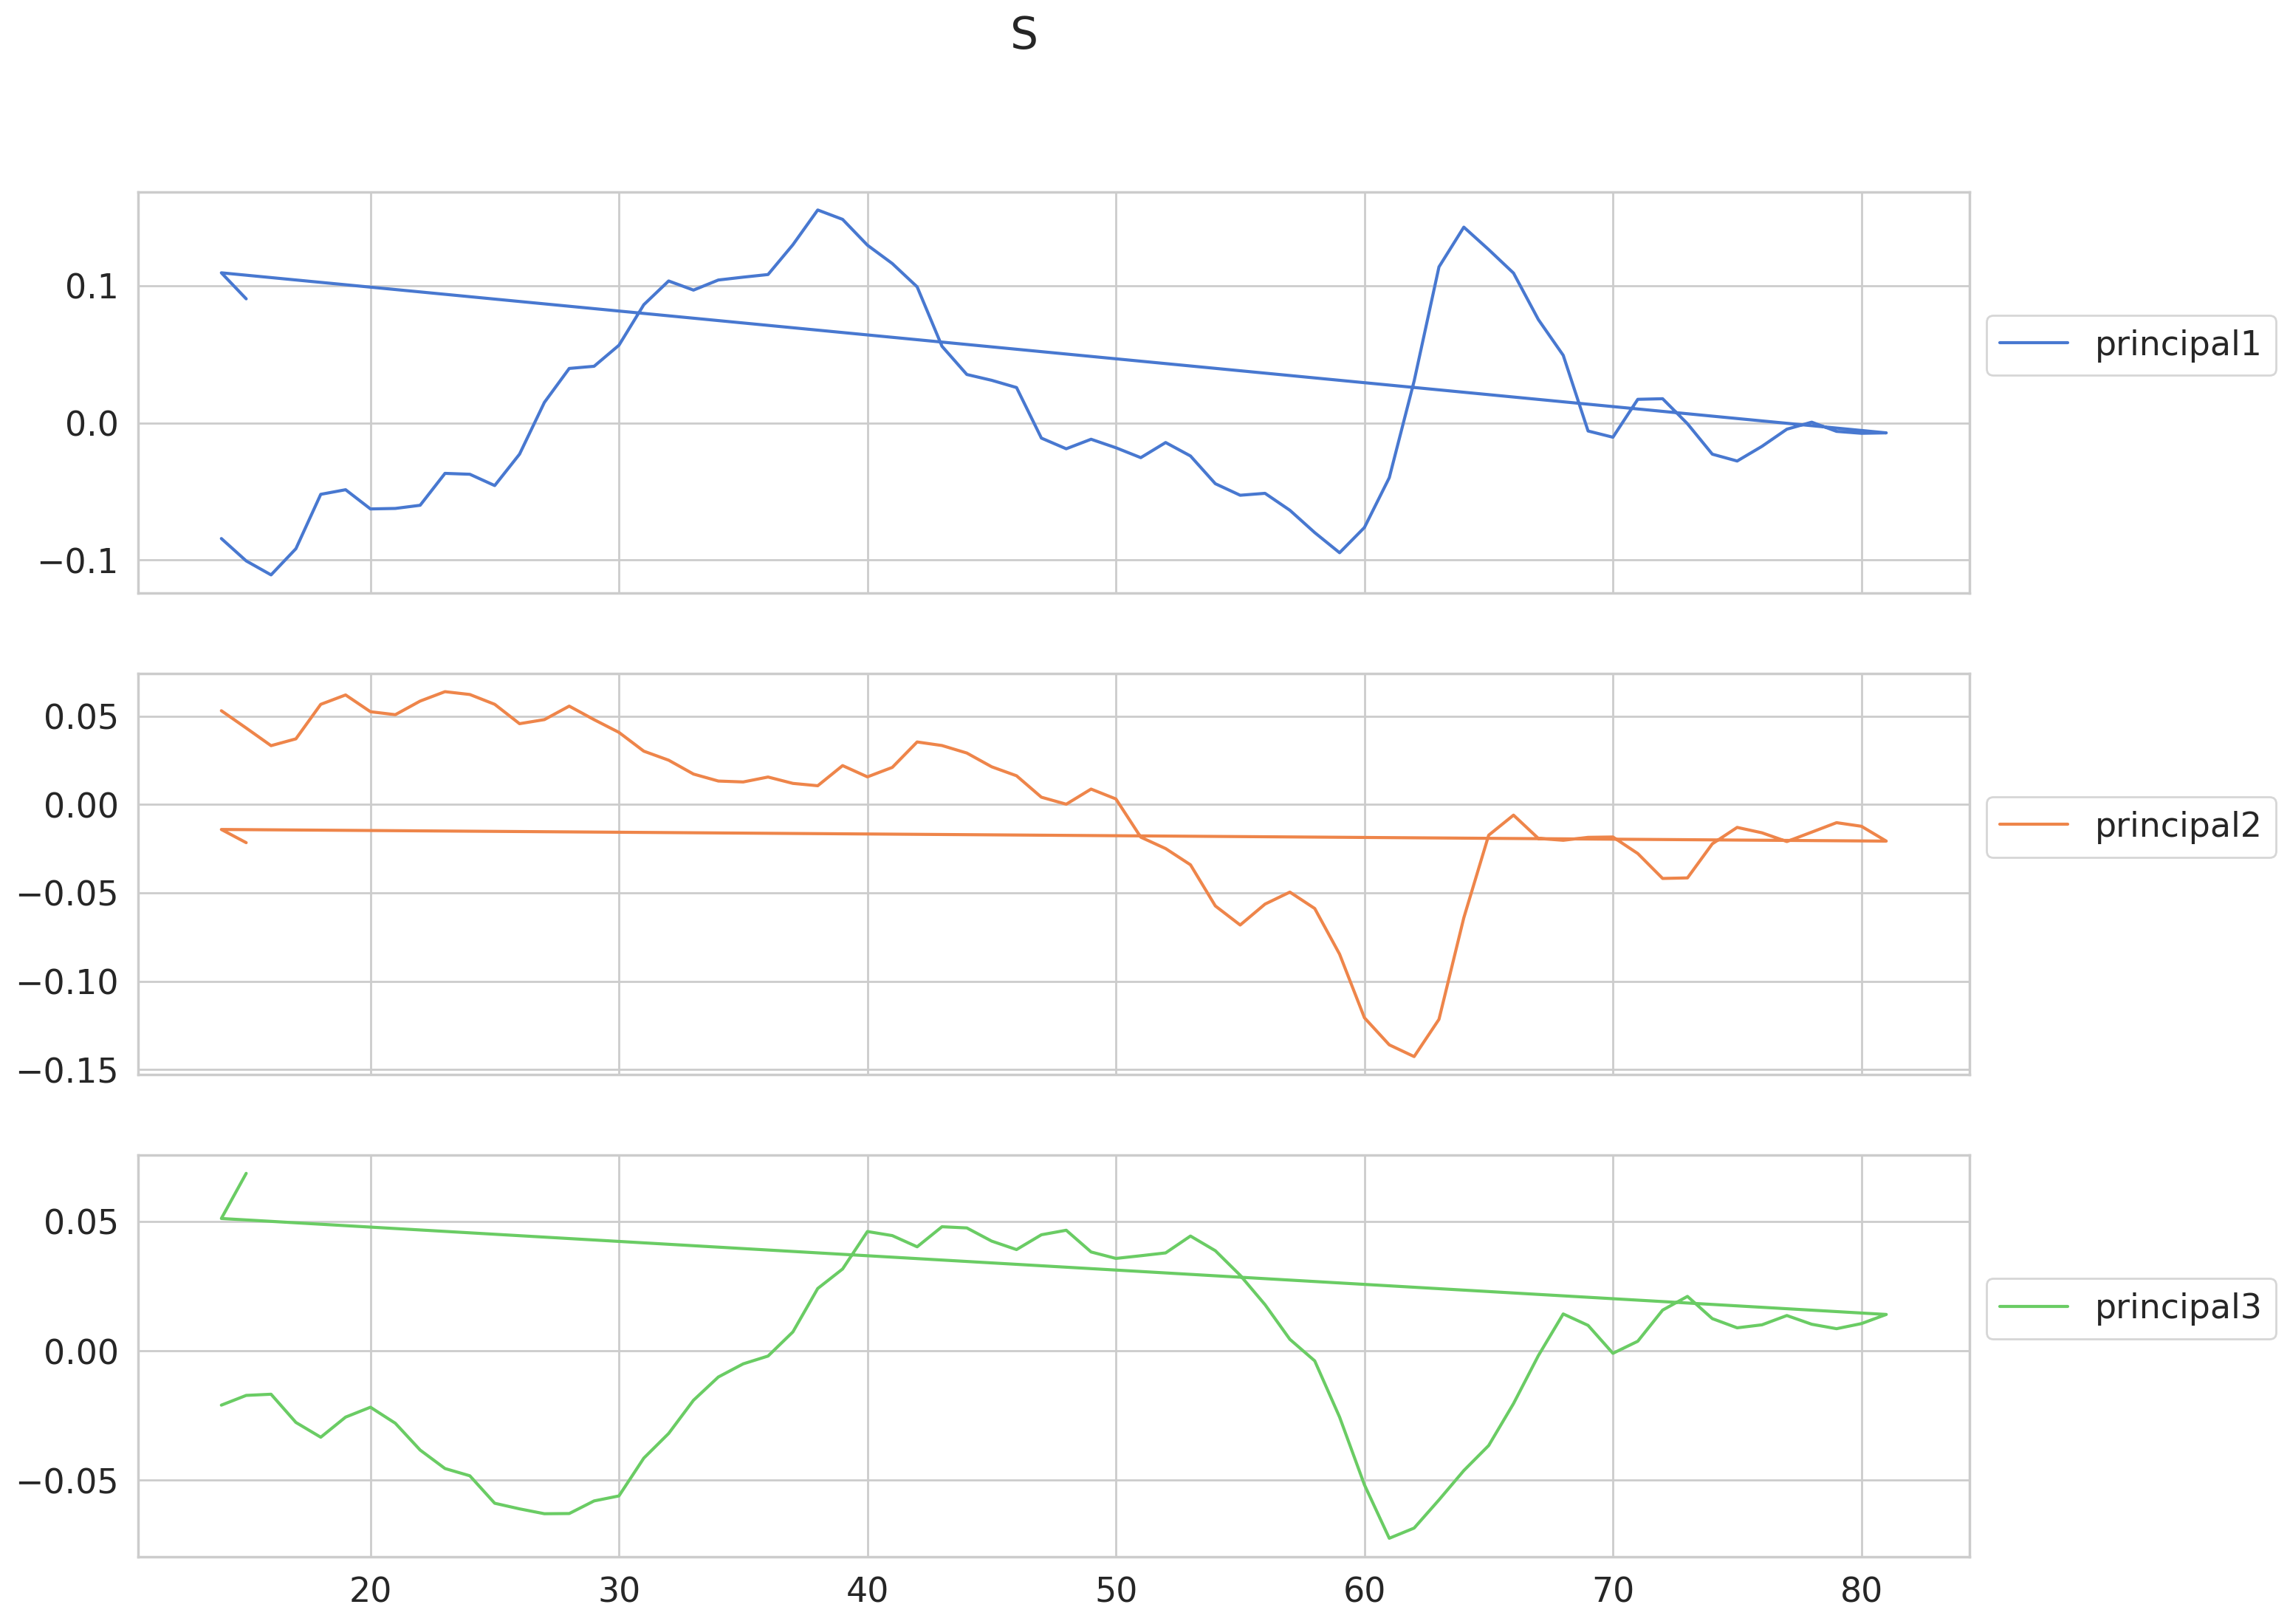

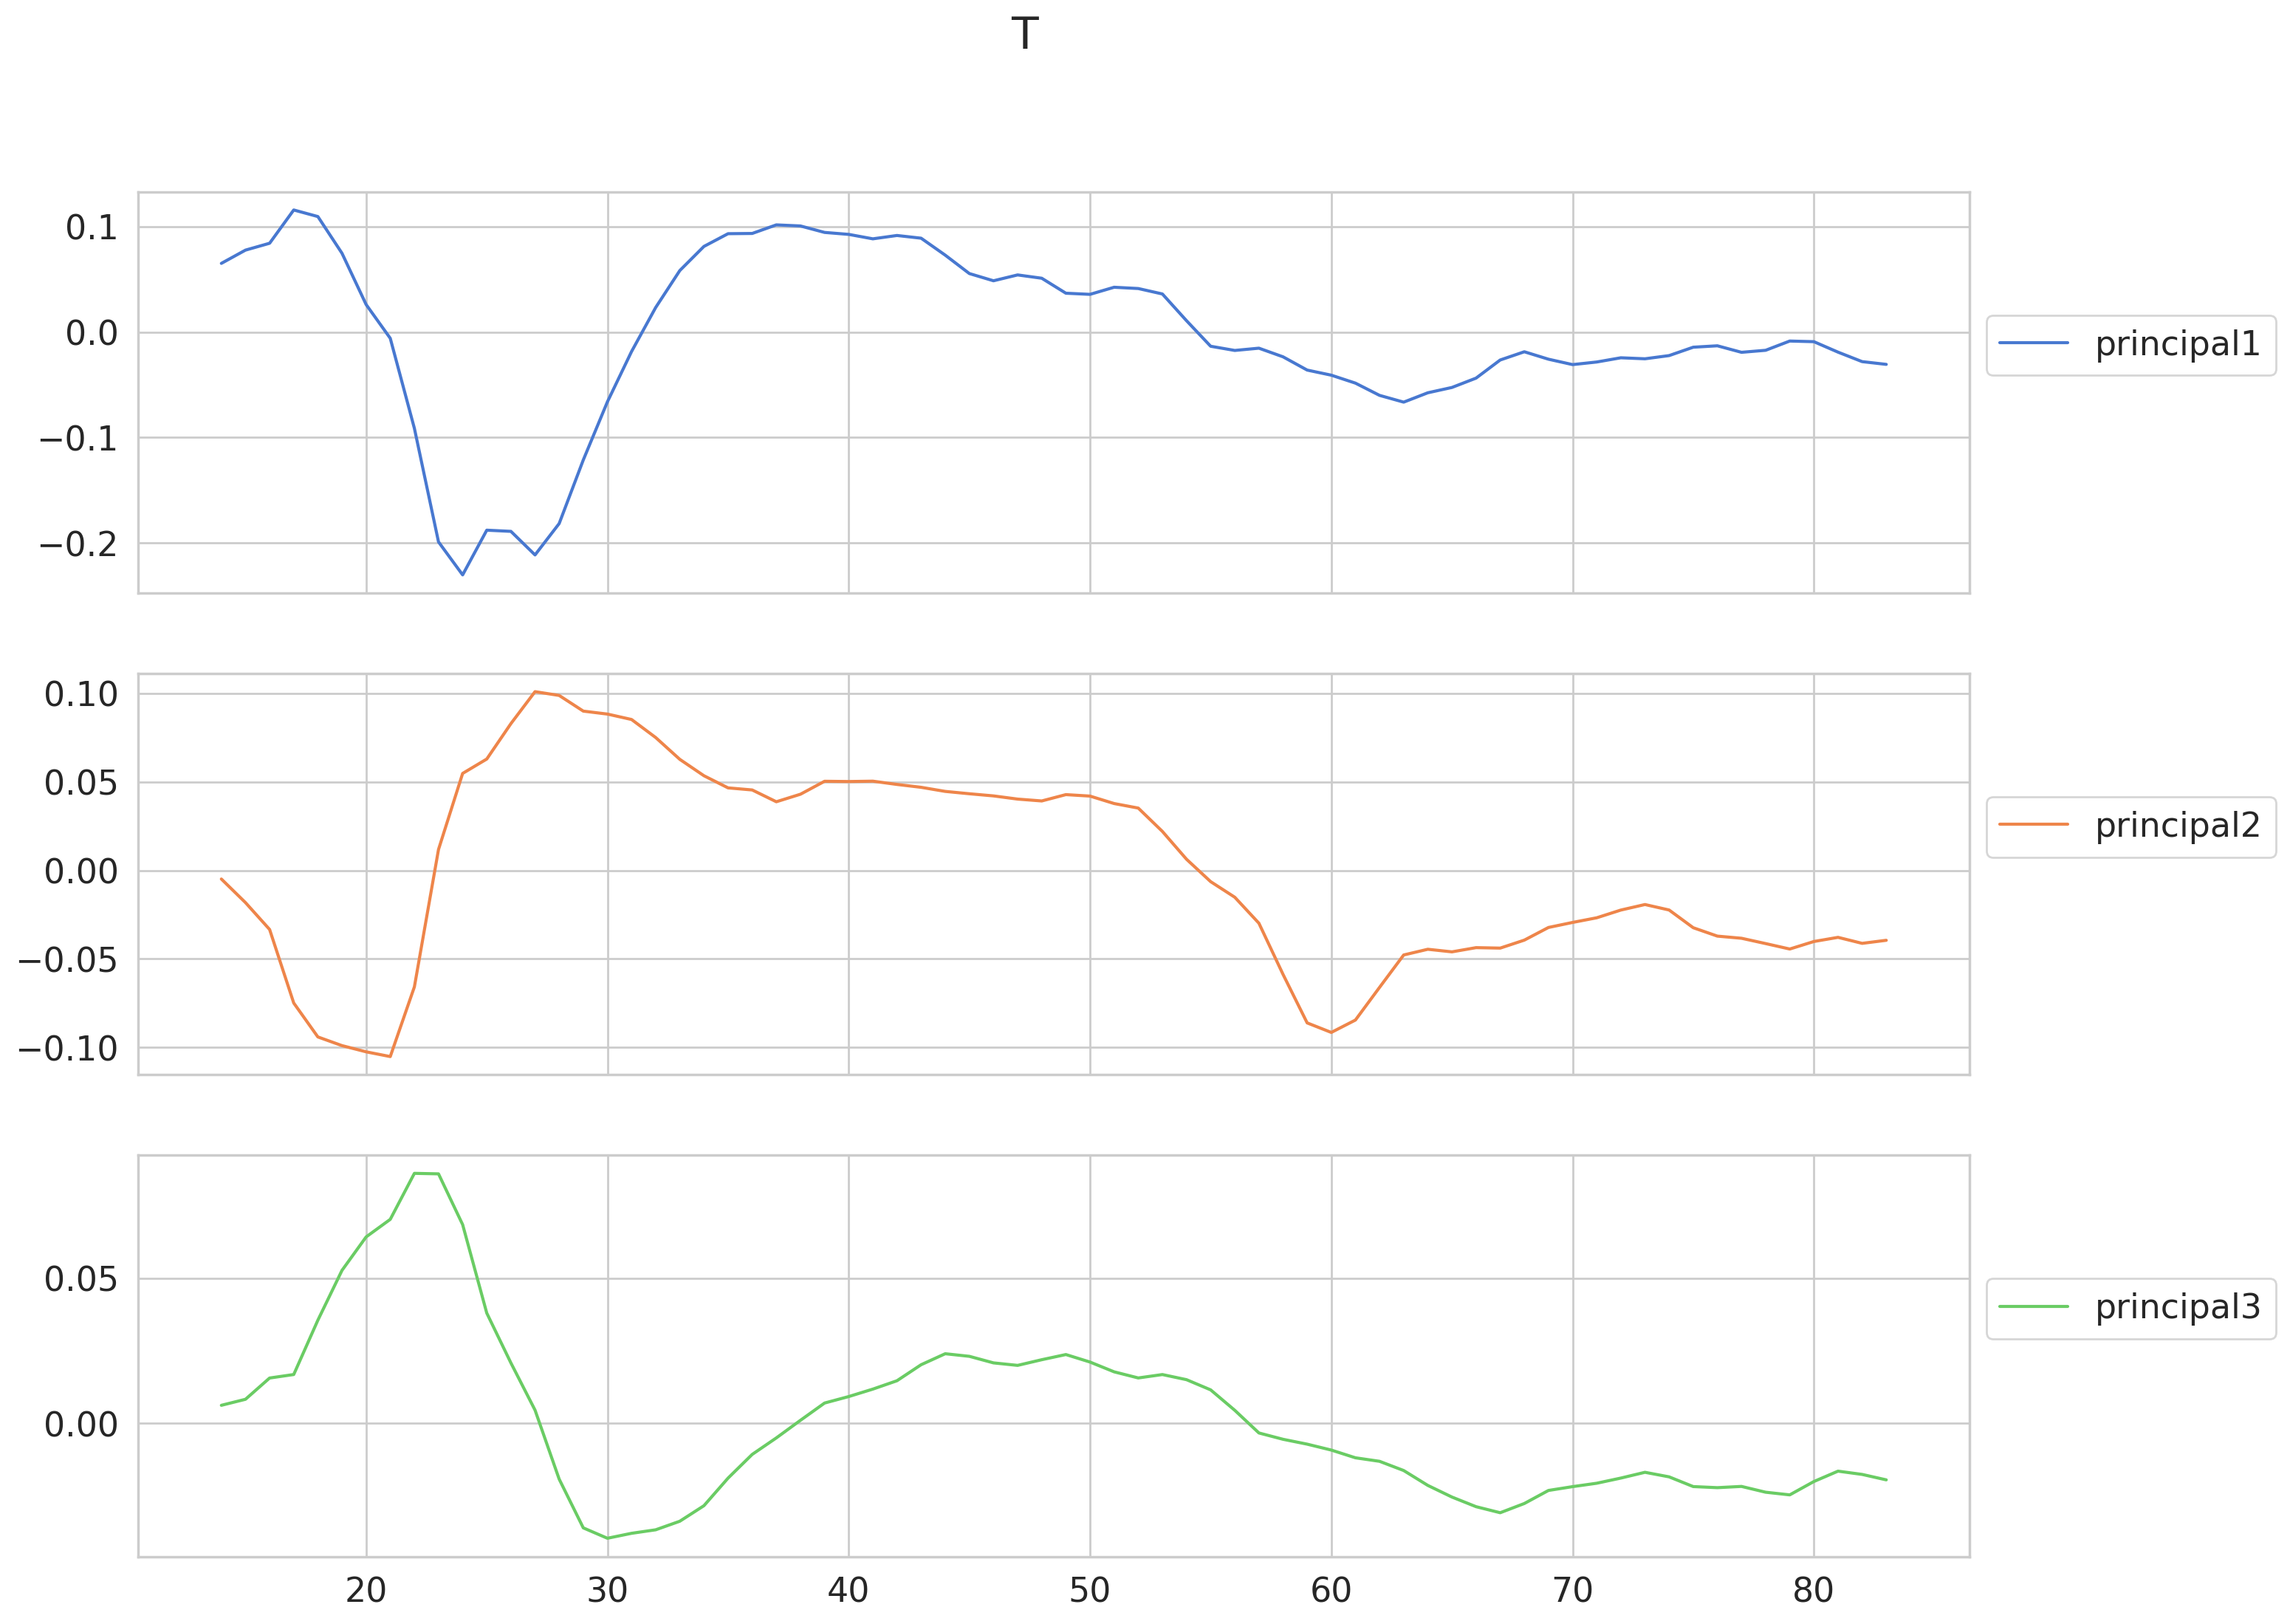

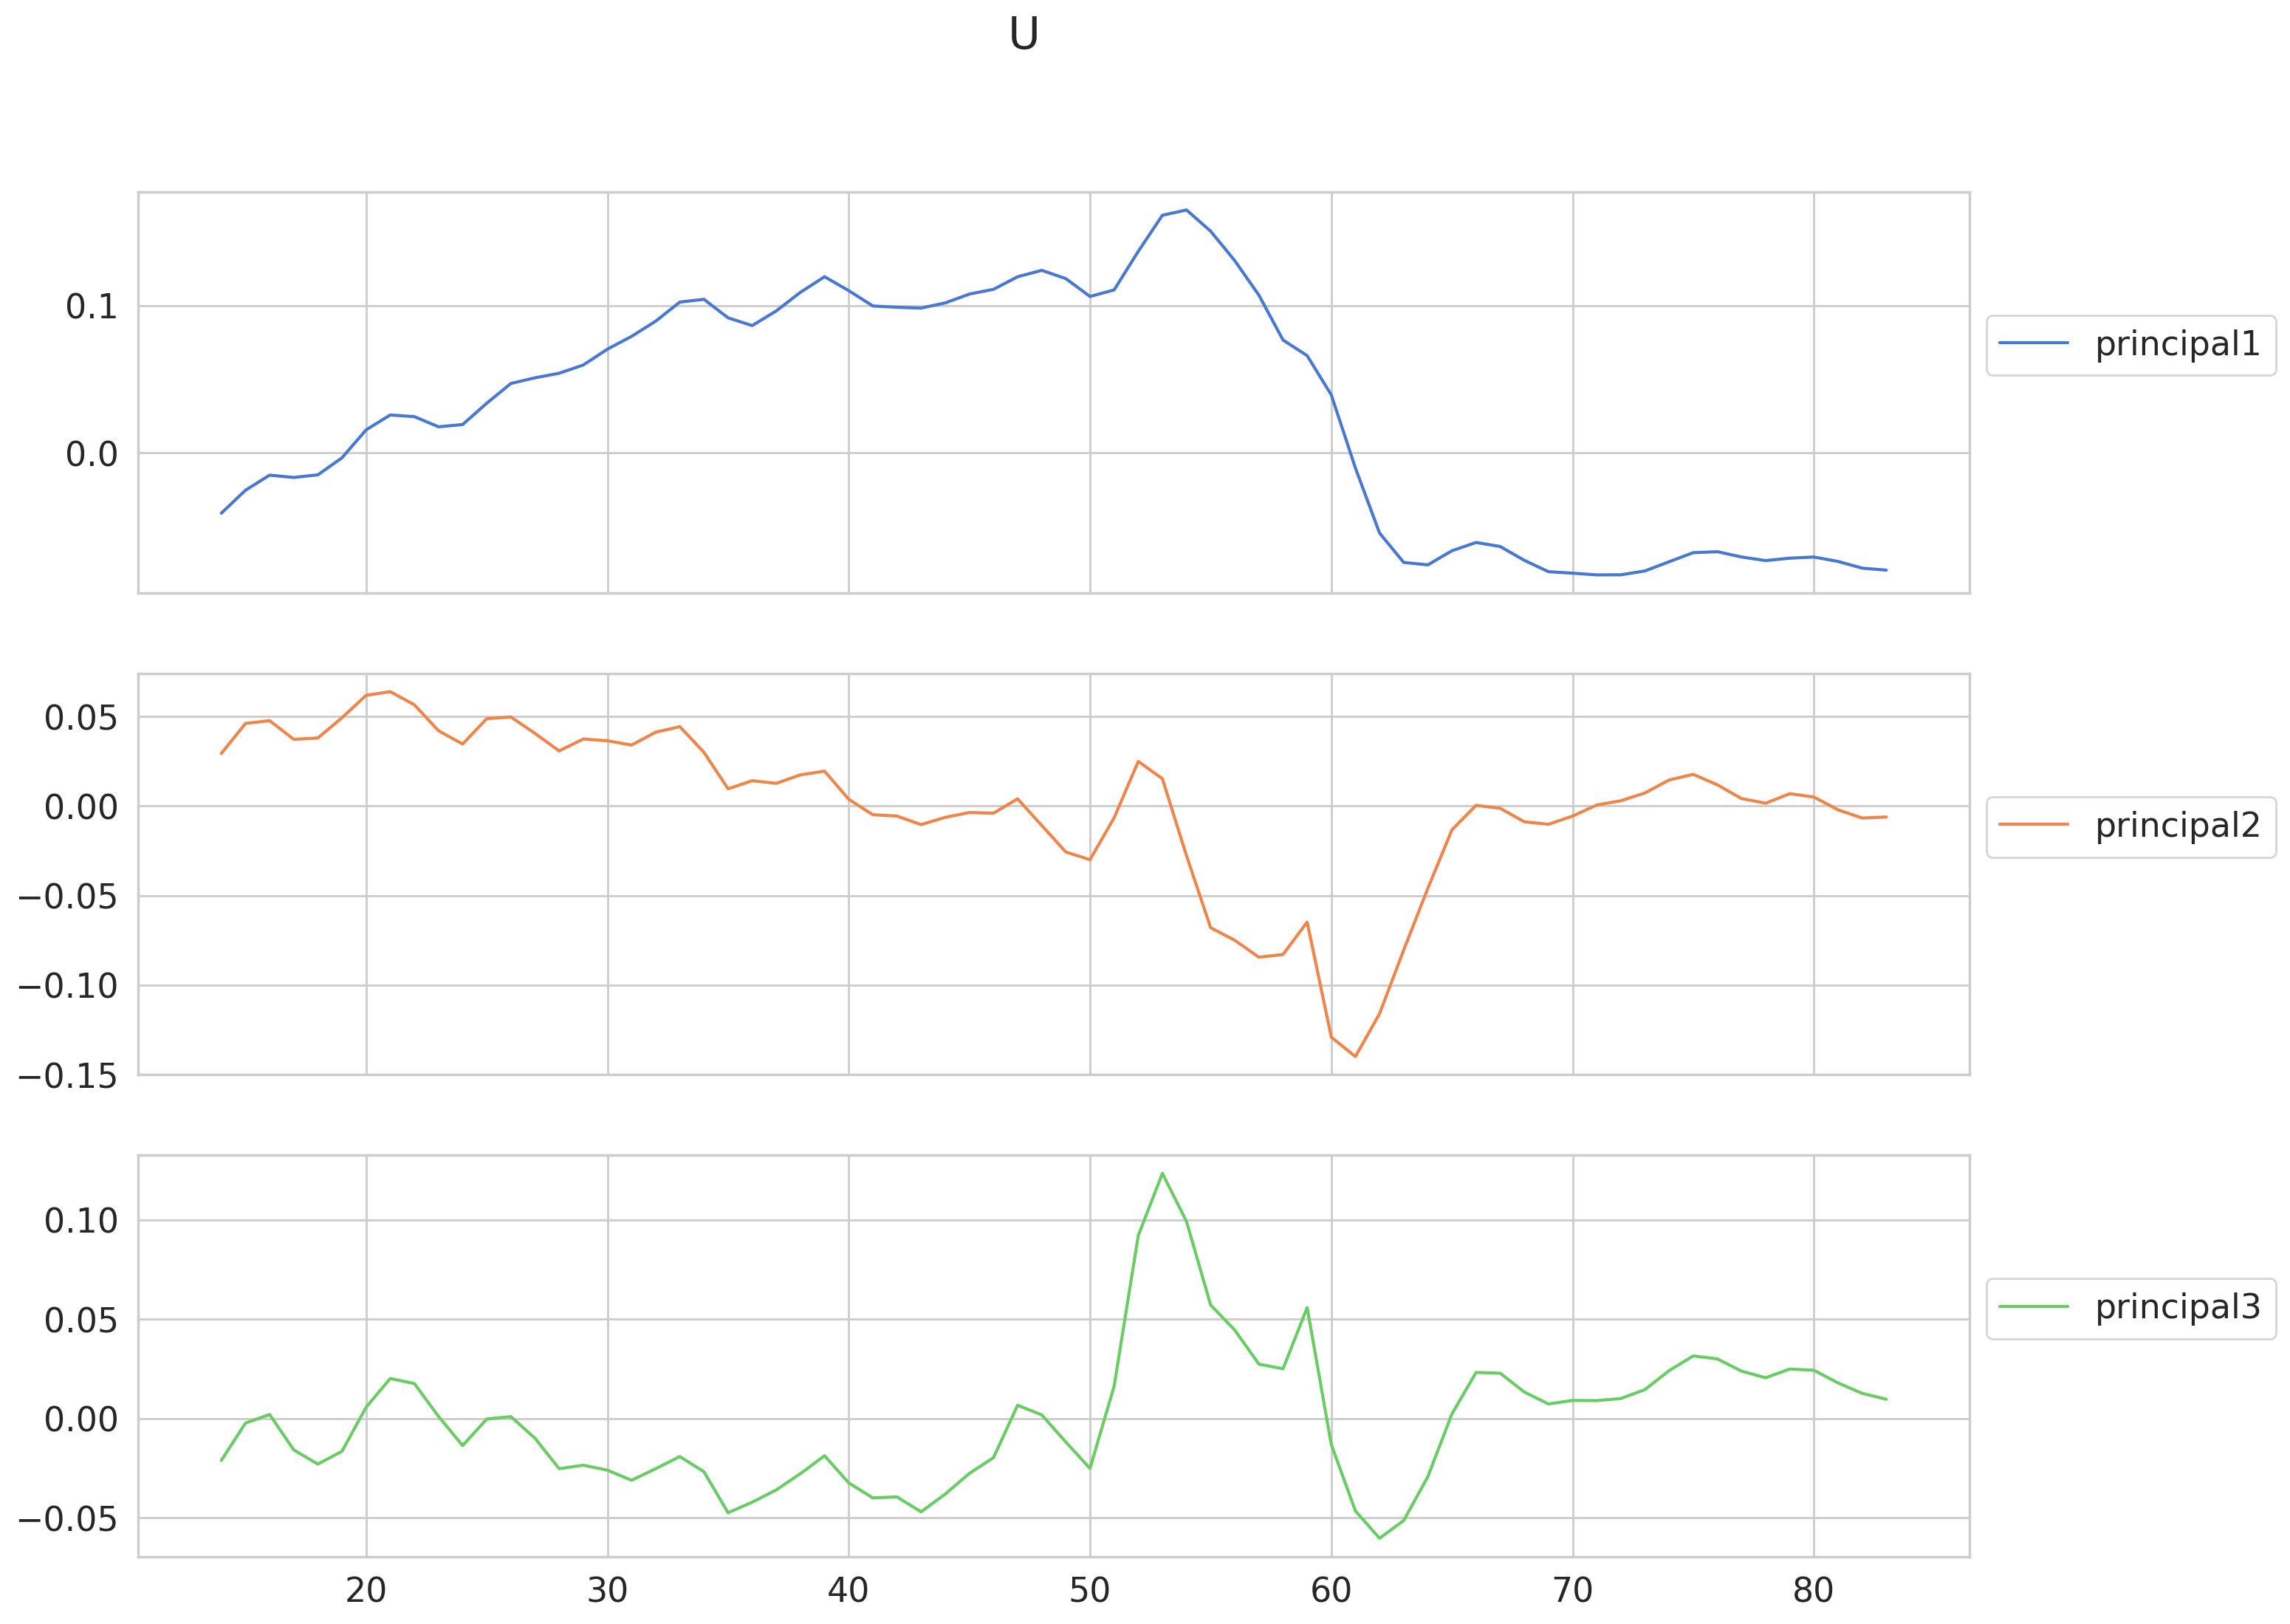

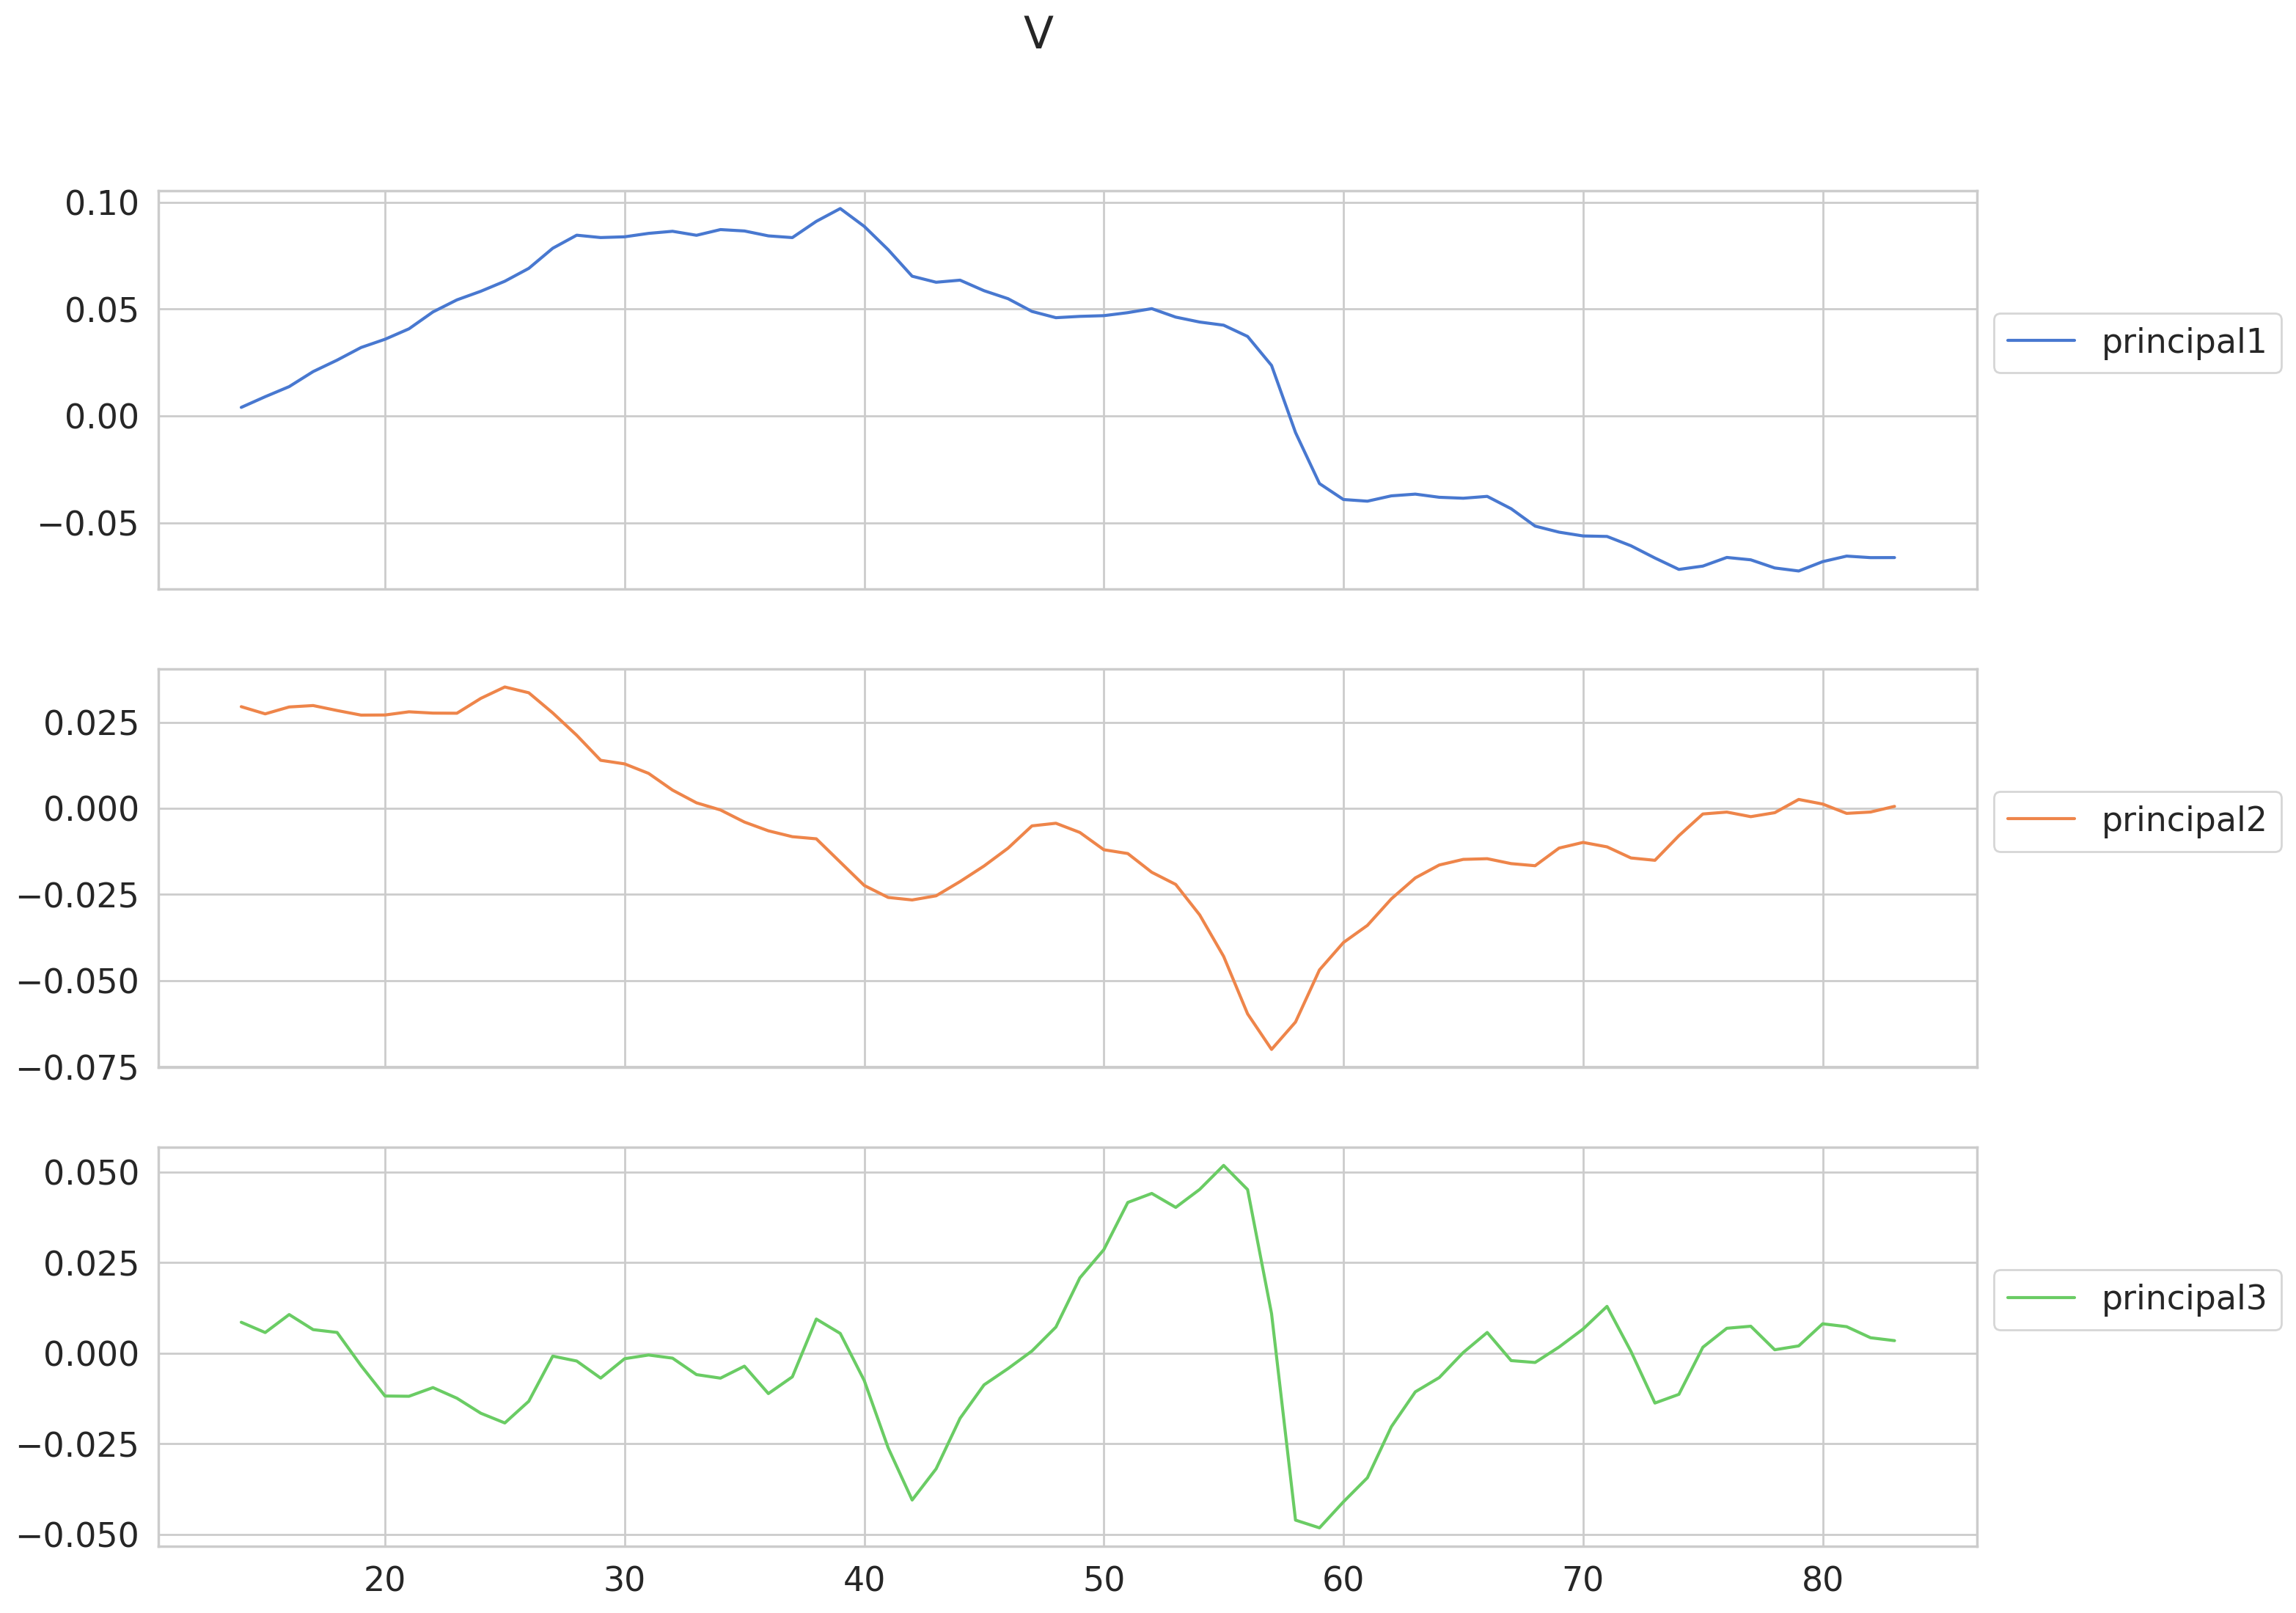

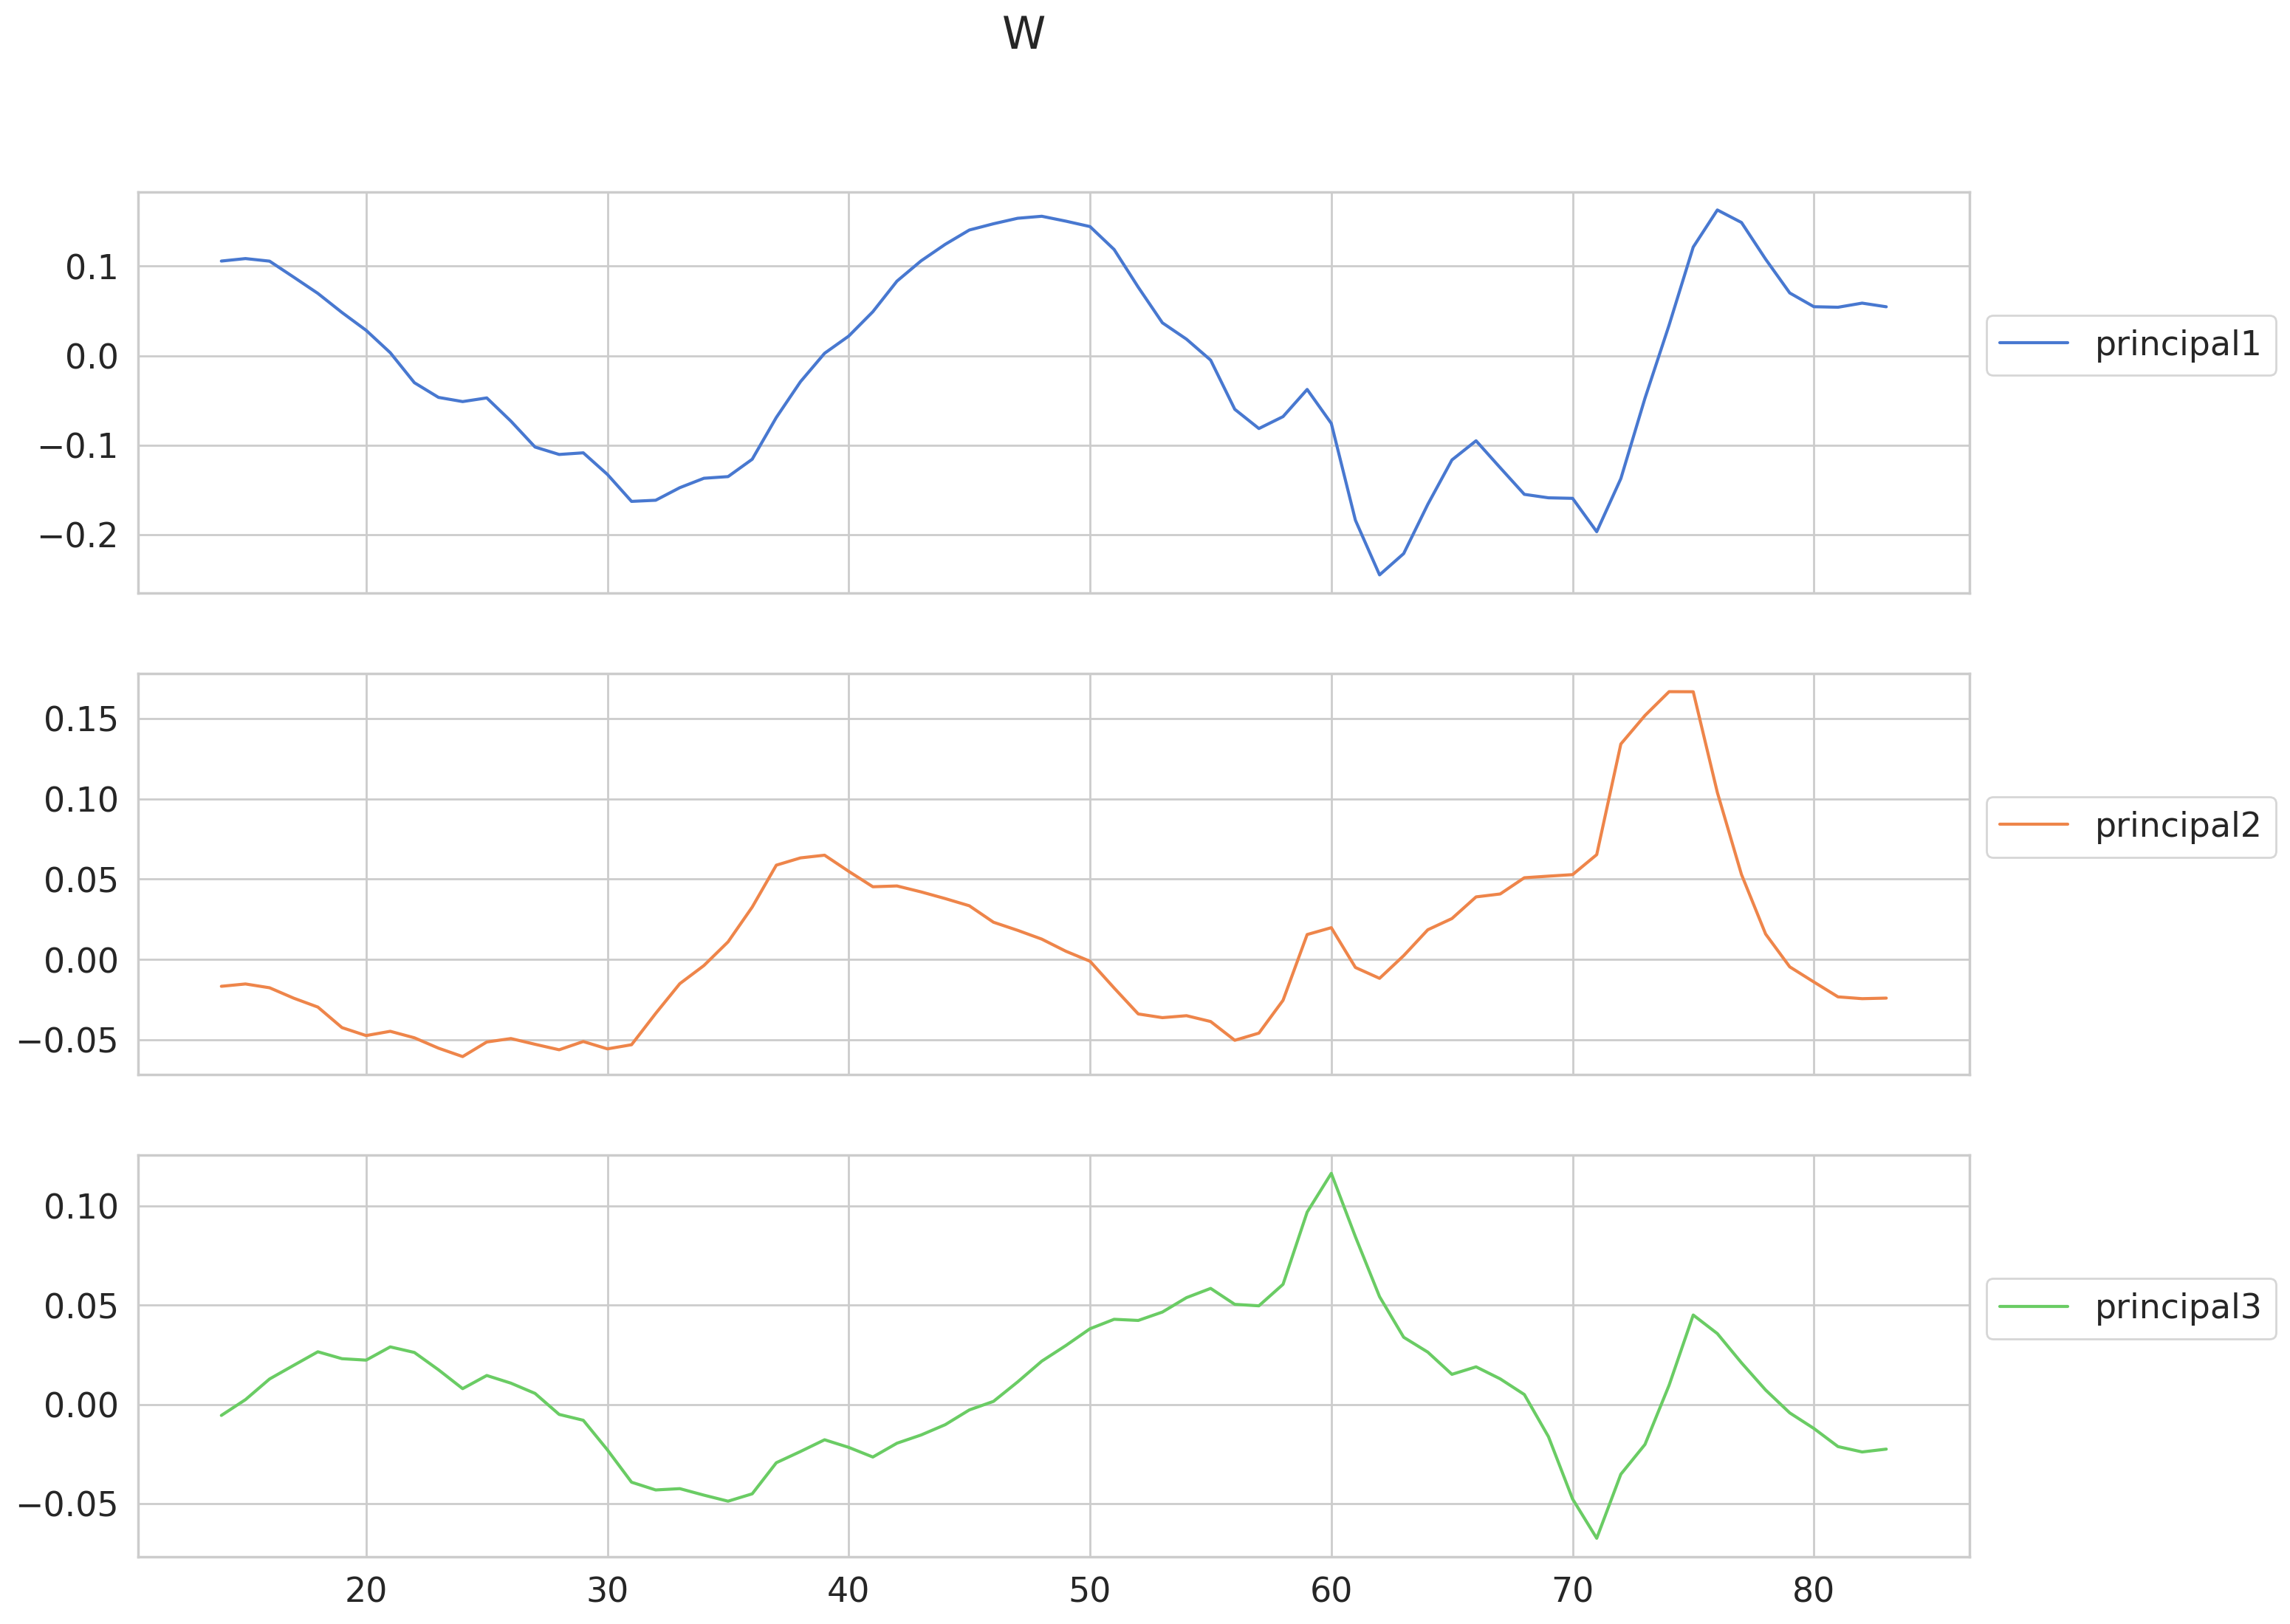

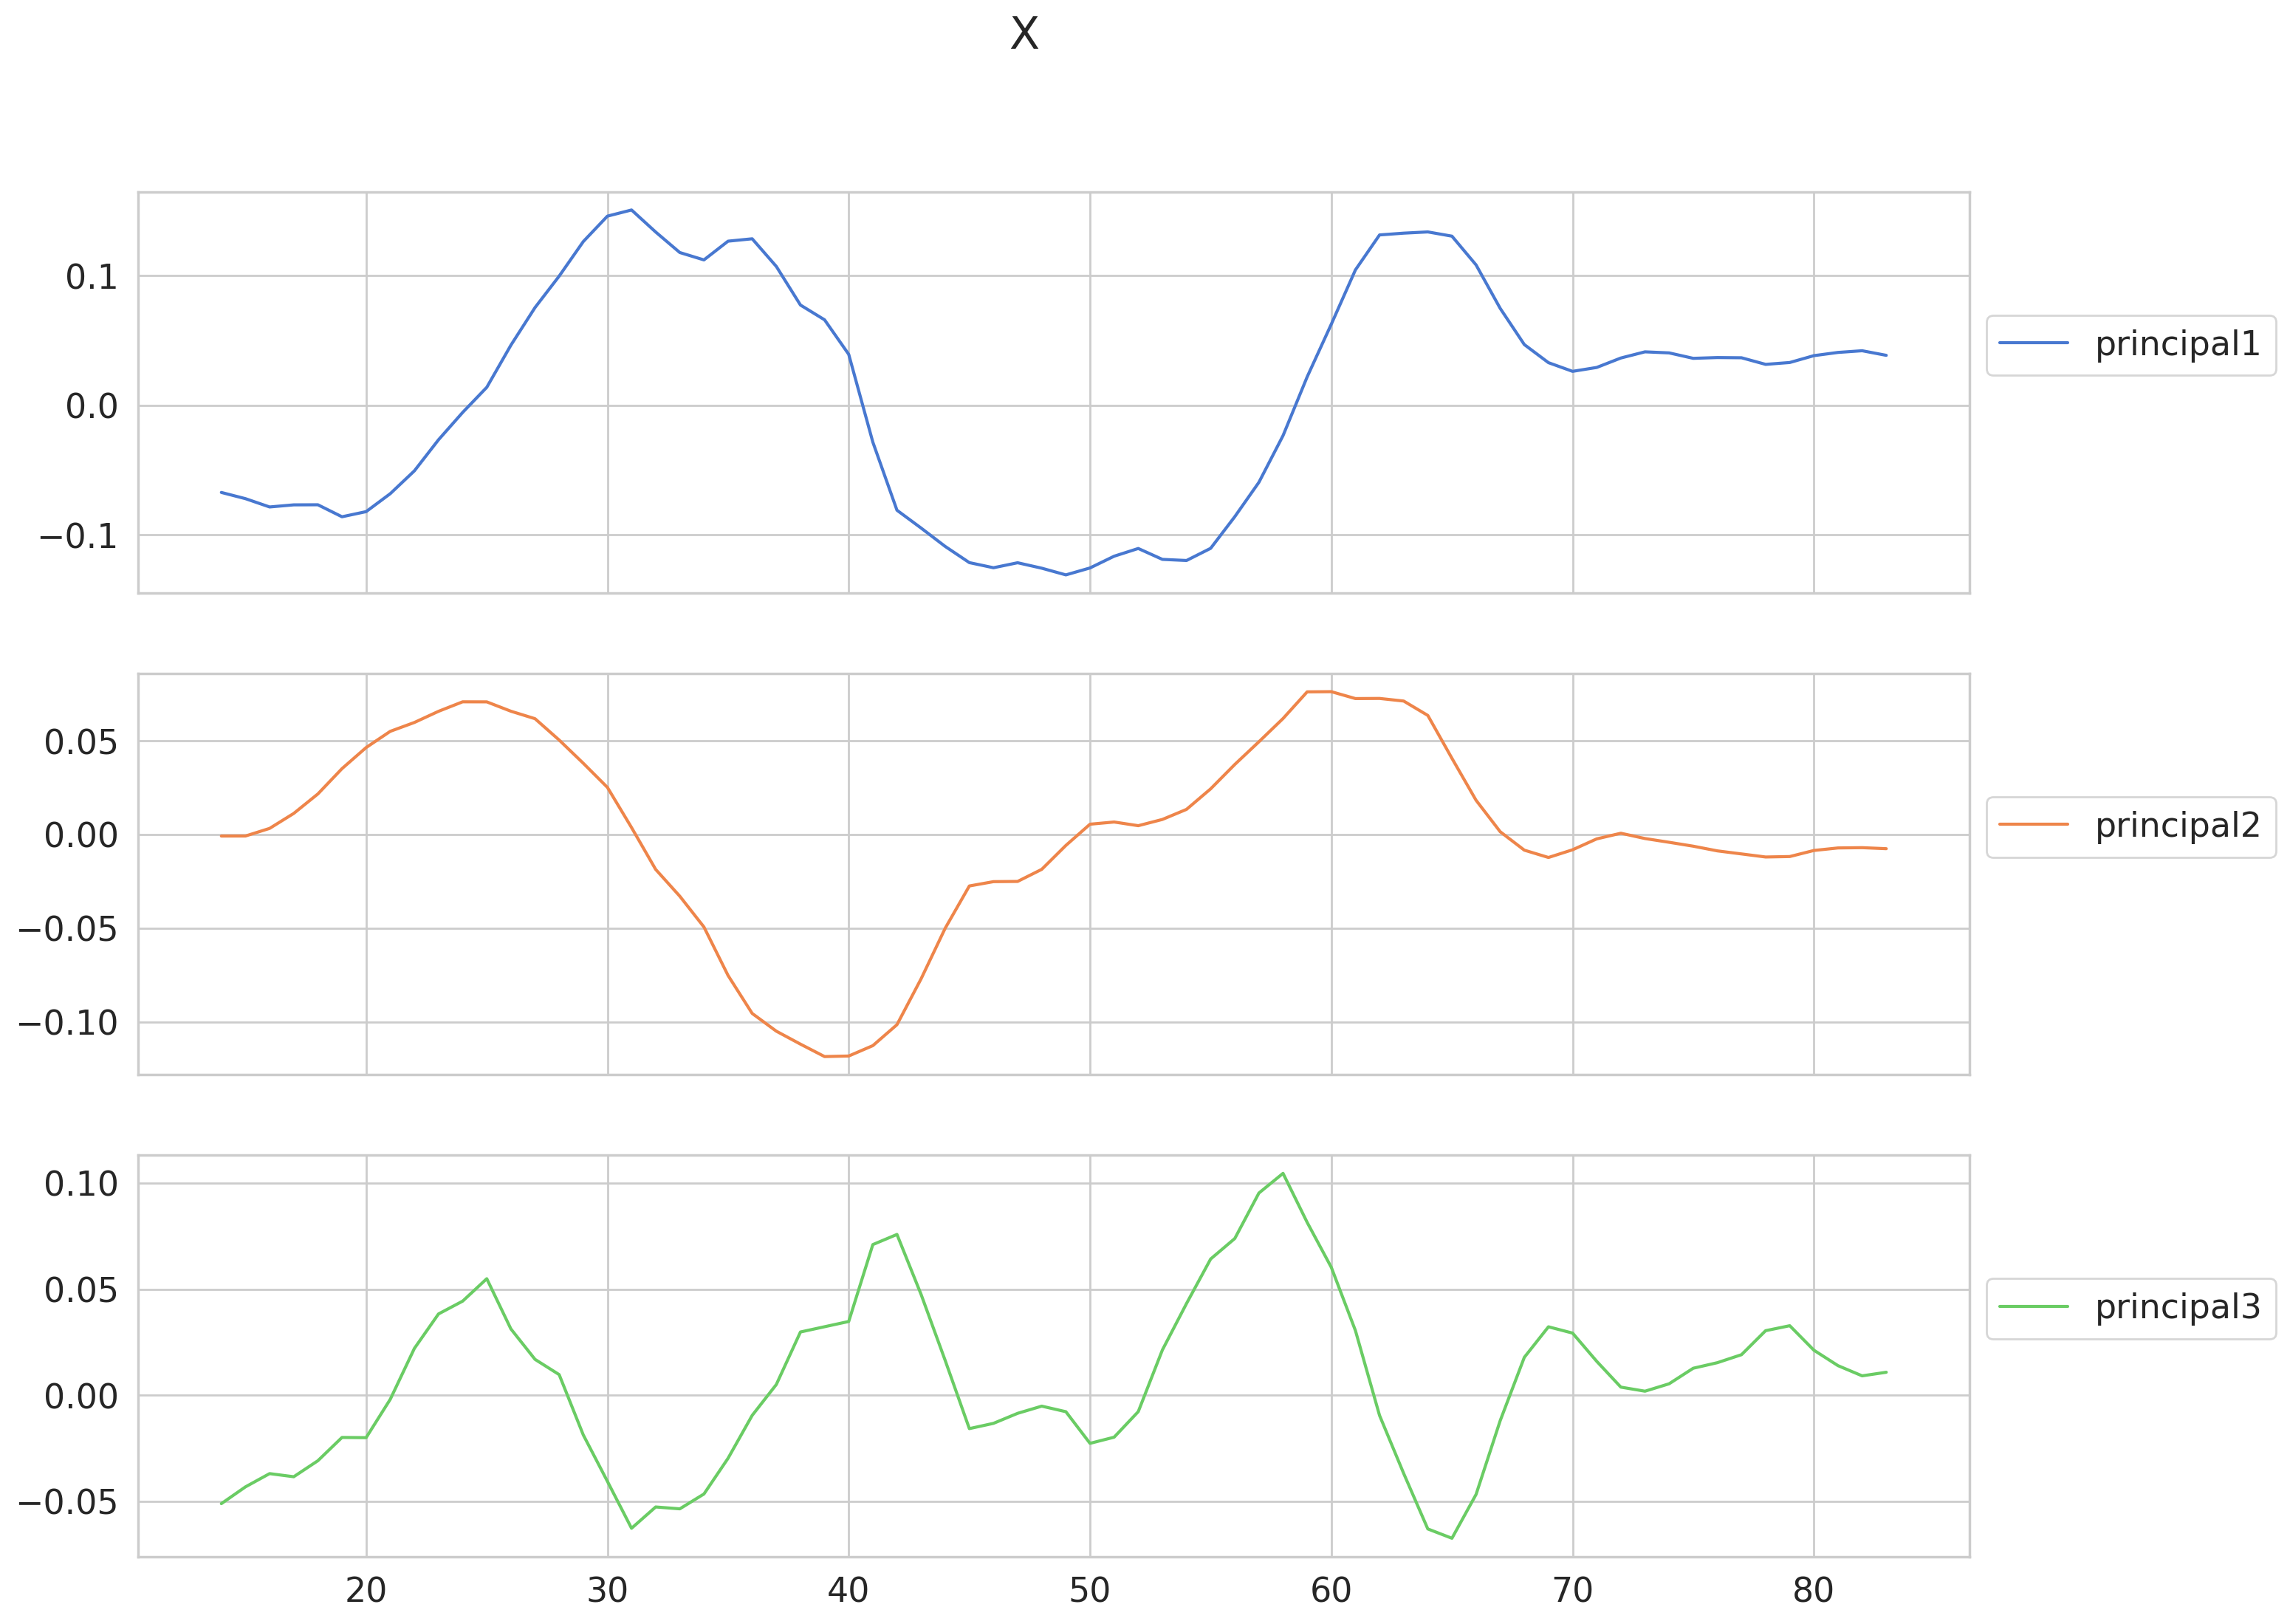

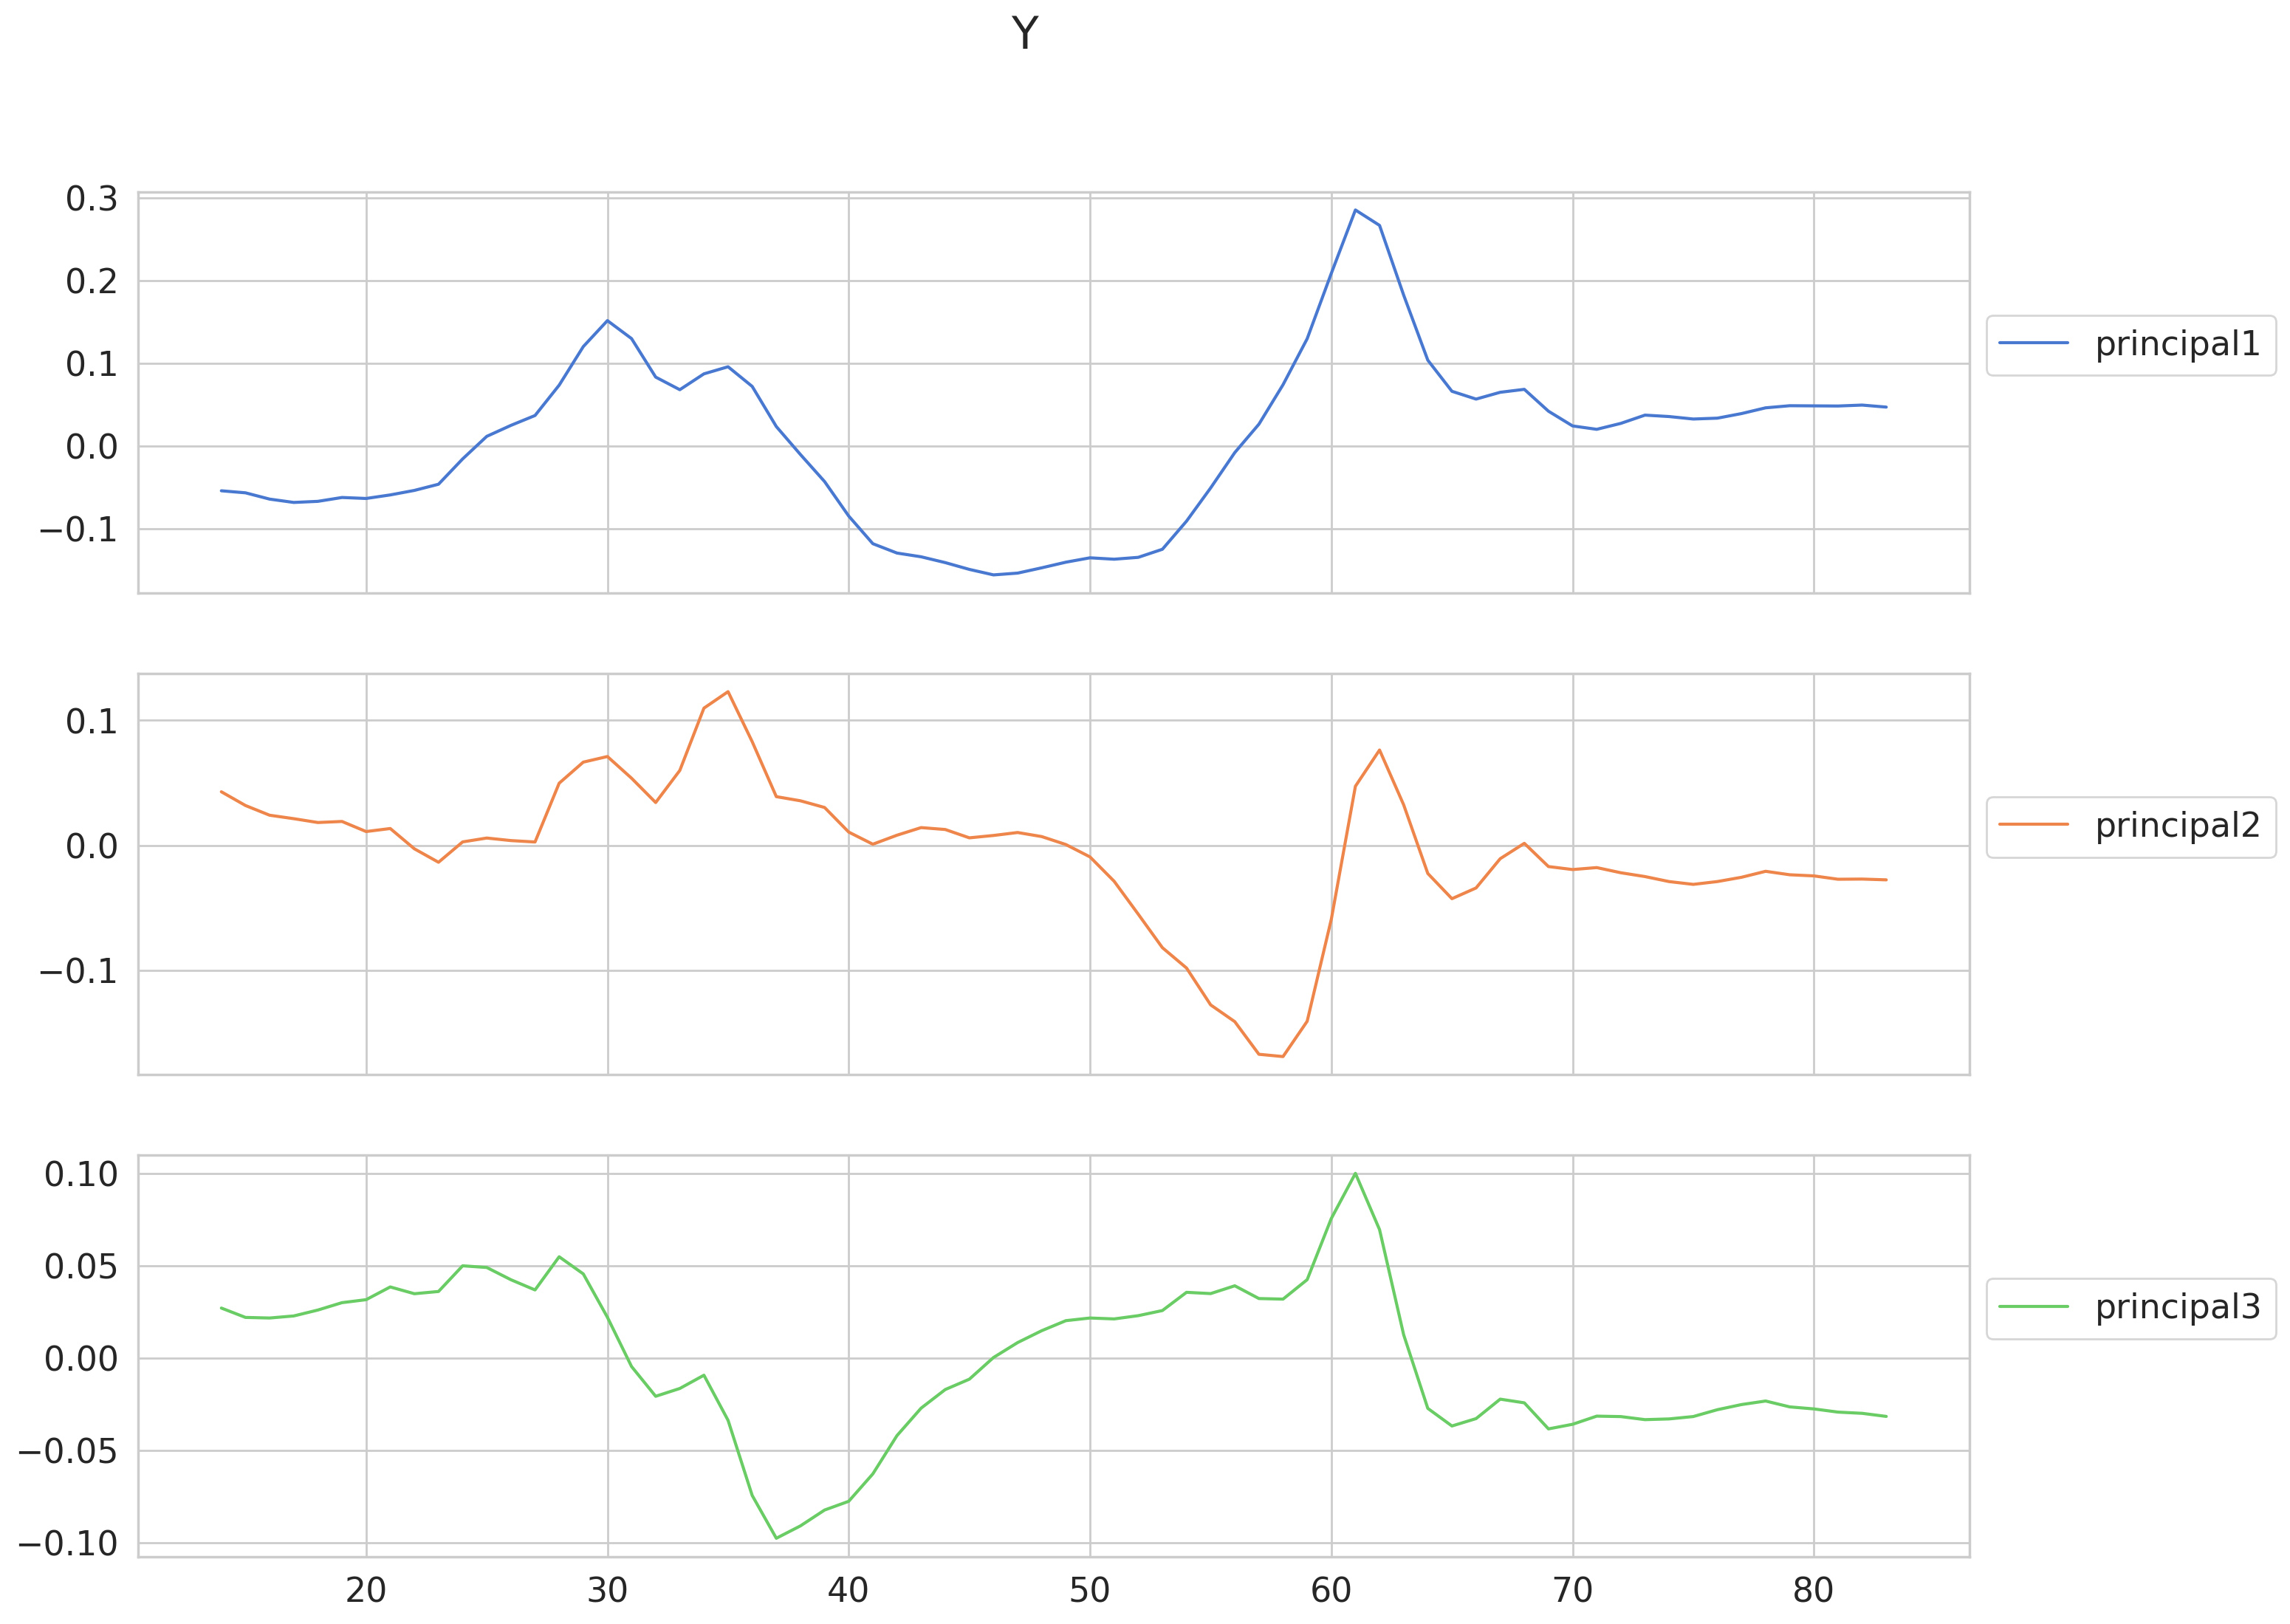

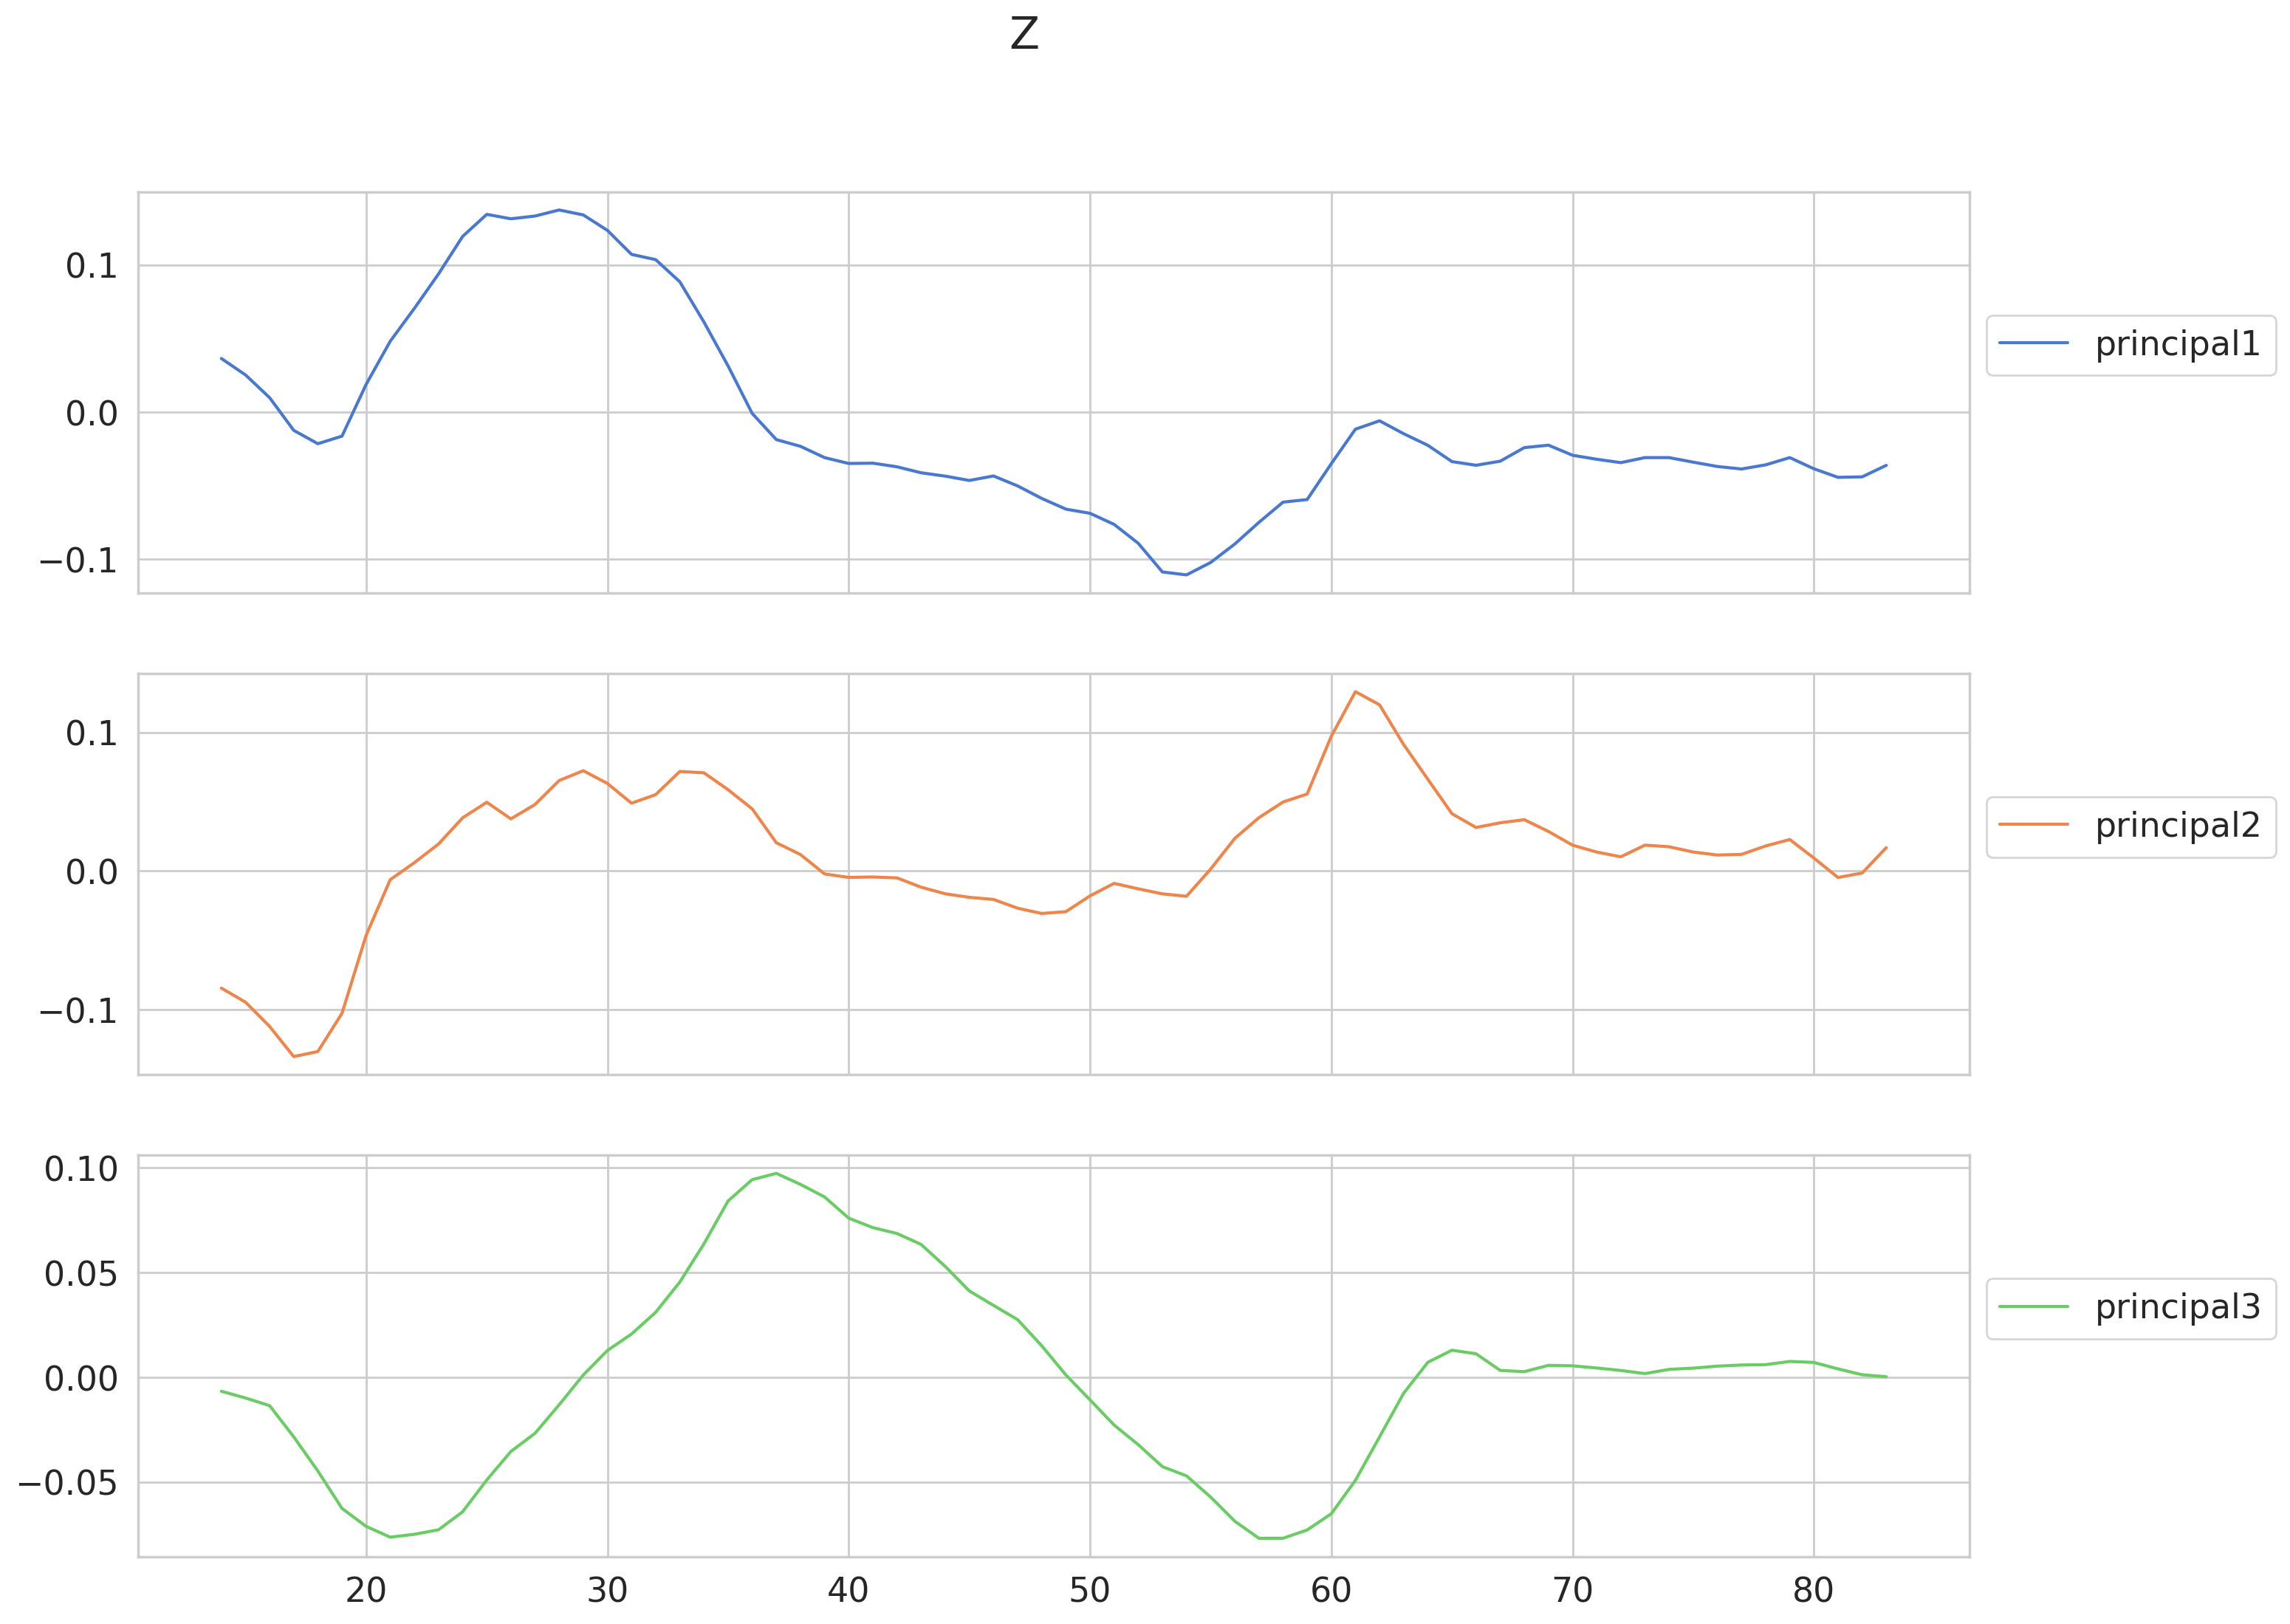

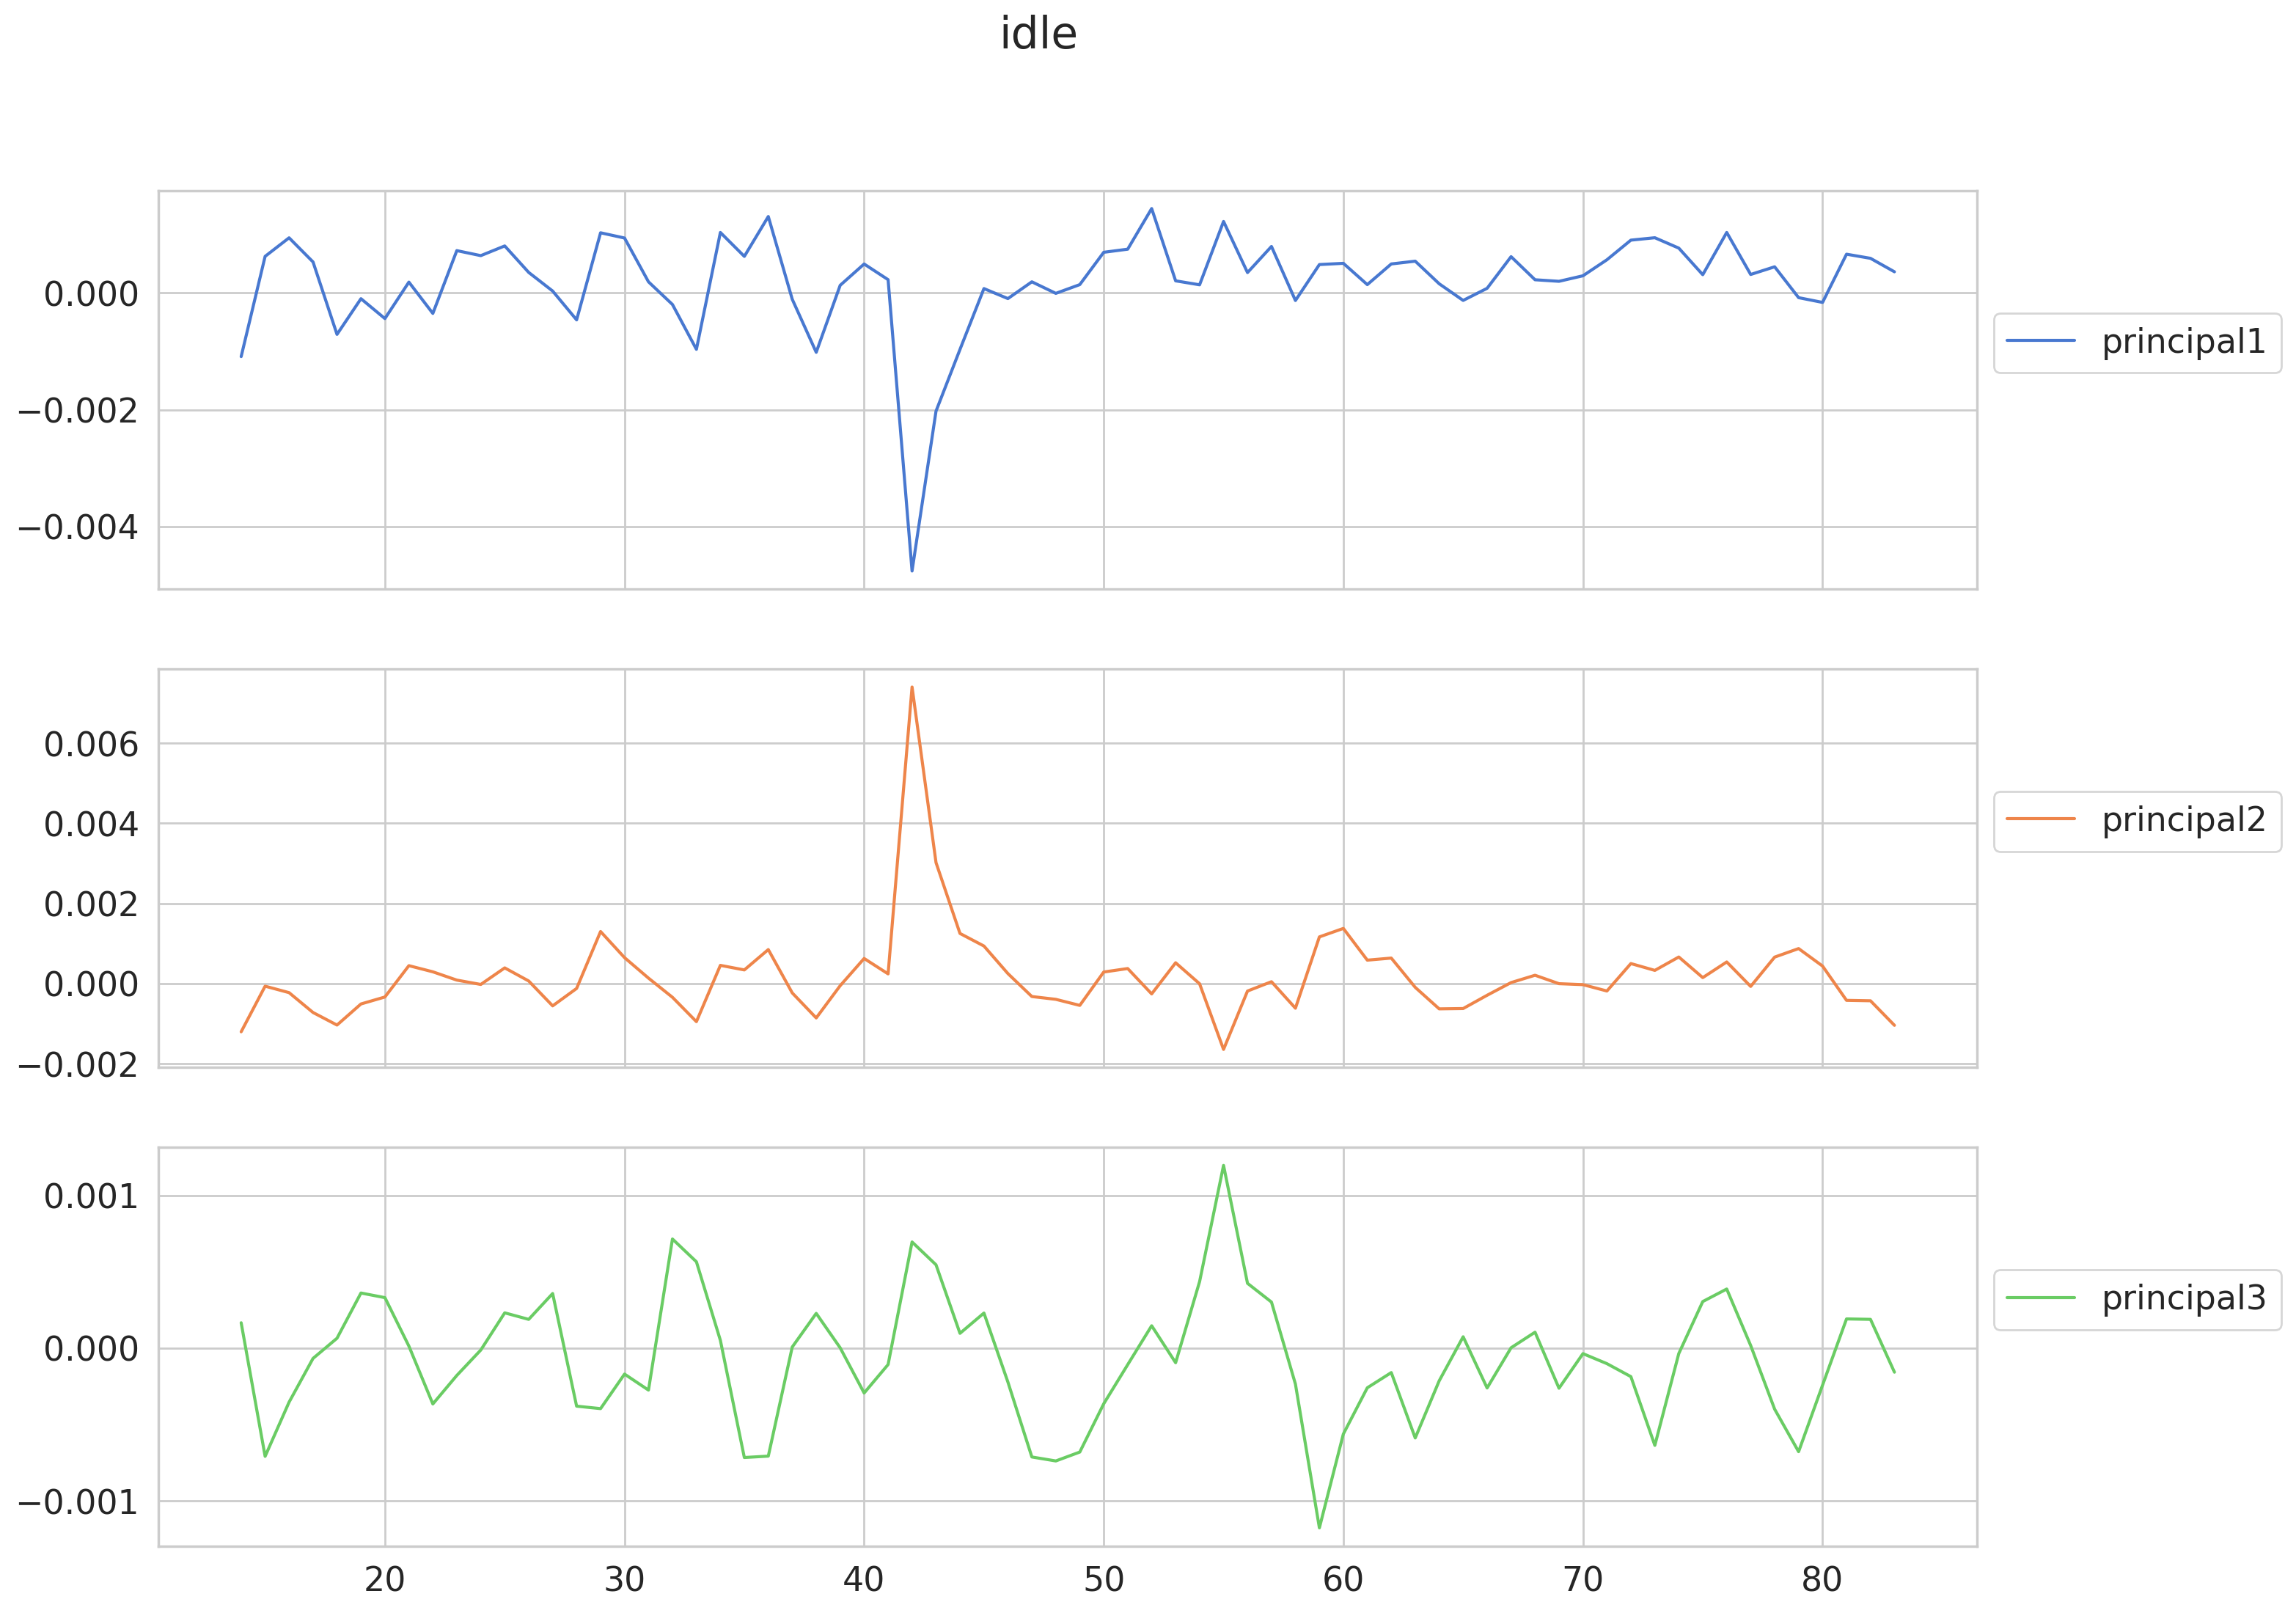

In [25]:
for label in GESTURES:
    plot_label(label, df_train)

In [26]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()

# scaling_columns = ['ax', 'ay', 'az','gx','gy','gz']

# df_train[scaling_columns] = scaler.fit_transform(df_train[scaling_columns])


In [27]:
from sklearn.model_selection import train_test_split
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(np.unique(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 70
STEP = 20

X_train, y_train = create_dataset(
    df_train[['principal1','principal2','principal3']], 
    df_train.label, 
    TIME_STEPS, 
    STEP
)

X_train, X_validate, y_train, y_valiadate = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

In [28]:
print(X_train.shape, y_train.shape)

(28210, 70, 3) (28210, 1)


In [29]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_valiadate = enc.transform(y_valiadate)

In [30]:
print(X_validate.shape, y_valiadate.shape)

(7053, 70, 3) (7053, 27)


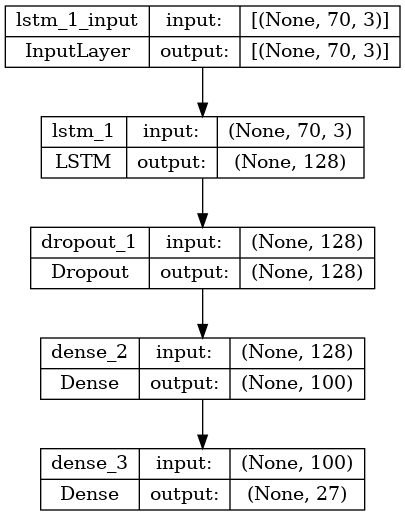

In [31]:
model = keras.Sequential()
model.add(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
keras.utils.plot_model(model, show_shapes=True, to_file='model_pca.png')

In [32]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_validate, y_valiadate),
)
model.summary()
model.save('lstm_pca')

Epoch 1/30


441/441 [==============================] - 8s 15ms/step - loss: 3.0592 - acc: 0.0790 - val_loss: 2.7066 - val_acc: 0.1547
Epoch 2/30
441/441 [==============================] - 6s 14ms/step - loss: 2.5324 - acc: 0.1658 - val_loss: 2.3565 - val_acc: 0.2084
Epoch 3/30
441/441 [==============================] - 6s 13ms/step - loss: 2.3354 - acc: 0.2178 - val_loss: 2.2070 - val_acc: 0.2476
Epoch 4/30
441/441 [==============================] - 6s 14ms/step - loss: 2.1696 - acc: 0.2688 - val_loss: 2.0376 - val_acc: 0.3180
Epoch 5/30
441/441 [==============================] - 6s 14ms/step - loss: 1.9775 - acc: 0.3349 - val_loss: 1.7685 - val_acc: 0.4116
Epoch 6/30
441/441 [==============================] - 6s 14ms/step - loss: 1.7224 - acc: 0.4303 - val_loss: 1.5692 - val_acc: 0.4886
Epoch 7/30
441/441 [==============================] - 6s 14ms/step - loss: 1.5130 - acc: 0.5034 - val_loss: 1.3349 - val_acc: 0.5653
Epoch 8/30
441/441 [==============================] - 6s 14ms/step - loss: 1.375

INFO:tensorflow:Assets written to: lstm_pca/assets


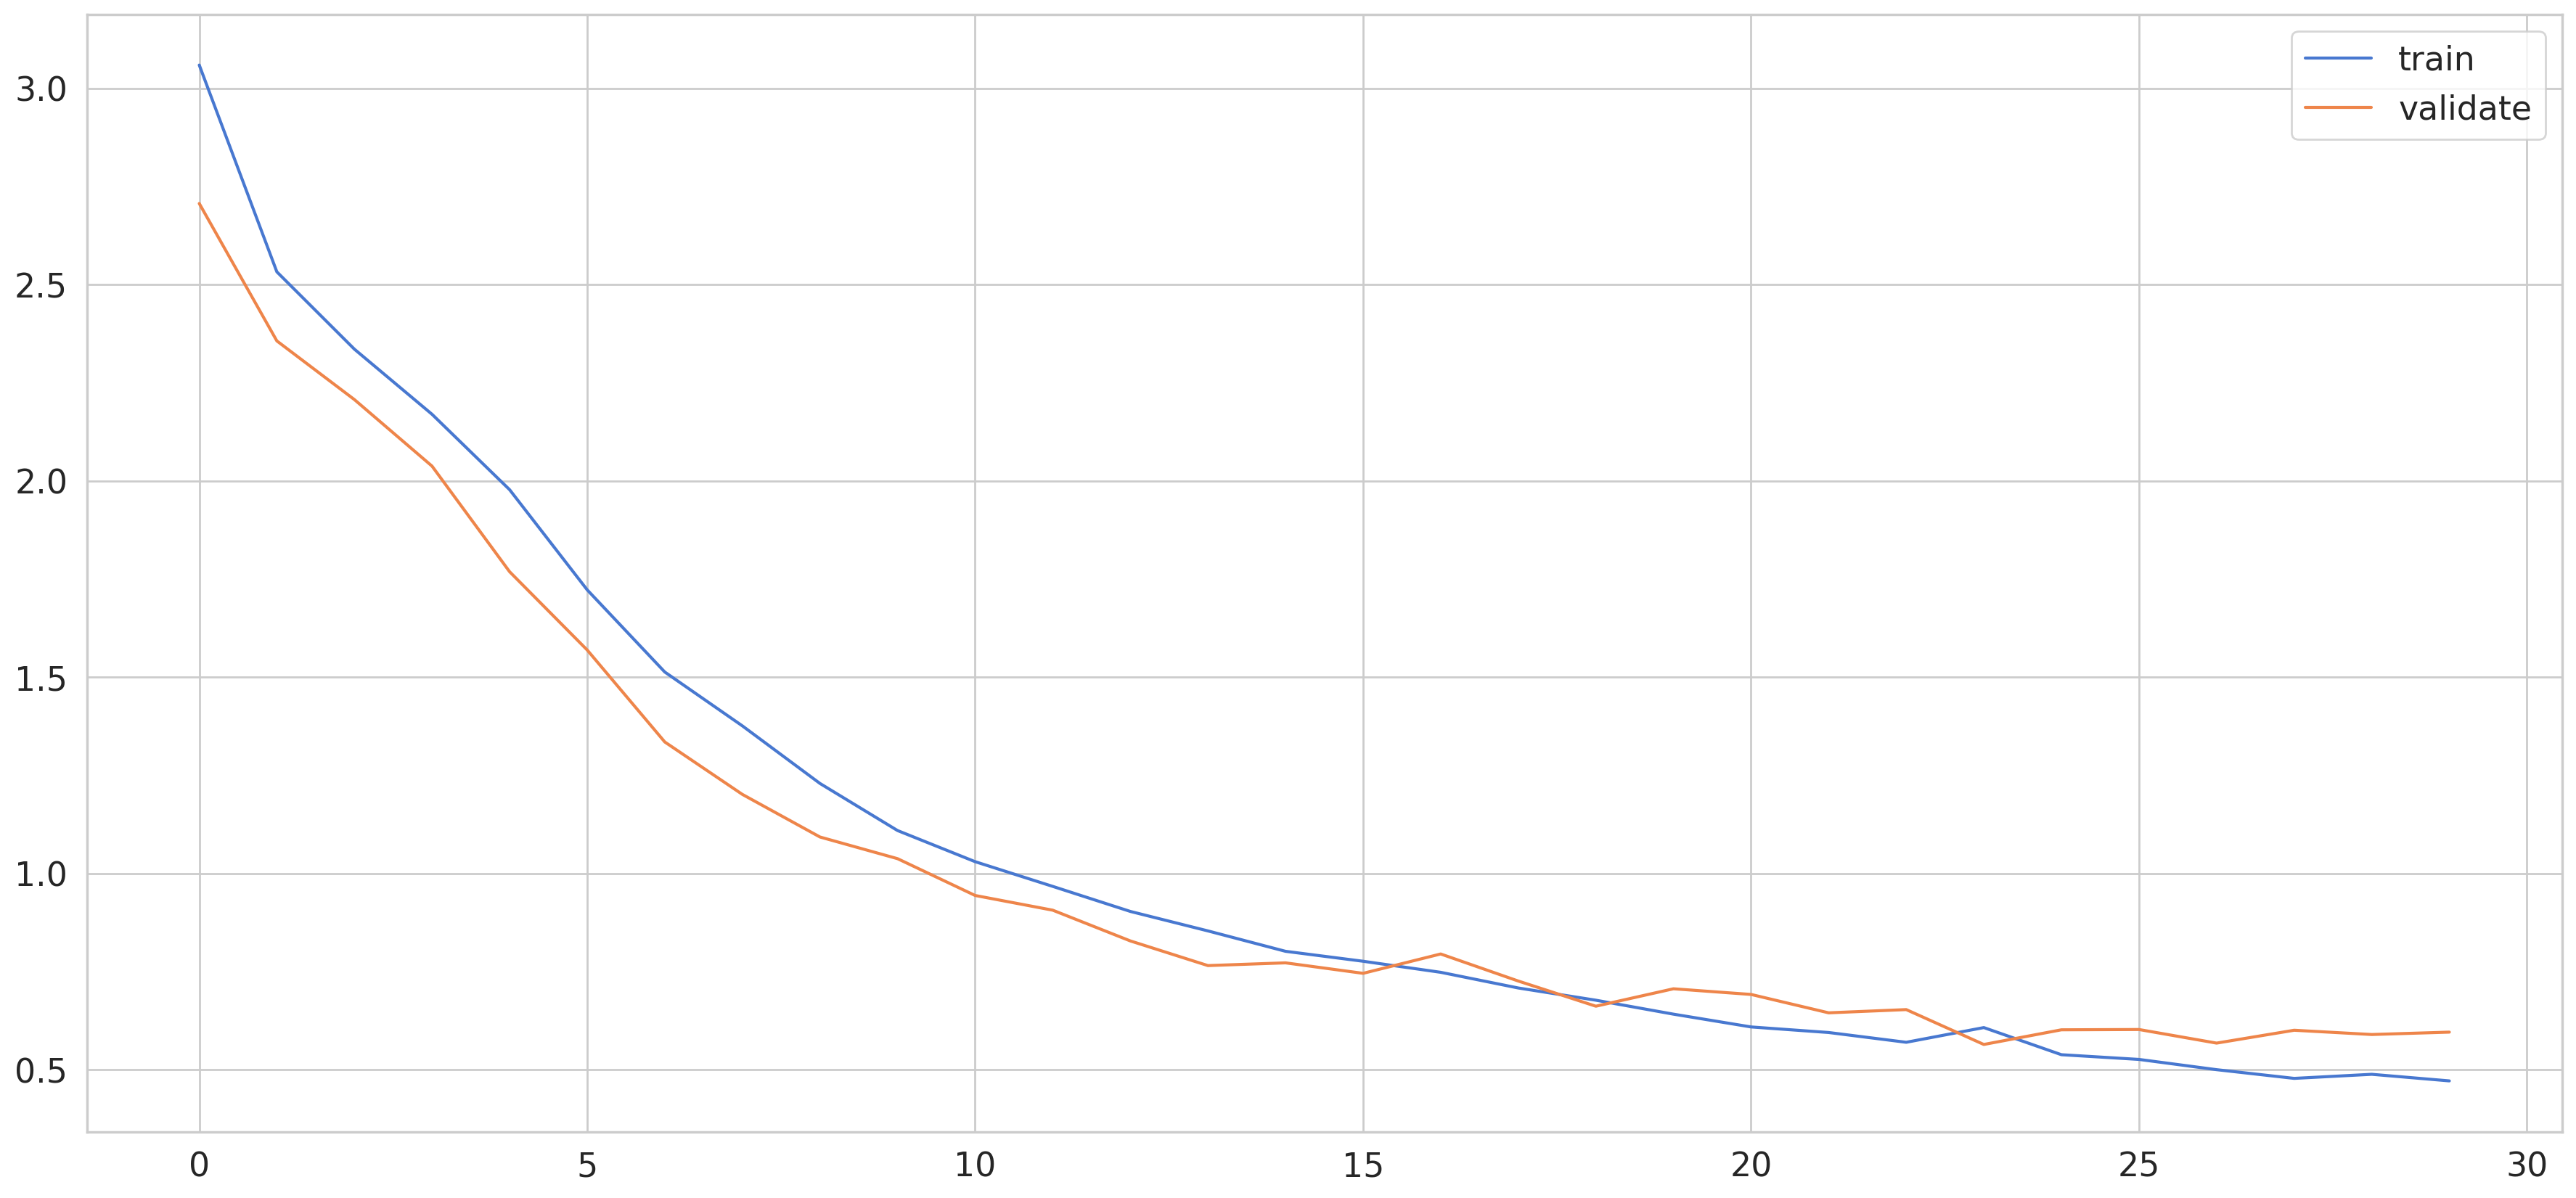

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend();

In [34]:
# model.evaluate(X_test, y_test)